In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcol
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density

from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import ICRS

from galpy.potential import evaluatePotentials,evaluateRforces,evaluatezforces,mass,vcirc,LogarithmicHaloPotential,MiyamotoNagaiPotential,HernquistPotential,DiskSCFPotential,NFWPotential,SCFPotential,mwpot_helpers,scf_compute_coeffs_axi
from galpy.potential.mwpotentials import McMillan17,MWPotential2014
from galpy.orbit import Orbit
from galpy.util import conversion
from GalPot import GalaxyPotential
import gala.potential as gp
from gala.units import UnitSystem
from dustmaps.gaia_tge import GaiaTGEQuery
from zero_point import zpt

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN
%matplotlib inline

In [2]:
# enter path of table to be used:
# for now enter the table I downloaded from Gaia, as 4MOST input catalogue does not contain all parameters yet
path='data/4MOST_S2_chemo_kinem_analysis.fits'
hdu_list = fits.open(path, memmap=True)
data_rv = Table(hdu_list[1].data)
hdu_list.close()
data_rv = data_rv[(data_rv['dec'] <= 5) & (data_rv['FeH_CaHKsyn']<=-0.4) & (np.isnan(data_rv['radial_velocity'])==False)]
data_rv

<Table length=909496>
   source_id        E(B-V)          G_0         ...   VERR    HRV    e_HRV 
     int64         float64        float64       ... float32 float64 float32
---------------- ----------- ------------------ ... ------- ------- -------
1004202009188352  0.11748102 14.316557034306495 ...     nan     nan     nan
1005885636393984  0.10434074 14.365784798404889 ...     nan     nan     nan
1011177036100992 0.116869524 13.607869865222938 ...     nan     nan     nan
1009871366012800  0.12096989  14.05460246020679 ...     nan     nan     nan
1009149811510784  0.11538504 12.239788910103808 ...     nan     nan     nan
1031724159655296   0.1094729 14.365019019662531 ...     nan     nan     nan
             ...         ...                ... ...     ...     ...     ...
 971251020192640 0.097045615  12.58458652249982 ...     nan     nan     nan
 978191687136896  0.10142019 13.703615147911758 ...     nan     nan     nan
 981245408325504  0.10233818 13.613805938956448 ...     nan     nan     nan
 990629912562048  0.08205539 11.919700726298764 ...     nan     nan     nan
 990011437273472  0.08012942  14.16760669002005 ...     nan     nan     nan
 995332901059840 0.099562906 12.854192893006694 ...     nan     nan     nan
 999700883485568  0.10613623 12.750850402623625 ...     nan     nan     nan

In [3]:
ra_rv = data_rv['ra'] # in deg
dec_rv = data_rv['dec'] # in deg
paral_rv = data_rv['parallax'] # in mas
paral_e_rv = data_rv['parallax_error'] # in mas
lat_rv = data_rv['b']
lon_rv = data_rv['l']
Gmag_rv = data_rv['phot_g_mean_mag'] # in mag
BP_rv = data_rv['phot_bp_mean_mag'] # in mag
RP_rv = data_rv['phot_rp_mean_mag'] # in mag
bprp_rv = BP_rv - RP_rv # in mag
BP0_rv = data_rv['BP_0'] # in mag
RP0_rv = data_rv['RP_0'] # in mag
bprp0_rv = BP0_rv - RP0_rv # in mag
distph = data_rv['distance_gspphot'] # in pc
distph_lower=data_rv['distance_gspphot_lower'] # in pc
distph_upper=data_rv['distance_gspphot_upper'] # in pc
distph_e=(distph_upper-distph_lower)/2 # in pc
pmra = data_rv['pmra'] # in mas/yr
pmra_e = data_rv['pmra_error'] # in mas/yr
pmdec = data_rv['pmdec'] # in mas/y
pmdec_e = data_rv['pmdec_error'] # in mas/yr
rad_vel_gaia = data_rv['radial_velocity'] # in km/s
rad_vel_gaia_e = data_rv['radial_velocity_error'] # in km/s
rad_vel_galah = data_rv['rv_galah'] # in km/s
rad_vel_galah_e = data_rv['e_rv_galah'] # in km/s
rad_vel_apo = data_rv['VHELIO_AVG'] # in km/s
rad_vel_apo_e = data_rv['VERR'] # in km/s
rad_vel_rave = data_rv['HRV'] # in km/s
rad_vel_rave_e = data_rv['e_HRV'] # in km/s
ruwe = data_rv['ruwe']
bprp_excess = data_rv['phot_bp_rp_excess_factor']
source = data_rv['source_id']
feh = data_rv['FeH_CaHKsyn'] # in dex
astr_par_sol = data_rv['astrometric_params_solved']
ecl_lat = data_rv['ecl_lat']
pseudocolour = data_rv['pseudocolour']
nu_eff = data_rv['nu_eff_used_in_astrometry']

# use the script by Lindegren et al. (2021) to compute zero-points of the parallax
zpt.load_tables()
valid = astr_par_sol > 3
zp=np.empty(shape=len(Gmag_rv))
zp[valid] = zpt.get_zpt(Gmag_rv[valid], nu_eff[valid], pseudocolour[valid], ecl_lat[valid], astr_par_sol[valid],_warnings=False)
zp[valid==False] = 0

paral0_rv = paral_rv - zp # in mas

data_rv=[] # free up RAM space

# define colormap for all the density plots
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

## 5.1. The 6D-Gaia-data subset of 4MOST S2; validation radial velocities

/home/jens/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)

/home/jens/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)

Number of radial velocities in Gaia DR3: 909496
Median Gaia radial velocity error: 3.991
Number of radial velocities in GALAH DR3: 55043
Median GALAH radial velocity error: 0.129
Number of radial velocities in APOGEE DR17: 14173
Median APOGEE radial velocity error: 0.055
Number of radial velocities in RAVE DR6: 15649
Median RAVE radial velocity error: 1.69


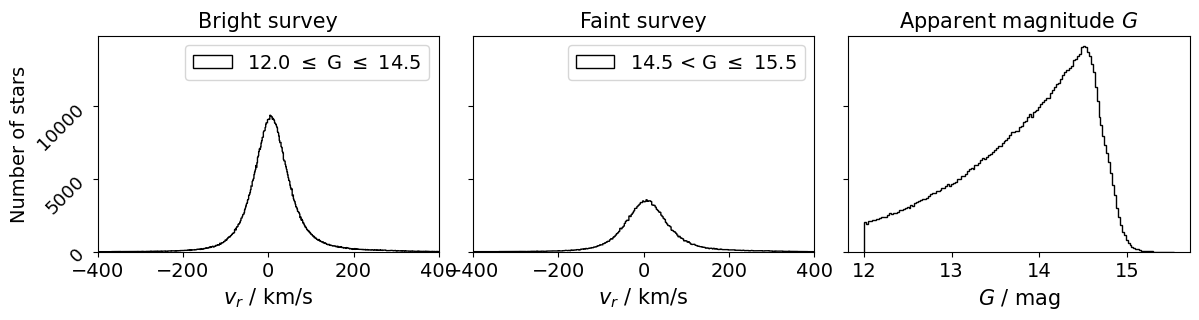

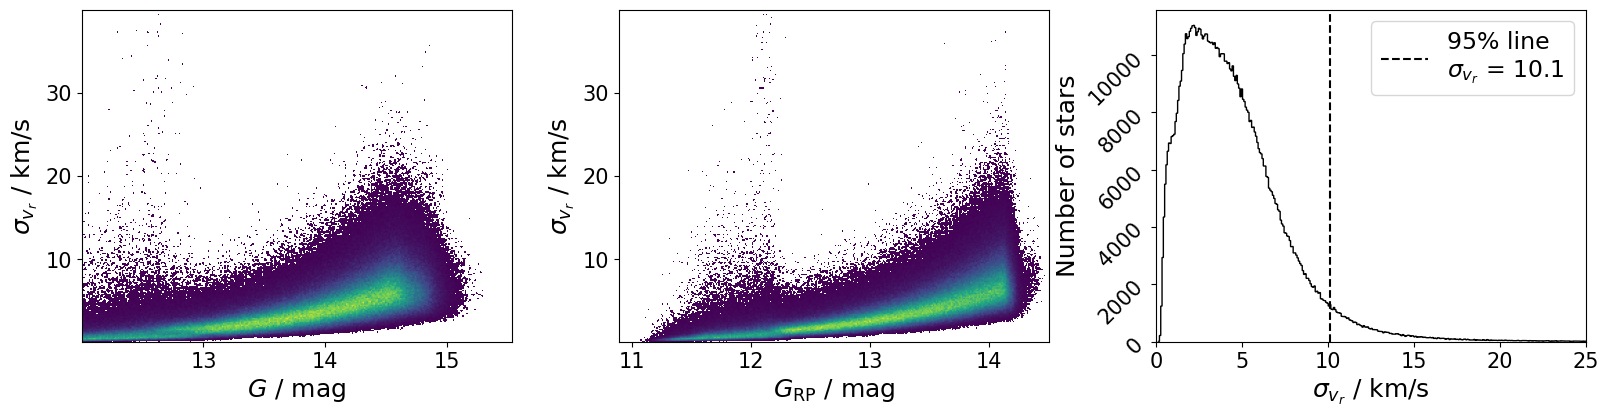

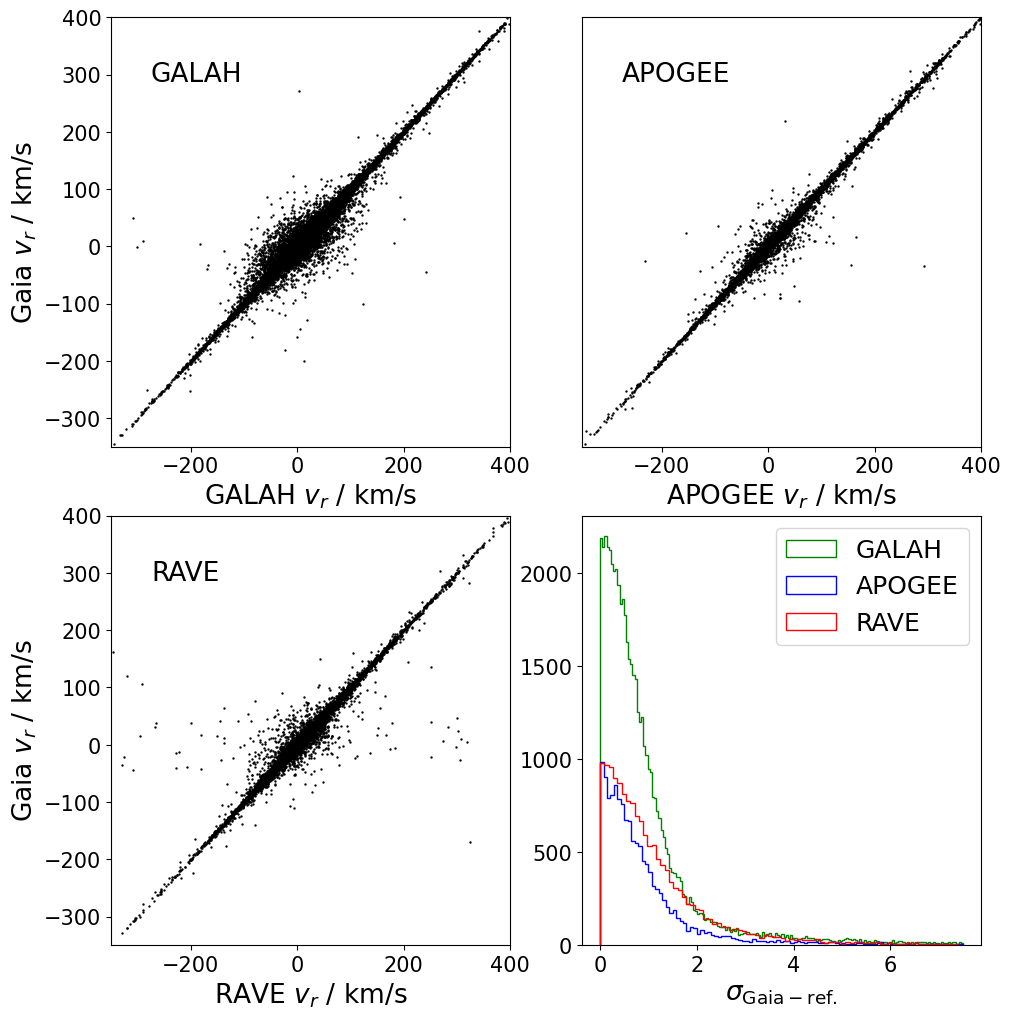

In [4]:
# subsurvey conditions
bright_rv = (Gmag_rv<=14.5)
faint_rv = (Gmag_rv>14.5) & (Gmag_rv<=15.5)
deepall_rv = (Gmag_rv>15.5)

# figure out 95% cutoff for errors
percent=95
for i in np.linspace(0,20,100):
    if len(rad_vel_gaia_e[rad_vel_gaia_e <= i])/len(rad_vel_gaia_e[np.isnan(rad_vel_gaia_e)==False]) >= percent/100:
        lim1=i
        break
    else:
        continue

# Distributions of radial velocities by subsurveys
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,3),sharey=True)
axs[0].hist(rad_vel_gaia[bright_rv],bins='auto',label='12.0 $\leq$ G $\leq$ 14.5',histtype='step', stacked=True, fill=False,color='black')
axs[0].set_xlabel('$v_r$ / km/s',size=15)
axs[0].set_ylabel('Number of stars',size=14)
axs[0].set_title('Bright survey',size=15)
axs[0].set_xlim(-400,400)
axs[0].legend(fontsize=14)
axs[0].tick_params(axis='x',labelsize=14)
axs[0].tick_params(axis='y',labelsize=13,labelrotation=45)
axs[1].hist(rad_vel_gaia[faint_rv],bins='auto',label='14.5 < G $\leq$ 15.5',histtype='step', stacked=True, fill=False,color='black')
axs[1].set_xlabel('$v_r$ / km/s',size=15)
axs[1].set_title('Faint survey',size=15)
axs[1].set_xlim(-400,400)
axs[1].legend(fontsize=14)
axs[1].tick_params(axis='x',labelsize=14)
axs[2].hist(Gmag_rv[np.isnan(rad_vel_gaia)==False],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[2].set_xlabel('$G$ / mag',size=15)
axs[2].set_title('Apparent magnitude $G$',size=15)
axs[2].tick_params(axis='x',labelsize=14)
plt.subplots_adjust(wspace=0.1,left=0.08,bottom=0.19,top=0.91,right=0.99)
plt.savefig('figures/5_01_radvel_hist.png',format='png')

# now plot radial velocity error vs. the G band magnitude and also vs. the RP band magnitude
radvel_e=plt.figure(figsize=(16,4))
ax = radvel_e.add_subplot(1, 3, 1, projection='scatter_density')
density = ax.scatter_density(Gmag_rv[np.isnan(rad_vel_gaia_e)==False],rad_vel_gaia_e[np.isnan(rad_vel_gaia_e)==False], cmap=white_viridis)
plt.xlabel('$G$ / mag',size=18)
plt.ylabel('$\sigma_{v_r}$ / km/s',size=18)
plt.tick_params(axis='both',labelsize=15)
ax = radvel_e.add_subplot(1, 3, 2, projection='scatter_density')
density = ax.scatter_density(RP_rv[np.isnan(rad_vel_gaia_e)==False],rad_vel_gaia_e[np.isnan(rad_vel_gaia_e)==False], cmap=white_viridis)
plt.xlabel('$G_{\mathrm{RP}}$ / mag',size=18)
plt.ylabel('$\sigma_{v_r}$ / km/s',size=18)
plt.tick_params(axis='both',labelsize=15)
ax = radvel_e.add_subplot(1, 3, 3)
plt.hist(rad_vel_gaia_e,bins='auto',histtype='step', stacked=True, fill=False,color='black')
plt.axvline(lim1,color='black',ls='dashed',label=str(percent)+'% line\n$\sigma_{v_r}$ = '+str(round(lim1,2)))
plt.xlabel('$\sigma_{v_r}$ / km/s',size=18)
plt.ylabel('Number of stars',size=18)
plt.xlim(0,25)
plt.legend(fontsize=17)
plt.tick_params(axis='x',labelsize=15)
plt.tick_params(axis='y',labelsize=15,labelrotation=45)
plt.subplots_adjust(wspace=0.25,left=0.05,bottom=0.16,right=0.99,top=0.99)
plt.savefig('figures/5_02_radvel_error.png',format='png')

# compare Gaia DR3 to GALAH, APOGEE, RAVE
print('Number of radial velocities in Gaia DR3:',len(rad_vel_gaia[np.isnan(rad_vel_gaia)==False]))
print('Median Gaia radial velocity error:',round(np.nanmedian(rad_vel_gaia_e),3))
print('Number of radial velocities in GALAH DR3:',len(rad_vel_galah[np.isnan(rad_vel_galah)==False]))
print('Median GALAH radial velocity error:',round(np.nanmedian(rad_vel_galah_e),3))
print('Number of radial velocities in APOGEE DR17:',len(rad_vel_apo[np.isnan(rad_vel_apo)==False]))
print('Median APOGEE radial velocity error:',round(np.nanmedian(rad_vel_apo_e),3))
print('Number of radial velocities in RAVE DR6:',len(rad_vel_rave[np.isnan(rad_vel_rave)==False]))
print('Median RAVE radial velocity error:',round(np.nanmedian(rad_vel_rave_e),3))

sig_dev_gg=np.abs(rad_vel_gaia-rad_vel_galah)/np.sqrt(rad_vel_gaia_e**2+rad_vel_galah_e**2)
sig_dev_ga=np.abs(rad_vel_gaia-rad_vel_apo)/np.sqrt(rad_vel_gaia_e**2+rad_vel_apo_e**2)
sig_dev_gr=np.abs(rad_vel_gaia-rad_vel_rave)/np.sqrt(rad_vel_gaia_e**2+rad_vel_rave_e**2)

# Validation of Gaia DR3 radial velocity
radvel=plt.figure(figsize=(10,10))
ax = radvel.add_subplot(2, 2, 1, projection='scatter_density')
#density = ax.scatter_density(rad_vel_galah[(np.isnan(rad_vel_gaia)==False) & (np.isnan(rad_vel_galah)==False)],rad_vel_gaia[(np.isnan(rad_vel_gaia)==False) & (np.isnan(rad_vel_galah)==False)], cmap=white_viridis)
plt.scatter(rad_vel_galah,rad_vel_gaia,s=0.5,color='black')
plt.annotate('GALAH', xy=(0.1, 0.85), xycoords='axes fraction',size=19)
plt.xlabel('GALAH $v_r$ / km/s',size=19)
plt.ylabel('Gaia $v_r$ / km/s',size=19)
plt.xlim(-350,400)
plt.ylim(-350,400)
plt.tick_params(axis='both',labelsize=15)
ax = radvel.add_subplot(2, 2, 2, projection='scatter_density')
#density = ax.scatter_density(rad_vel_apo[(np.isnan(rad_vel_gaia)==False) & (np.isnan(rad_vel_apo)==False)],rad_vel_gaia[(np.isnan(rad_vel_gaia)==False) & (np.isnan(rad_vel_apo)==False)], cmap=white_viridis)
plt.scatter(rad_vel_apo,rad_vel_gaia,s=0.5,color='black')
plt.annotate('APOGEE', xy=(0.1, 0.85), xycoords='axes fraction',size=19)
plt.xlabel('APOGEE $v_r$ / km/s',size=19)
plt.yticks([])
plt.xlim(-350,400)
plt.ylim(-350,400)
plt.tick_params(axis='both',labelsize=15)
ax = radvel.add_subplot(2, 2, 3, projection='scatter_density')
#density = ax.scatter_density(rad_vel_rave[(np.isnan(rad_vel_gaia)==False) & (np.isnan(rad_vel_rave)==False)],rad_vel_gaia[(np.isnan(rad_vel_gaia)==False) & (np.isnan(rad_vel_rave)==False)], cmap=white_viridis)
plt.scatter(rad_vel_rave,rad_vel_gaia,s=0.5,color='black')
plt.annotate('RAVE', xy=(0.1, 0.85), xycoords='axes fraction',size=19)
plt.xlabel('RAVE $v_r$ / km/s',size=19)
plt.ylabel('Gaia $v_r$ / km/s',size=19)
plt.xlim(-350,400)
plt.ylim(-350,400)
plt.tick_params(axis='both',labelsize=15)
ax = radvel.add_subplot(2, 2, 4)
plt.hist(sig_dev_gg[sig_dev_gg<7.5],bins='auto',histtype='step', stacked=True, fill=False,color='green',label='GALAH')
plt.hist(sig_dev_ga[sig_dev_ga<7.5],bins='auto',histtype='step', stacked=True, fill=False,color='blue',label='APOGEE')
plt.hist(sig_dev_gr[sig_dev_gr<7.5],bins='auto',histtype='step', stacked=True, fill=False,color='red',label='RAVE')
plt.xlabel('$\sigma_\mathrm{Gaia-ref.}$',size=19)
plt.legend(fontsize=18)
plt.tick_params(axis='both',labelsize=15)
plt.subplots_adjust(wspace=0.18,hspace=0.16,left=0.11,right=0.98,top=0.99,bottom=0.062)
plt.savefig('figures/5_03_radvel_verification.png',format='png')

## 5.2. Kinematic parameter determination and selection of halo; kinematic plots

In [5]:
# Calculate kinematic parameters for analysis and for separation of halo

# radial velocity to use (for experimentation with GALAH, APOGEE, RAVE)
cond_ana=(np.isnan(rad_vel_gaia)==False)
rad_vel=rad_vel_gaia
rad_vel_e=rad_vel_gaia_e

# distances from parallaxes, only if relative error >3
no_paral = (np.isnan(paral0_rv) == True)
paral_bet3rv = (paral0_rv >= 3*paral_e_rv)
paral_wor3rv = (paral0_rv < 3*paral_e_rv)

dist_rv = np.empty(shape=(len(ra_rv)))
dist_rv[paral_bet3rv] = 1000/paral0_rv[paral_bet3rv]
dist_rv[no_paral] = np.nan
dist_rv[paral_wor3rv] = np.nan
#dist_rv[paral_wor3 & (distph>10*distph_e)] = distph[paral_wor3 & (distph>10*distph_e)]

# I want to filter out stars with unreliable radial velocities as well (more than 10 km/s)
print('The percentage of objects removed due to distance and radial velocity is '+str(round(100*(len(ra_rv[cond_ana & (np.isnan(dist_rv)==True)]) + len(ra_rv[cond_ana & (rad_vel_e>10)]) - len(ra_rv[cond_ana & (np.isnan(dist_rv)==True) & (rad_vel_e>10)]))/len(ra_rv[cond_ana]),2))+'%')
rad_vel[(rad_vel_e>10)] = np.nan
rad_vel_e[(rad_vel_e>10)] = np.nan
print('The number of objects left to do analyses with is '+str(len(ra_rv[cond_ana & (np.isnan(dist_rv)==False) & (np.isnan(rad_vel)==False)]))+', or '+str(round(100*len(ra_rv[cond_ana & (np.isnan(dist_rv)==False) & (np.isnan(rad_vel)==False)])/len(ra_rv[cond_ana]),2))+'%')

# for the CMDs later
M_G_rv=Gmag_rv+5-5*np.log10(dist_rv)

# calculate the G band extinctions from Gaia TGE dust map
coords_rv = coord.SkyCoord(lon_rv*u.deg, lat_rv*u.deg, frame='galactic')
tge = GaiaTGEQuery()
A0_rv = tge(coords_rv)
#A0_rv=azero_gspphot_rv

# G band
A_G_rv=np.empty(shape=(len(A0_rv)))

# using BP-RP for MS
a1=0.995969721536602
a2=-0.159726460302015
a3=0.0122380738156057
a4=0.00090726555099859
a5=-0.0377160263914123
a6=0.00151347495244888
a7=-2.52364537395142e-05
a8=0.0114522658102451
a9=-0.000936914989014318
a10=-0.000260296774134201
X = bprp_rv[(M_G_rv>5)==True]/5040
k_G_rv = a1+a2*X+a3*X**2+a4*X**3+a5*A0_rv[(M_G_rv>5)==True]+a6*A0_rv[(M_G_rv>5)==True]**2+a7*A0_rv[(M_G_rv>5)==True]**3+a8*A0_rv[(M_G_rv>5)==True]*X+a9*A0_rv[(M_G_rv>5)==True]*X**2+a10*X*A0_rv[(M_G_rv>5)==True]**2
A_G_rv[(M_G_rv>5)] = k_G_rv*A0_rv[(M_G_rv>5)]

# using BP-RP for HRD top
a1=0.996727636184546
a2=-0.161532912039159
a3=0.0121894634053956
a4=0.00108655443373807
a5=-0.0378418720324357
a6=0.00150218619071414
a7=-2.43558666819941e-05
a8=0.0119452762544019
a9=-0.000900410348061063
a10=-0.000285148019567325
X = bprp_rv[(M_G_rv>5)==False]/5040
k_G_rv = a1+a2*X+a3*X**2+a4*X**3+a5*A0_rv[(M_G_rv>5)==False]+a6*A0_rv[(M_G_rv>5)==False]**2+a7*A0_rv[(M_G_rv>5)==False]**3+a8*A0_rv[(M_G_rv>5)==False]*X+a9*A0_rv[(M_G_rv>5)==False]*X**2+a10*X*A0_rv[(M_G_rv>5)==False]**2
A_G_rv[(M_G_rv>5)==False] = k_G_rv*A0_rv[(M_G_rv>5)==False]

M_G0_rv = M_G_rv-A_G_rv

# add Sun parameters to set astropy transformation scale following plots by Sun
r_gc_sun=np.array([8122,0,20.8])*u.pc
v_gc_sun=np.array([11.1,12.24+232.8,7.25])*u.km/u.s

# using astropy get full cartesian coordinates for position and velocity
astrom=ICRS(ra=ra_rv*u.degree,dec=dec_rv*u.degree,distance=dist_rv*u.pc,pm_ra_cosdec=pmra*np.cos((dec_rv/360)*2*np.pi)*u.mas/u.yr,pm_dec=pmdec*u.mas/u.yr,radial_velocity=rad_vel*u.km/u.s)
# convert to galactocentric coordinates, define own parameters
gc_frame = coord.Galactocentric(galcen_distance=r_gc_sun[0],galcen_v_sun=v_gc_sun,z_sun=r_gc_sun[2])
gc=coord.SkyCoord(astrom).transform_to(gc_frame)

#NOTE: astropy is right-handed, galpy and kinematic analyses in general left-handed
# for now I put -gc.x and -gc.v_x instead of gc.x and gc.v_x as solution
gcx=-gc.x
gcvx=-gc.v_x

# position and velocity vectors
r_gc=np.transpose(np.array([gcx,gc.y,gc.z]))*u.pc # in pc
v_gc=np.transpose(np.array([gcvx,gc.v_y,gc.v_z]))*u.km/u.s # in km/s

# calculate velocities via Johnson & Soderblom (1987) instead of using astropy
l_rad=(lat_rv/360)*2*np.pi
b_rad=(lon_rv/360)*2*np.pi
ra_rad=(ra_rv/360)*2*np.pi
dec_rad=(dec_rv/360)*2*np.pi

alphag=(192.85948/360)*2*np.pi
deltag=(27.12825/360)*2*np.pi
l_ngp=(122.93192/360)*2*np.pi
k=4.74057

t1=np.array([[np.cos(l_ngp),np.sin(l_ngp),0],[np.sin(l_ngp),-np.cos(l_ngp),0],[0,0,1]])
t2=np.array([[-np.sin(deltag),0,np.cos(deltag)],[0,-1,0],[np.cos(deltag),0,np.sin(deltag)]])
t3=np.array([[np.cos(alphag),np.sin(alphag),0],[np.sin(alphag),-np.cos(alphag),0],[0,0,1]])
T=t1.dot(t2.dot(t3))
A=np.array([[np.cos(ra_rad)*np.cos(dec_rad),-np.sin(ra_rad),-np.cos(ra_rad)*np.sin(dec_rad)],[np.sin(ra_rad)*np.cos(dec_rad),np.cos(ra_rad),-np.sin(ra_rad)*np.sin(dec_rad)],[np.sin(dec_rad),np.zeros(len(ra_rad)),np.cos(dec_rad)]])
B=np.transpose(T.dot(np.transpose(A,axes=(1,0,2))),axes=(2,0,1))
icrs_vel=np.transpose(np.array([rad_vel_gaia,k*pmra*np.cos(dec_rad)/paral0_rv,k*pmdec/paral0_rv]))
v_gc = np.transpose(np.einsum('ijk,ik->ij',B,icrs_vel))
v_gc = np.transpose([-v_gc[0]-11.1,v_gc[1]+12.24+232.8,v_gc[2]+7.25])*u.km/u.s

# radial distances r and cylindrical distances R
rad=np.sqrt(np.transpose(r_gc)[0]**2+np.transpose(r_gc)[1]**2+np.transpose(r_gc)[2]**2) # in pc
R=np.sqrt(np.transpose(r_gc)[0]**2+np.transpose(r_gc)[1]**2) # in pc
z=np.transpose(r_gc)[2]

# absolute space velocities and zx-component of velocity
v_tot=np.sqrt(np.transpose(v_gc)[0]**2+np.transpose(v_gc)[1]**2+np.transpose(v_gc)[2]**2) # in km/s
v_zx=np.sqrt(np.transpose(v_gc)[0]**2+np.transpose(v_gc)[2]**2) # in km/s
print('There are '+str(len(ra_rv[np.array(v_tot)>500]))+' high-velocity stars at v_tot > 500 km/s.')

# specific angular momentum L=rxv
L=np.cross(r_gc,v_gc) # specific angular momentum in pc*km/s
L_x=np.transpose(L)[0]
L_y=np.transpose(L)[1]
L_z=np.transpose(L)[2]
L_perp=np.sqrt(L_x**2+L_y**2)

# for Sun as well
rad_sun=np.linalg.norm(r_gc_sun) # in pc
R_sun=np.sqrt(r_gc_sun[0]**2+r_gc_sun[1]**2) # in pc
v_sun=np.transpose(np.linalg.norm(v_gc_sun)) # in km/s
L_sun=np.cross(r_gc_sun,v_gc_sun) # in pc*km/s

# make different conditions for which to plot
# condition based on circularity see 2.1/2.2 (more sophisticated than next one)
# condition |v-v_lsr| > 210 km/s (rough estimate of halo)
cond_v=(np.sqrt(np.transpose(v_gc)[0]**2+(np.transpose(v_gc)[1]-232*u.km/u.s)**2+np.transpose(v_gc)[2]**2) > 210*u.km/u.s)
print('With the condition |v-v_LSR| > 210 km/s, only '+str(len(R[cond_v]))+' objects remain.')

# condition of |z|>4000 pc (sample that is likely purely made up of halo stars)
cond_z = np.logical_or((np.array(z)>4000),(np.array(z)<-4000))
print('With the condition GC |z| > 4000 pc, only '+str(len(R[cond_ana & cond_z]))+' objects remain.')

# some "empty" condition to include all objects
cond_e=(np.isnan(R)==False)

The percentage of objects removed due to distance and radial velocity is 7.92%
The number of objects left to do analyses with is 837503, or 92.08%
There are 1693 high-velocity stars at v_tot > 500 km/s.
With the condition |v-v_LSR| > 210 km/s, only 78319 objects remain.
With the condition GC |z| > 4000 pc, only 25596 objects remain.


In [6]:
# energy and circularity parameter using GalPot and GALA
G=4.3*10**(-3)*u.pc/u.Msun*(u.km/u.s)**2
r_cut=3500*u.pc # see Zhu et al. (2022), Sotillo-Ramos et al. (2023), Chen et al. (2023)
r_disk=6*2500*u.pc # Binney & Tremaine (2008), p. 18
r_halo=300000*u.pc

# potentials and circular velocity using GalPot
Phi_M17 = GalaxyPotential("data/catalogues/PJM17_best.Tpot")

# potential in km^2/s^2
Phi_MM17=Phi_M17.Potential(np.array(R)/1000,np.array(z)/1000)*Phi_M17.kpc_Myr_to_km_s**2*(u.km/u.s)**2
orb_E_MM17=v_tot**2/2+Phi_MM17

# circular velocity in km/s directly from GalPot script
v_c1=Phi_M17.Vcirc(np.array(R)/1000)*Phi_M17.kpc_Myr_to_km_s*u.km/u.s
lamb_z1=L_z/(rad*v_c1)

# circular velocity in km/s using enclosed mass: v_c=sqrt(GM/r)
M_encl=Phi_M17.Mass(np.array(R)/1000)*u.Msun
v_c2=np.sqrt(G*M_encl/rad)
lamb_z2=L_z/(rad*v_c2)

# circular velocity in km/s using force: v_c=sqrt(r|F|)
F_R=Phi_M17.ForceRz(np.array(R)/1000,np.array(z)/1000)[0]*Phi_M17.kpc_Myr_to_km_s/(10**6*365.25*86400)*u.km/u.s**2
F_z=Phi_M17.ForceRz(np.array(R)/1000,np.array(z)/1000)[1]*Phi_M17.kpc_Myr_to_km_s/(10**6*365.25*86400)*u.km/u.s**2
v_c3=np.sqrt(np.sqrt(F_R**2+F_z**2)*np.array(rad)*3.1*10**13*u.km)
lamb_z3=L_z/(rad*v_c3)

# circular velocity in km/s using potential derivative: v_c=sqrt(r*dPhi/dr)
dPdR=Phi_M17.Potential_derivatives(np.array(R)/1000,np.array(z)/1000)[1]*Phi_M17.kpc_Myr_to_km_s/(10**6*365.25*86400)*u.km/u.s**2
dPdz=Phi_M17.Potential_derivatives(np.array(R)/1000,np.array(z)/1000)[2]*Phi_M17.kpc_Myr_to_km_s/(10**6*365.25*86400)*u.km/u.s**2
dPdrad=dPdR*R/rad+dPdz*z/rad
v_c4=np.sqrt(dPdrad*np.array(rad)*3.1*10**13*u.km)
lamb_z4=L_z/(rad*v_c4)

# circular ang. momentum in kpc*km/s directly from GalPot script
L_circz=np.empty(shape=(len(R),1))
for i in range(len(R)):
    L_circz[i]=Phi_M17.LfromRc(np.array(R[i]/1000))*Phi_M17.kpc_Myr_to_km_s
L_circz=L_circz.flatten()*1000*u.pc*u.km/u.s
lamb_z5=L_z/L_circz

# take mean of these five as estimate as they vary slightly
lamb_z=np.nanmean([lamb_z1,lamb_z2,lamb_z3,lamb_z4,lamb_z5],axis=0)
#lamb_z=lamb_z2 # alternative lamb_z choice

# define components of Milky Way
cond_cdisk = (lamb_z > 0.7)
cond_wdisk = (lamb_z > 0.5) & (lamb_z < 0.7) & (rad > r_cut) & (rad < r_disk)
cond_bulge = (lamb_z < 0.7) & (rad < r_cut)
cond_halo = np.logical_or((lamb_z>0.5) & (rad>r_disk),(lamb_z<0.5) & (rad>r_cut))

print('Number of cold disk stars:',len(lamb_z[cond_cdisk]))
print('Number of warm disk stars:',len(lamb_z[cond_wdisk]))
print('Number of bulge stars:',len(lamb_z[cond_bulge]))
print('Number of halo stars:',len(lamb_z[cond_halo]))

/tmp/ipykernel_8260/553149287.py:44: RuntimeWarning: Mean of empty slice
  lamb_z=np.nanmean([lamb_z1,lamb_z2,lamb_z3,lamb_z4,lamb_z5],axis=0)

Number of cold disk stars: 634669
Number of warm disk stars: 85893
Number of bulge stars: 1734
Number of halo stars: 115568


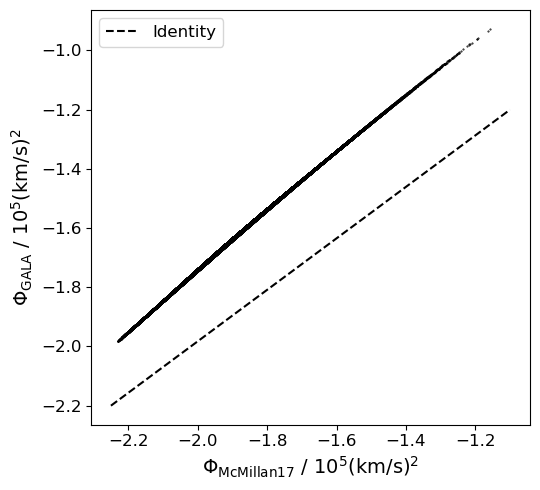

In [7]:
# energy using standard GALA potential (Hernquist bulge, Miyamoto-Nagai disk, NFW halo)
# model parameters (from Naidu et al. 2020)
M_halo=5.4*10**11*u.Msun
a_h=15620*u.pc
G=4.3*10**(-3)*u.pc/u.Msun*(u.km/u.s)**2
M_disk=6.8*10**10*u.Msun
a_d=3000*u.pc
b_d=280*u.pc
M_bulge=0.67*10**10*u.Msun
c_b=1000*u.pc

usys1=UnitSystem(u.pc,u.Myr,u.Msun,u.degree)
usys2=UnitSystem(u.km,u.s,u.kg,u.degree)
mwp=gp.MilkyWayPotential(disk={'m':M_disk,'a':a_d,'b':b_d},bulge={'m':M_bulge,'c':c_b},halo={'m':M_halo,'r_s':a_h},units=usys1)
phi_gala=mwp.energy([np.transpose(r_gc)[0],np.transpose(r_gc)[1],np.transpose(r_gc)[2]]).decompose(usys2)
orb_E_gala = v_tot**2/2 + phi_gala

# potential and energy of Sun
phi_gala_sun=mwp.energy([np.array(-r_gc_sun[0]),np.array(r_gc_sun[1]),np.array(r_gc_sun[2])]).decompose(usys2)
orb_E_gala_sun = np.array(v_gc_sun.dot(v_gc_sun))/2 + np.array(phi_gala_sun)

def lin(x,a,b):
    return a*x+b

fig=plt.figure(figsize=(5.5,5))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
#density = ax.scatter_density(np.array(Phi_MM17[pot_nan])/10**5,np.array(phi_gala[pot_nan])/10**5, cmap=white_viridis)
#fig.colorbar(density, label='Number of stars per pixel')
plt.scatter(np.array(Phi_MM17)/10**5,np.array(phi_gala)/10**5,s=0.2,color='black')
plt.plot(np.linspace(-2.25,-1.1,10),lin(np.linspace(-2.2,-1.2,10),1,0),label='Identity',color='black',ls='dashed')
plt.xlabel('$\Phi_\mathrm{McMillan17}$ / $10^5$(km/s)$^2$',size=14)
plt.ylabel('$\Phi_\mathrm{GALA}$ / $10^5$(km/s)$^2$',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('figures/5_04_pot_comp.png',format='png')  

In [8]:
############## DO NOT UNCOMMENT ###############
## save table including kinematic properties for future convenience and crossmatch etc
#kin_ana = Table([source,ra_rv,dec_rv,Gmag_rv,BP_rv,RP_rv,paral_rv,paral0_rv,paral_e_rv,pmra,pmra_e,pmdec,pmdec_e,rad_vel_gaia,rad_vel_gaia_e,rad_vel_galah,rad_vel_galah_e,rad_vel_apo,rad_vel_apo_e,rad_vel_rave,rad_vel_rave_e,feh,ruwe,bprp_excess,dist_rv,np.transpose(r_gc)[0],np.transpose(r_gc)[1],z,np.transpose(v_gc)[0],np.transpose(v_gc)[1],np.transpose(v_gc)[2],rad,R,v_tot,v_zx,L_z,L_perp,cond_v,cond_z,Phi_MM17,orb_E_MM17,lamb_z,lamb_z2,cond_halo,phi_gala,orb_E_gala,bprp0_rv,M_G_rv,A_G_rv],names=('sourceid','ra','dec','gaiag','gaiabp','gaiarp','parallax','parallax0','parallax_error','pmra','pmra_error','pmdec','pmdec_error','radial_velocity','radial_velocity_error','rv_galah','rv_galah_e','rv_apogee','rv_apogee_e','rv_rave','rv_rave_e','FeHphot_gen','ruwe','phot_bp_rp_excess_factor','distance','x_gc','y_gc','z_gc','vx_gc','vy_gc','vz_gc','rad_gc','R_gc','v_tot','vzx_gc','L_z','L_perp','cond_v','cond_z','Phi_MM17','orb_E_MM17','lamb_z','lamb_z2','cond_halo','phi_gala','orb_E_gala','bp_rp0','M_G','A_G'))
#kin_ana.write('data/kinematic_analysis.csv',delimiter=',',format='ascii',overwrite=True)
############## DO NOT UNCOMMENT ###############

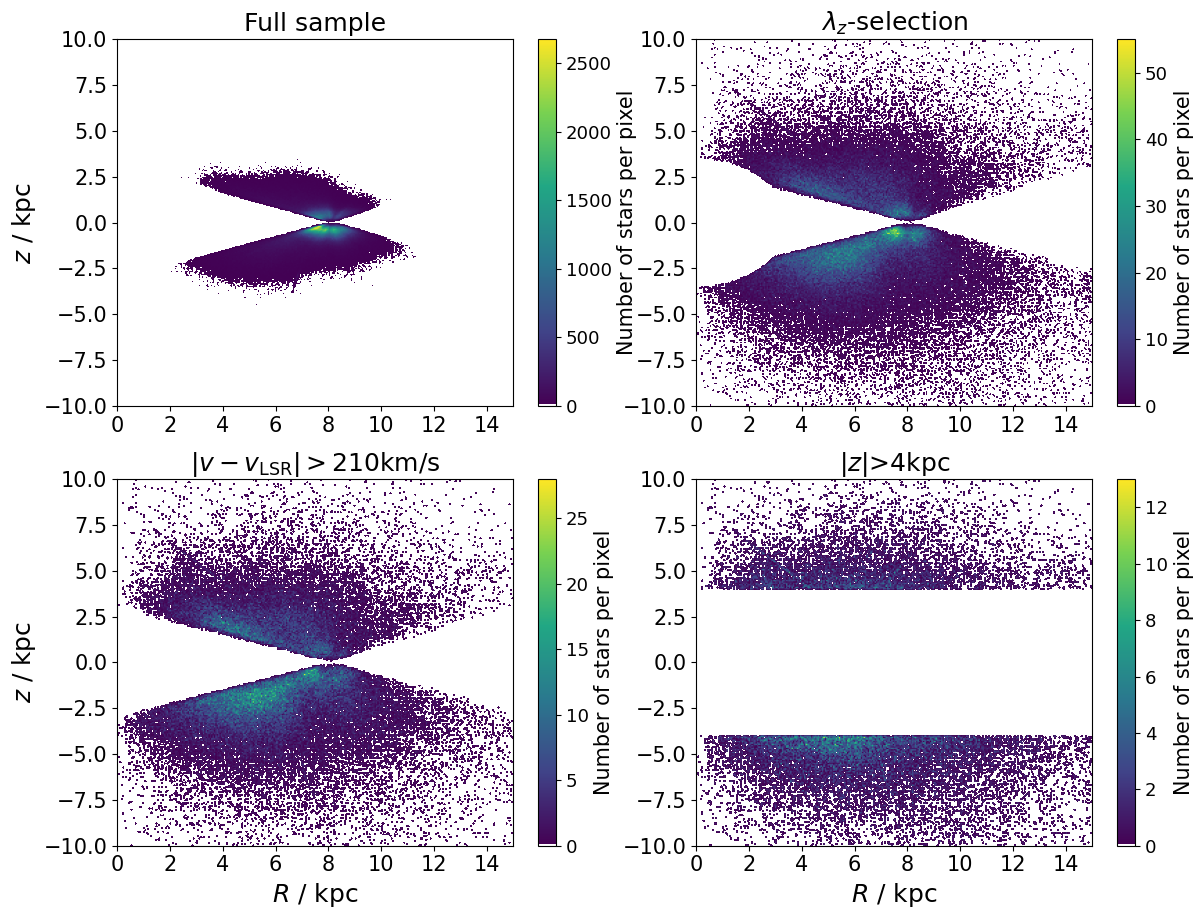

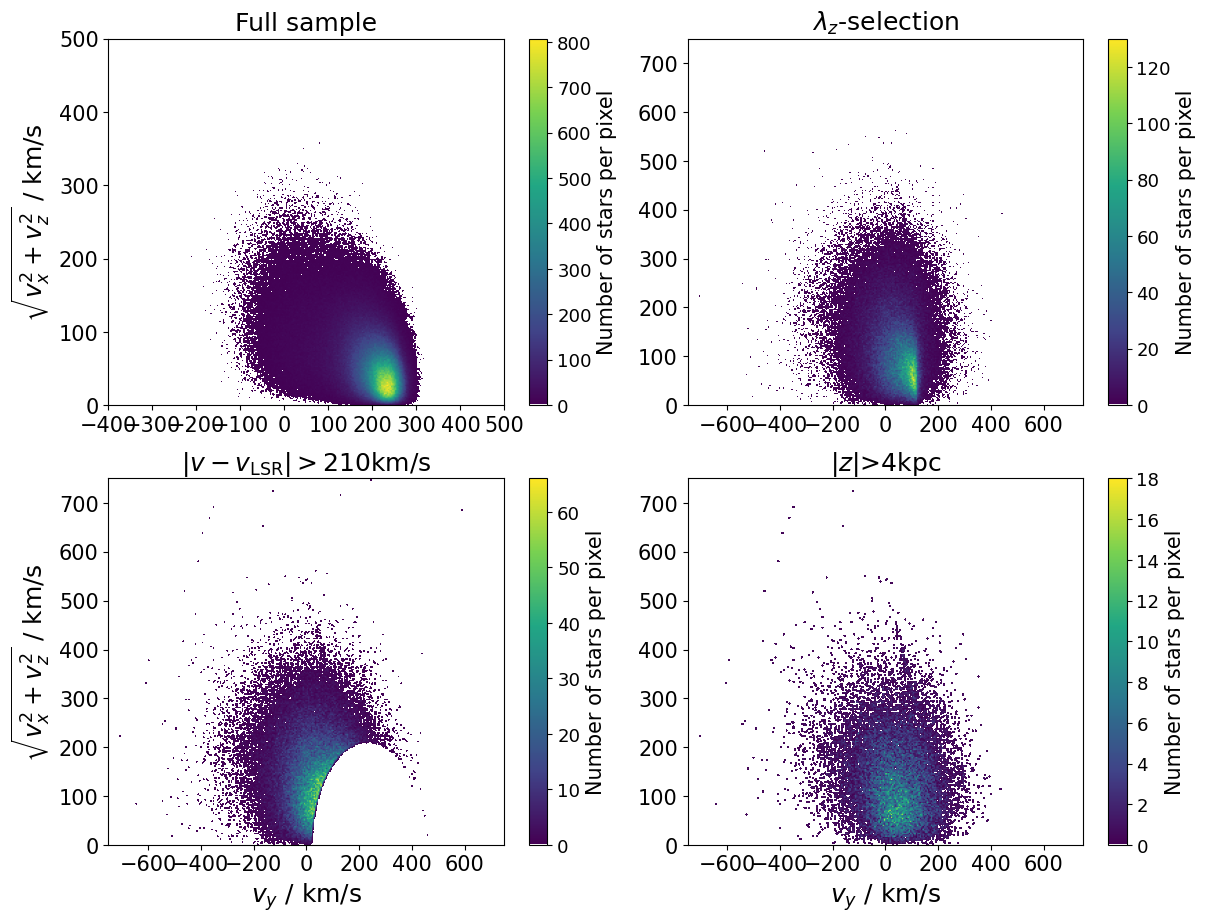

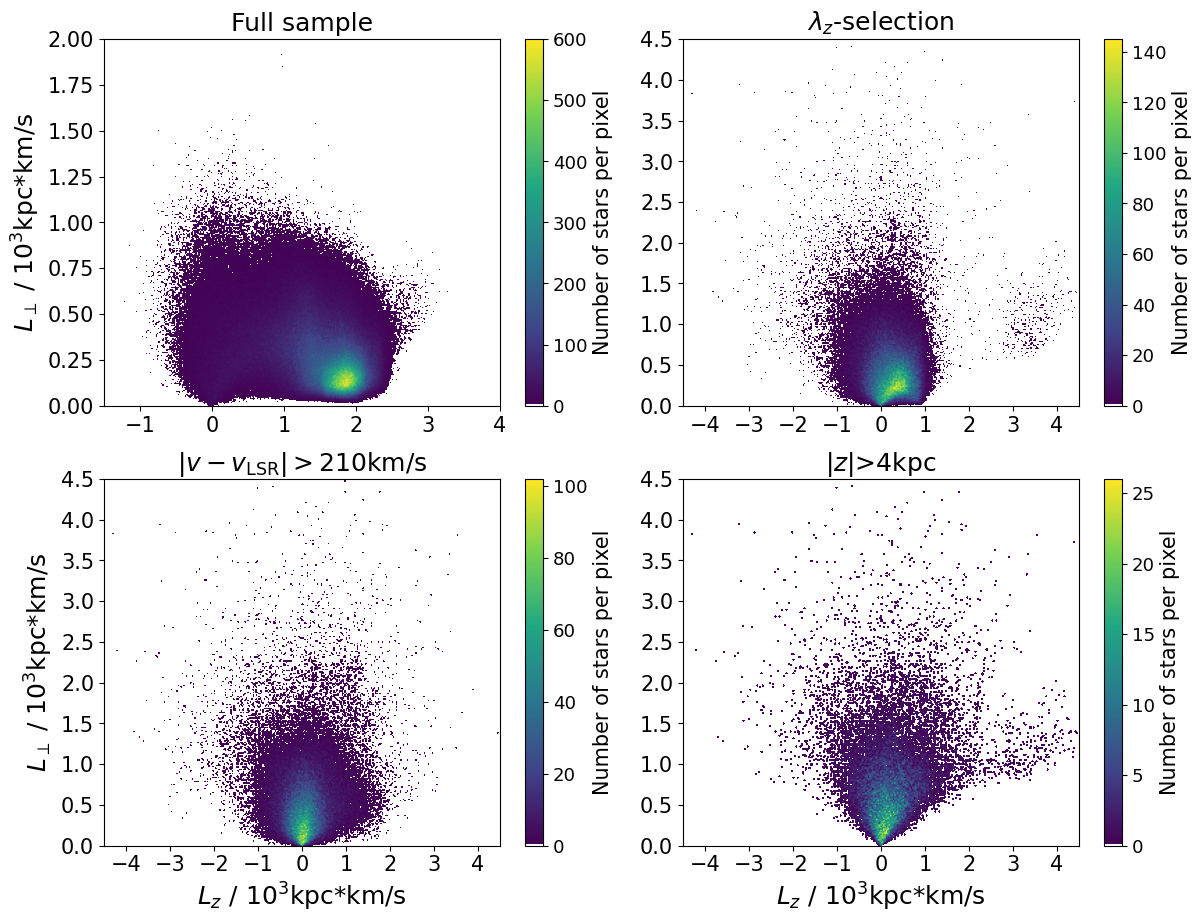

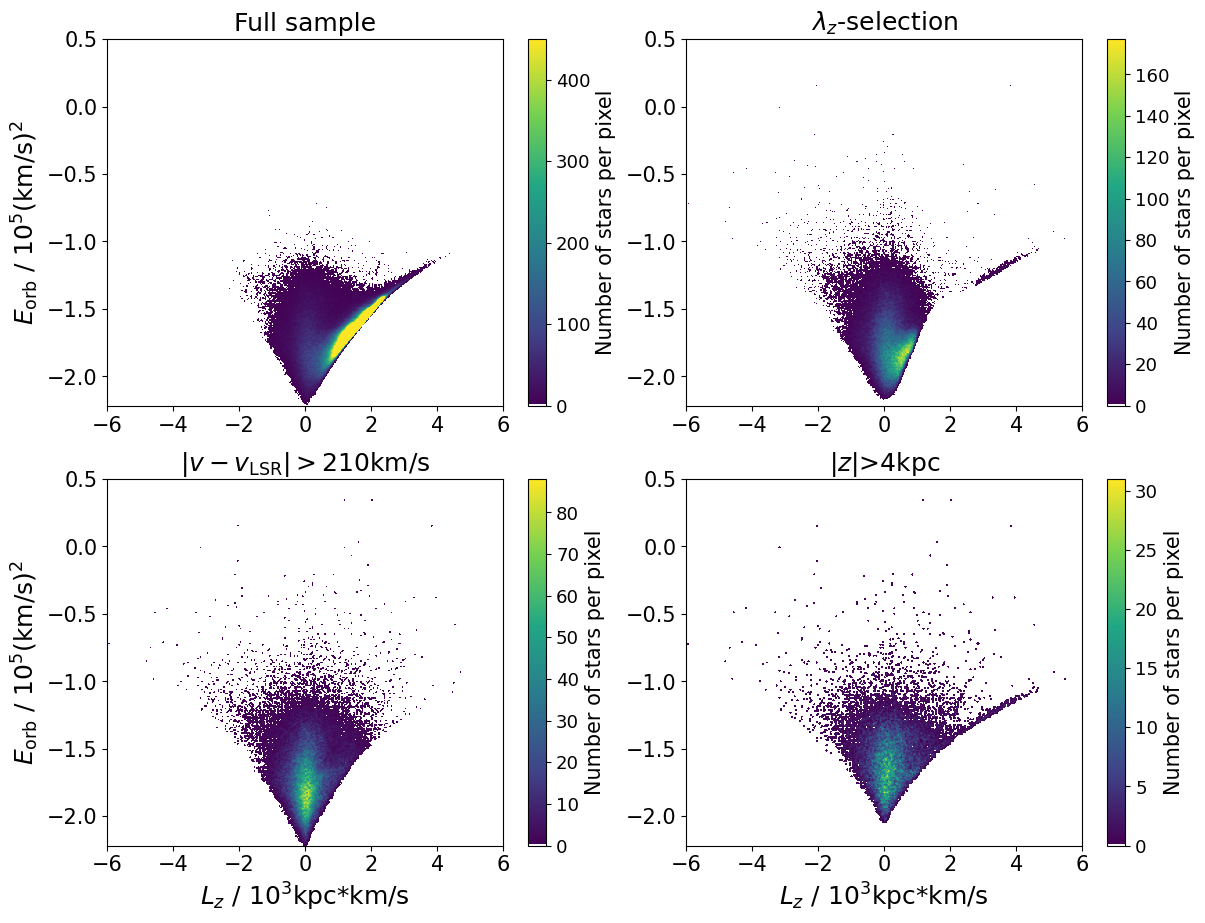

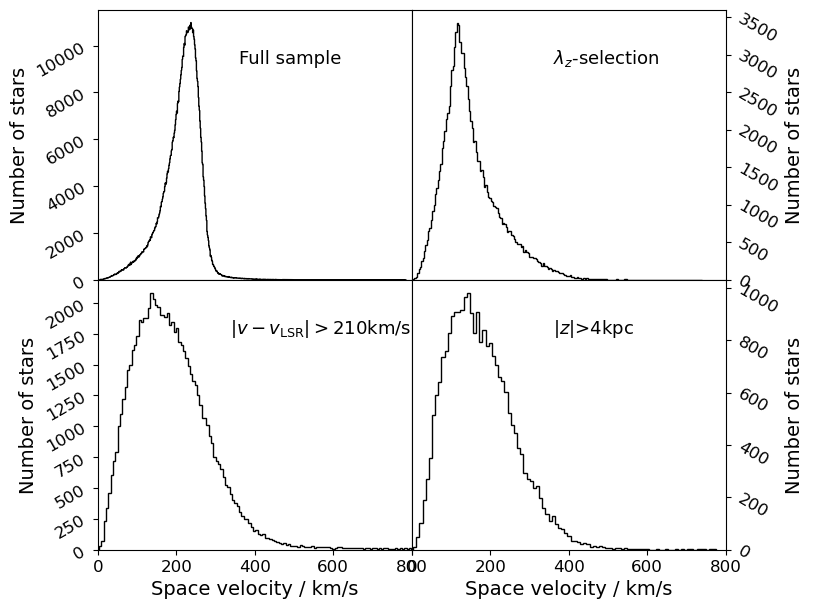

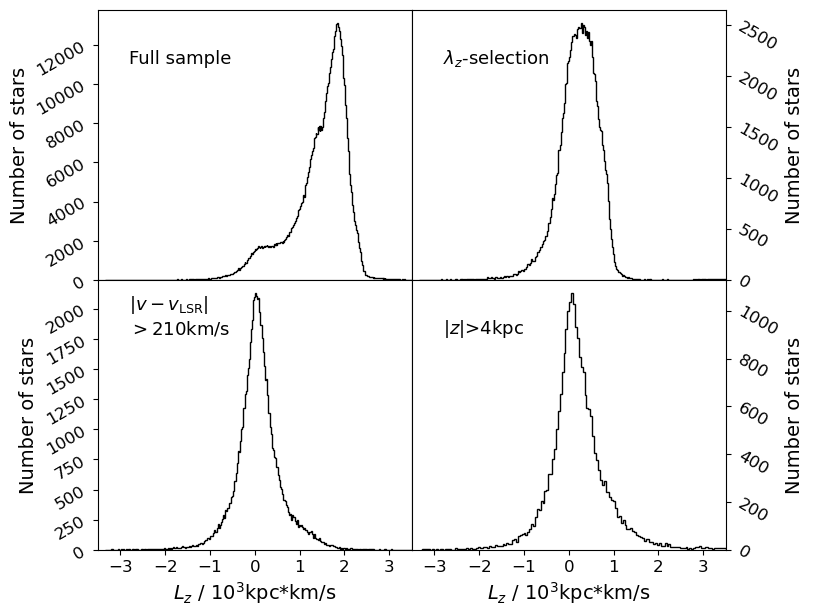

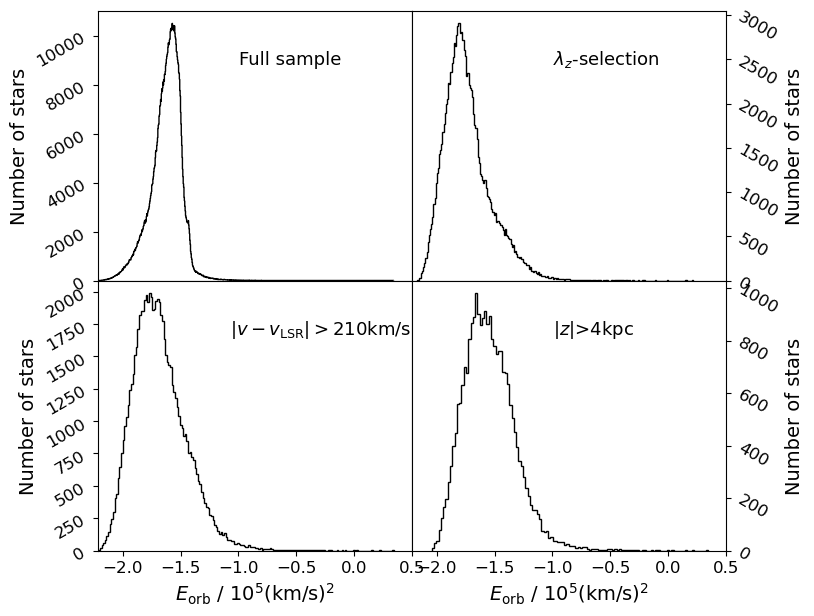

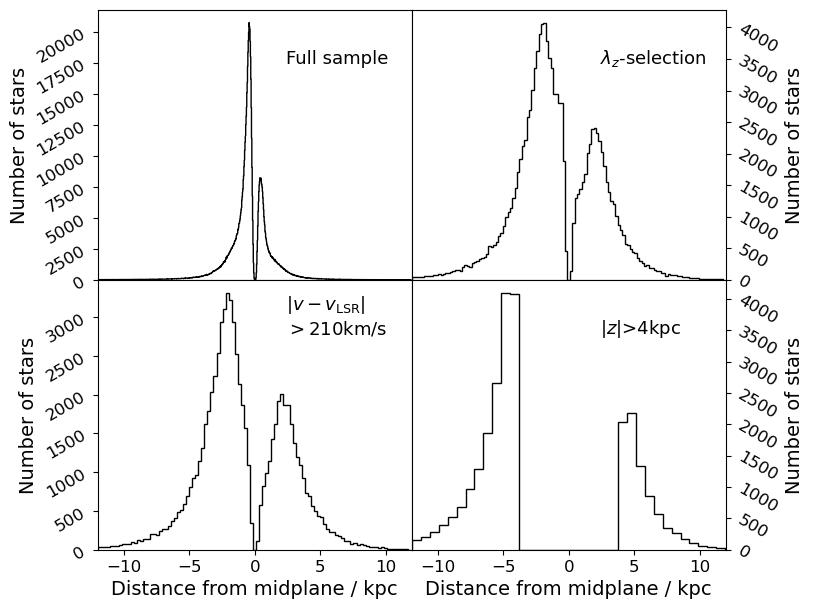

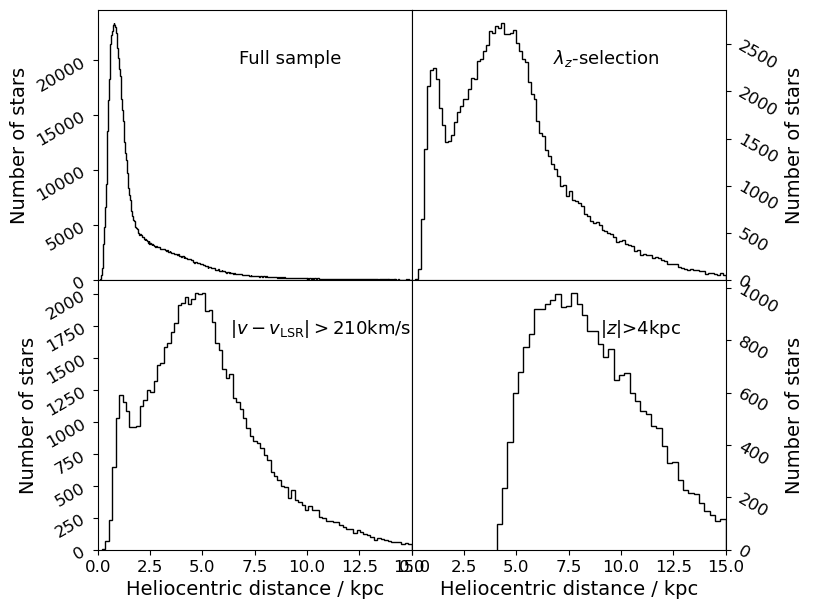

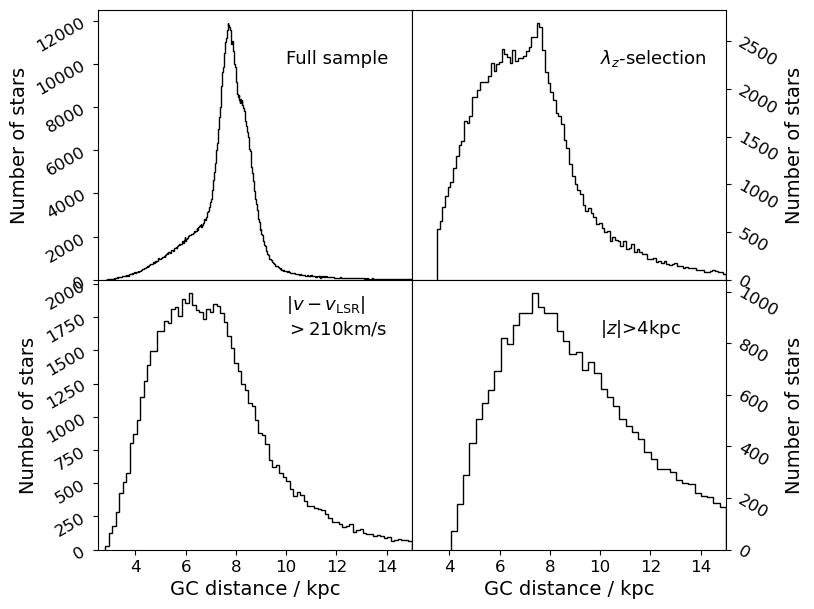

In [9]:
# decide on potential to use
orb_E=orb_E_MM17

# define plotting routines to do all plots
def scatter_plots(fig,quanx,quany,pos,cond,info,xll,xlu,yll,ylu,xlab,ylab,vm):
    ax = fig.add_subplot(2, 2, pos, projection='scatter_density')
    density = ax.scatter_density(np.array(quanx[cond & cond_ana & (np.isnan(R)==False)]),np.array(quany[cond & cond_ana & (np.isnan(R)==False)]), cmap=white_viridis,vmax=vm)
    cb=fig.colorbar(density)
    cb.set_label(label='Number of stars per pixel',size=15)
    cb.ax.tick_params(labelsize=13)
    plt.xlim(xll,xlu)
    plt.ylim(yll,ylu)
    plt.xlabel(xlab,size=18)
    plt.ylabel(ylab,size=18)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.title(info,size=18)
    plt.subplots_adjust(wspace=0.17,hspace=0.2,left=0.09,right=0.985,bottom=0.072,top=0.968)
    
# carry out plots
# Spatial distribution of sample in different cuts
fig1=plt.figure(figsize=(12,9))
scatter_plots(fig1,R/1000,z/1000,1,cond_e,'Full sample',0,15,-10,10,None,'$z$ / kpc',None)
scatter_plots(fig1,R/1000,z/1000,2,cond_halo,'$\lambda_z$-selection',0,15,-10,10,None,None,None)
scatter_plots(fig1,R/1000,z/1000,3,cond_v,'$|v-v_{\mathrm{LSR}}|>210$km/s',0,15,-10,10,'$R$ / kpc','$z$ / kpc',None)
scatter_plots(fig1,R/1000,z/1000,4,cond_z,'$|z|$>4kpc',0,15,-10,10,'$R$ / kpc',None,None)
plt.savefig('figures/5_05_kinsample_spatdistr.png',format='png')  

# v_perp vs. v_y in GC coordinates
fig2=plt.figure(figsize=(12,9))
scatter_plots(fig2,np.transpose(v_gc)[1],v_zx,1,cond_e & (np.isnan(v_zx)==False),'Full sample',-400,500,0,500,None,'$\sqrt{v_x^2+v_z^2}$ / km/s',None)
scatter_plots(fig2,np.transpose(v_gc)[1],v_zx,2,cond_halo & (np.isnan(v_zx)==False),'$\lambda_z$-selection',-750,750,0,750,None,None,None)
scatter_plots(fig2,np.transpose(v_gc)[1],v_zx,3,cond_v & (np.isnan(v_zx)==False),'$|v-v_{\mathrm{LSR}}|>210$km/s',-750,750,0,750,'$v_y$ / km/s','$\sqrt{v_x^2+v_z^2}$ / km/s',None)
scatter_plots(fig2,np.transpose(v_gc)[1],v_zx,4,cond_z & (np.isnan(v_zx)==False),'$|z|$>4kpc',-750,750,0,750,'$v_y$ / km/s',None,None)
plt.savefig('figures/5_06_vperp_vy.png',format='png')  

# Specific L_perp vs L_z
fig3=plt.figure(figsize=(12,9))
scatter_plots(fig3,L_z/1000000,L_perp/1000000,1,cond_e & (np.isnan(v_zx)==False),'Full sample',-1.5,4,0,2,None,'$L_{\perp}$ / $10^3$kpc*km/s',None)
scatter_plots(fig3,L_z/1000000,L_perp/1000000,2,cond_halo & (np.isnan(v_zx)==False),'$\lambda_z$-selection',-4.5,4.5,0,4.5,None,None,None)
scatter_plots(fig3,L_z/1000000,L_perp/1000000,3,cond_v & (np.isnan(v_zx)==False),'$|v-v_{\mathrm{LSR}}|>210$km/s',-4.5,4.5,0,4.5,'$L_z$ / $10^3$kpc*km/s','$L_{\perp}$ / $10^3$kpc*km/s',None)
scatter_plots(fig3,L_z/1000000,L_perp/1000000,4,cond_z & (np.isnan(v_zx)==False),'$|z|$>4kpc',-4.5,4.5,0,4.5,'$L_z$ / $10^3$kpc*km/s',None,None)
plt.savefig('figures/5_07_Lperp_Lz.png',format='png')  

# Orbital energy vs. angular momentum z-component
fig4=plt.figure(figsize=(12,9))
scatter_plots(fig4,L_z/1000000,orb_E/100000,1,cond_e & (np.isnan(v_zx)==False),'Full sample',-6,6,np.array(np.nanmin(orb_E))/100000,0.5,None,'$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',450)
scatter_plots(fig4,L_z/1000000,orb_E/100000,2,cond_halo & (np.isnan(v_zx)==False),'$\lambda_z$-selection',-6,6,np.array(np.nanmin(orb_E))/100000,0.5,None,None,None)
scatter_plots(fig4,L_z/1000000,orb_E/100000,3,cond_v & (np.isnan(v_zx)==False),'$|v-v_{\mathrm{LSR}}|>210$km/s',-6,6,np.array(np.nanmin(orb_E))/100000,0.5,'$L_z$ / $10^3$kpc*km/s','$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',None)
scatter_plots(fig4,L_z/1000000,orb_E/100000,4,cond_z & (np.isnan(v_zx)==False),'$|z|$>4kpc',-6,6,np.array(np.nanmin(orb_E))/100000,0.5,'$L_z$ / $10^3$kpc*km/s',None,None)
plt.savefig('figures/5_08_orbE_Lz.png',format='png')  

# also do some corresponding histograms
def histograms(fig,quan,pos,cond,info,xll,xlu,xlab,annot):
    ax = fig.add_subplot(2, 2, pos, projection='scatter_density')
    n, bins, patches=plt.hist(np.array(quan[cond & cond_ana & (np.array(quan)>xll) & (np.array(quan)<xlu)]),bins='auto',histtype='step', stacked=True, fill=False,color='black')
    if (pos==2) or (pos==4):
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        plt.tick_params(axis='y',labelrotation=330)
    if (pos==3) or (pos==4):
        plt.xlabel(xlab,size=14)
    if (pos==1) or (pos==2):
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    if (pos==1) or (pos==3):
        plt.tick_params(axis='y',labelrotation=30)
    plt.ylabel('Number of stars',size=14)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlim(xll,xlu)
    plt.annotate(info,size=13, xy=annot, xycoords='axes fraction')
    plt.subplots_adjust(hspace=0,wspace=0,left=0.115,right=0.9,bottom=0.09,top=0.99)

# Histogram of abs. space velocities v
fig1=plt.figure(figsize=(8,6))
histograms(fig1,v_tot,1,cond_e,'Full sample',0,800,'Space velocity / km/s',(0.45, 0.8))
histograms(fig1,v_tot,2,cond_halo,'$\lambda_z$-selection',0,800,'Space velocity / km/s',(0.45, 0.8))
histograms(fig1,v_tot,3,cond_v,'$|v-v_{\mathrm{LSR}}|>210$km/s',0,800,'Space velocity / km/s',(0.42, 0.8))
histograms(fig1,v_tot,4,cond_z,'$|z|$>4kpc',0,800,'Space velocity / km/s',(0.45, 0.8))
plt.savefig('figures/5_09_hist_vtot.png',format='png')  

# Histogram of ang. momenta L_z
fig2=plt.figure(figsize=(8,6))
histograms(fig2,L_z/1000000,1,cond_e,'Full sample',-3.5,3.5,'$L_z$ / $10^3$kpc*km/s',(0.1, 0.8))
histograms(fig2,L_z/1000000,2,cond_halo,'$\lambda_z$-selection',-3.5,3.5,'$L_z$ / $10^3$kpc*km/s',(0.1, 0.8))
histograms(fig2,L_z/1000000,3,cond_v,'$|v-v_{\mathrm{LSR}}|$\n$>210$km/s',-3.5,3.5,'$L_z$ / $10^3$kpc*km/s',(0.1, 0.8))
histograms(fig2,L_z/1000000,4,cond_z,'$|z|$>4kpc',-3.5,3.5,'$L_z$ / $10^3$kpc*km/s',(0.1, 0.8))
plt.savefig('figures/5_10_hist_Lz.png',format='png')

# Histogram of orbital energy E_orb
fig3=plt.figure(figsize=(8,6))
histograms(fig3,orb_E/100000,1,cond_e,'Full sample',np.array(np.nanmin(orb_E))/100000,0.5,'$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',(0.45, 0.8))
histograms(fig3,orb_E/100000,2,cond_halo,'$\lambda_z$-selection',np.array(np.nanmin(orb_E))/100000,0.5,'$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',(0.45, 0.8))
histograms(fig3,orb_E/100000,3,cond_v,'$|v-v_{\mathrm{LSR}}|>210$km/s',np.array(np.nanmin(orb_E))/100000,0.5,'$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',(0.42, 0.8))
histograms(fig3,orb_E/100000,4,cond_z,'$|z|$>4kpc',np.array(np.nanmin(orb_E))/100000,0.5,'$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',(0.45, 0.8))
plt.savefig('figures/5_11_hist_orbE.png',format='png')

# Histogram of distances from midplane (GC z-coordinate)
fig4=plt.figure(figsize=(8,6))
histograms(fig4,z/1000,1,cond_e,'Full sample',-12,12,'Distance from midplane / kpc',(0.6, 0.8))
histograms(fig4,z/1000,2,cond_halo,'$\lambda_z$-selection',-12,12,'Distance from midplane / kpc',(0.6, 0.8))
histograms(fig4,z/1000,3,cond_v,'$|v-v_{\mathrm{LSR}}|$\n$>210$km/s',-12,12,'Distance from midplane / kpc',(0.6, 0.8))
histograms(fig4,z/1000,4,cond_z,'$|z|$>4kpc',-12,12,'Distance from midplane / kpc',(0.6, 0.8))
plt.savefig('figures/5_12c_hist_gcz.png',format='png')

# Histogram of heliocentric distances
fig5=plt.figure(figsize=(8,6))
histograms(fig5,dist_rv/1000,1,cond_e,'Full sample',0,15,'Heliocentric distance / kpc',(0.45, 0.8))
histograms(fig5,dist_rv/1000,2,cond_halo,'$\lambda_z$-selection',0,15,'Heliocentric distance / kpc',(0.45, 0.8))
histograms(fig5,dist_rv/1000,3,cond_v,'$|v-v_{\mathrm{LSR}}|>210$km/s',0,15,'Heliocentric distance / kpc',(0.42, 0.8))
histograms(fig5,dist_rv/1000,4,cond_z,'$|z|$>4kpc',0,15,'Heliocentric distance / kpc',(0.6, 0.8))
plt.savefig('figures/5_12a_hist_heliodist.png',format='png')

# Histogram of GC distances
fig6=plt.figure(figsize=(8,6))
histograms(fig6,np.sqrt(R**2+z**2)/1000,1,cond_e,'Full sample',2.5,15,'GC distance / kpc',(0.6, 0.8))
histograms(fig6,np.sqrt(R**2+z**2)/1000,2,cond_halo,'$\lambda_z$-selection',2.5,15,'GC distance / kpc',(0.6, 0.8))
histograms(fig6,np.sqrt(R**2+z**2)/1000,3,cond_v,'$|v-v_{\mathrm{LSR}}|$\n$>210$km/s',2.5,15,'GC distance / kpc',(0.6, 0.8))
histograms(fig6,np.sqrt(R**2+z**2)/1000,4,cond_z,'$|z|$>4kpc',2.5,15,'GC distance / kpc',(0.6, 0.8))
plt.savefig('figures/5_12b_hist_gcdist.png',format='png')

## 5.3. Halo selection verification: number density distribution, metallicity distribution, kinematic cuts

/tmp/ipykernel_8260/2263739465.py:34: RuntimeWarning: divide by zero encountered in log
  return n0-np.log(r)*alpha

/tmp/ipykernel_8260/2263739465.py:38: RuntimeWarning: divide by zero encountered in log
  nu[r<R0]=n0+(np.log(R0)-np.log(r[r<R0]))*alpha


For halo selection via circularity parameter:
Residual sum of squares of SPL fit: 9.806895163070015
Residual sum of squares of BPL fit: 9.697506452214055
R-squared of SPL fit: 0.9821316528453758
R-squared of BPL fit: 0.9823309611308086
For halo selection via |v-v_LSR|>210km/s:
Residual sum of squares of SPL fit: 14.966230720675096
Residual sum of squares of BPL fit: 12.774640548838127
R-squared of SPL fit: 0.9730880030069676
R-squared of BPL fit: 0.9770288795853942


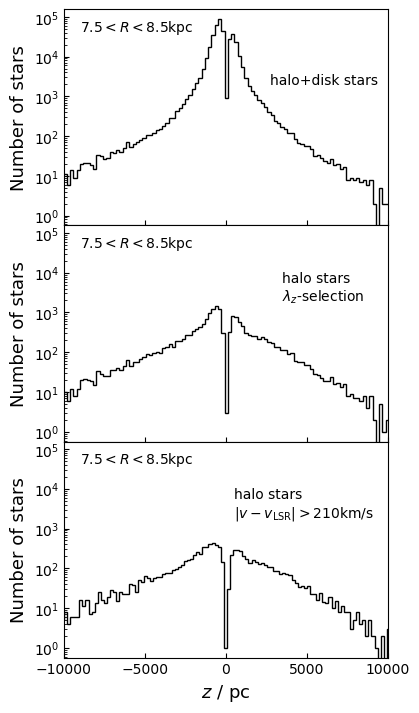

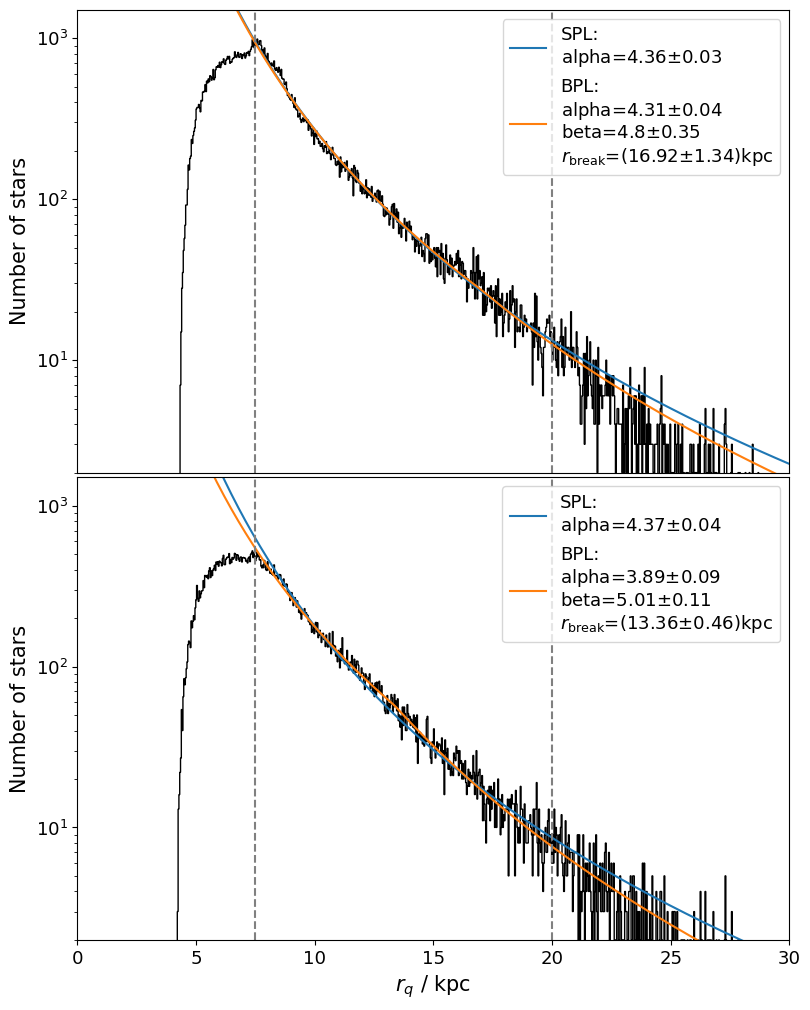

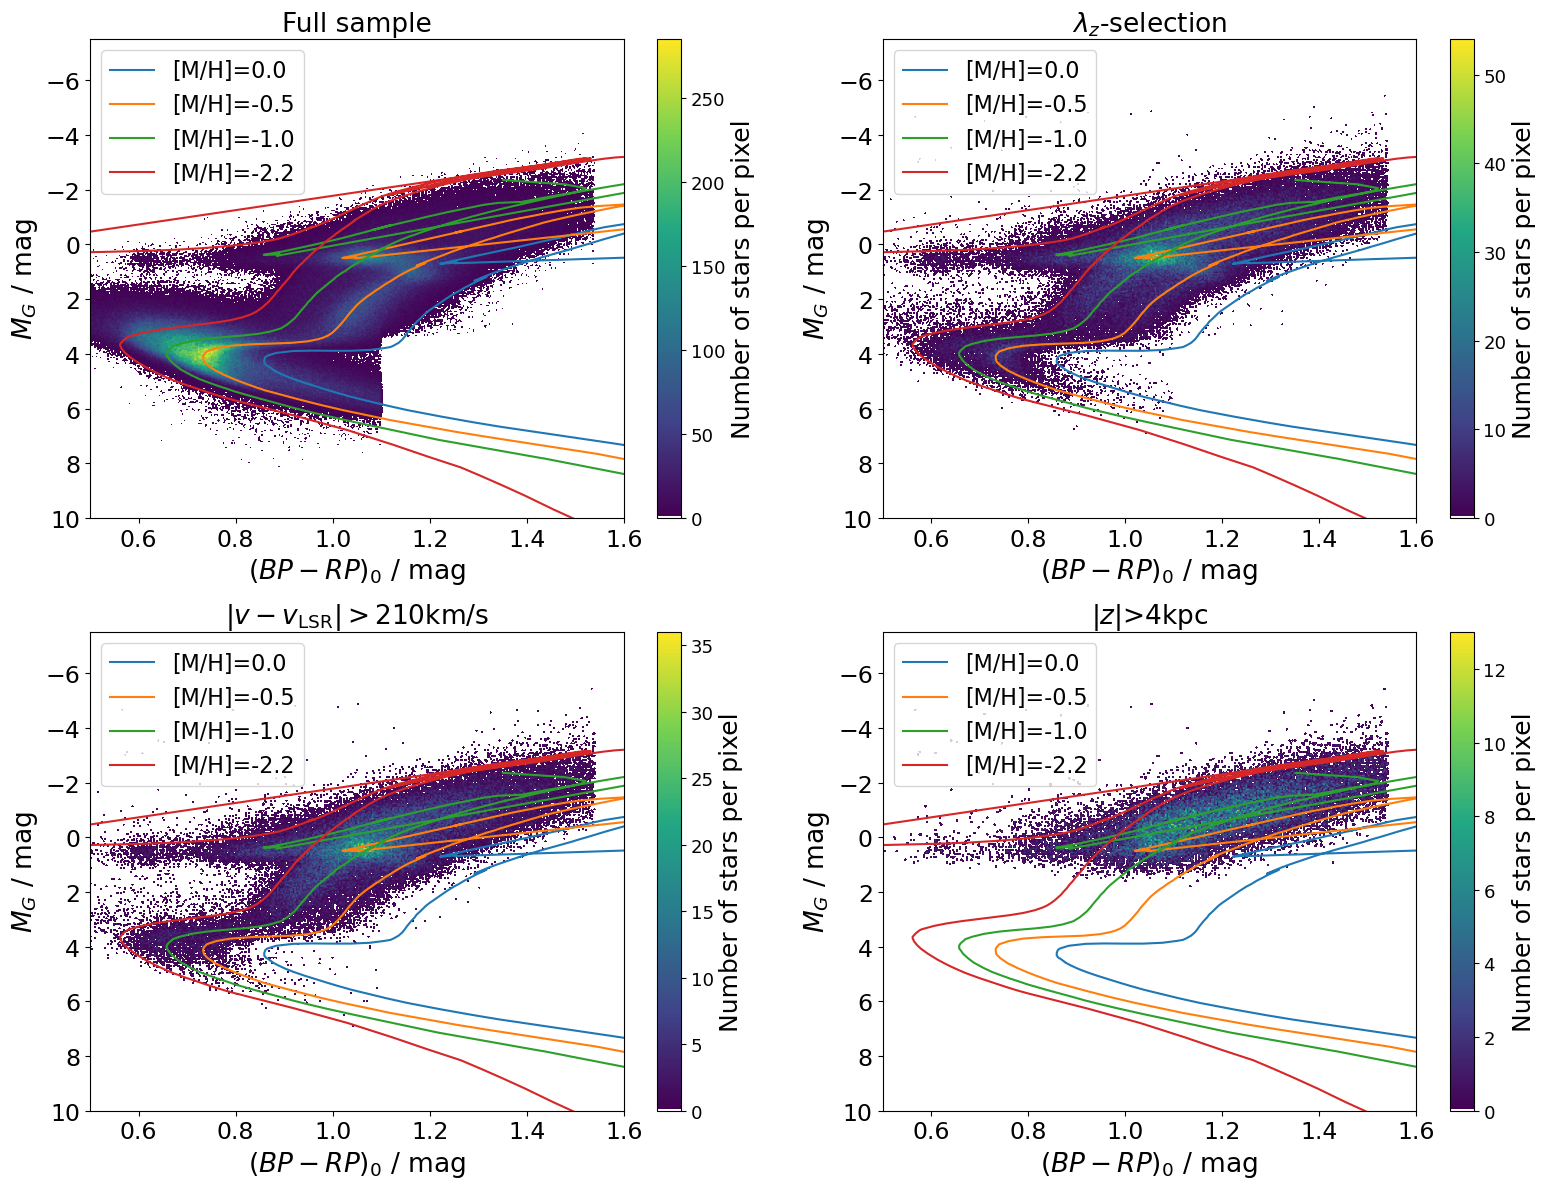

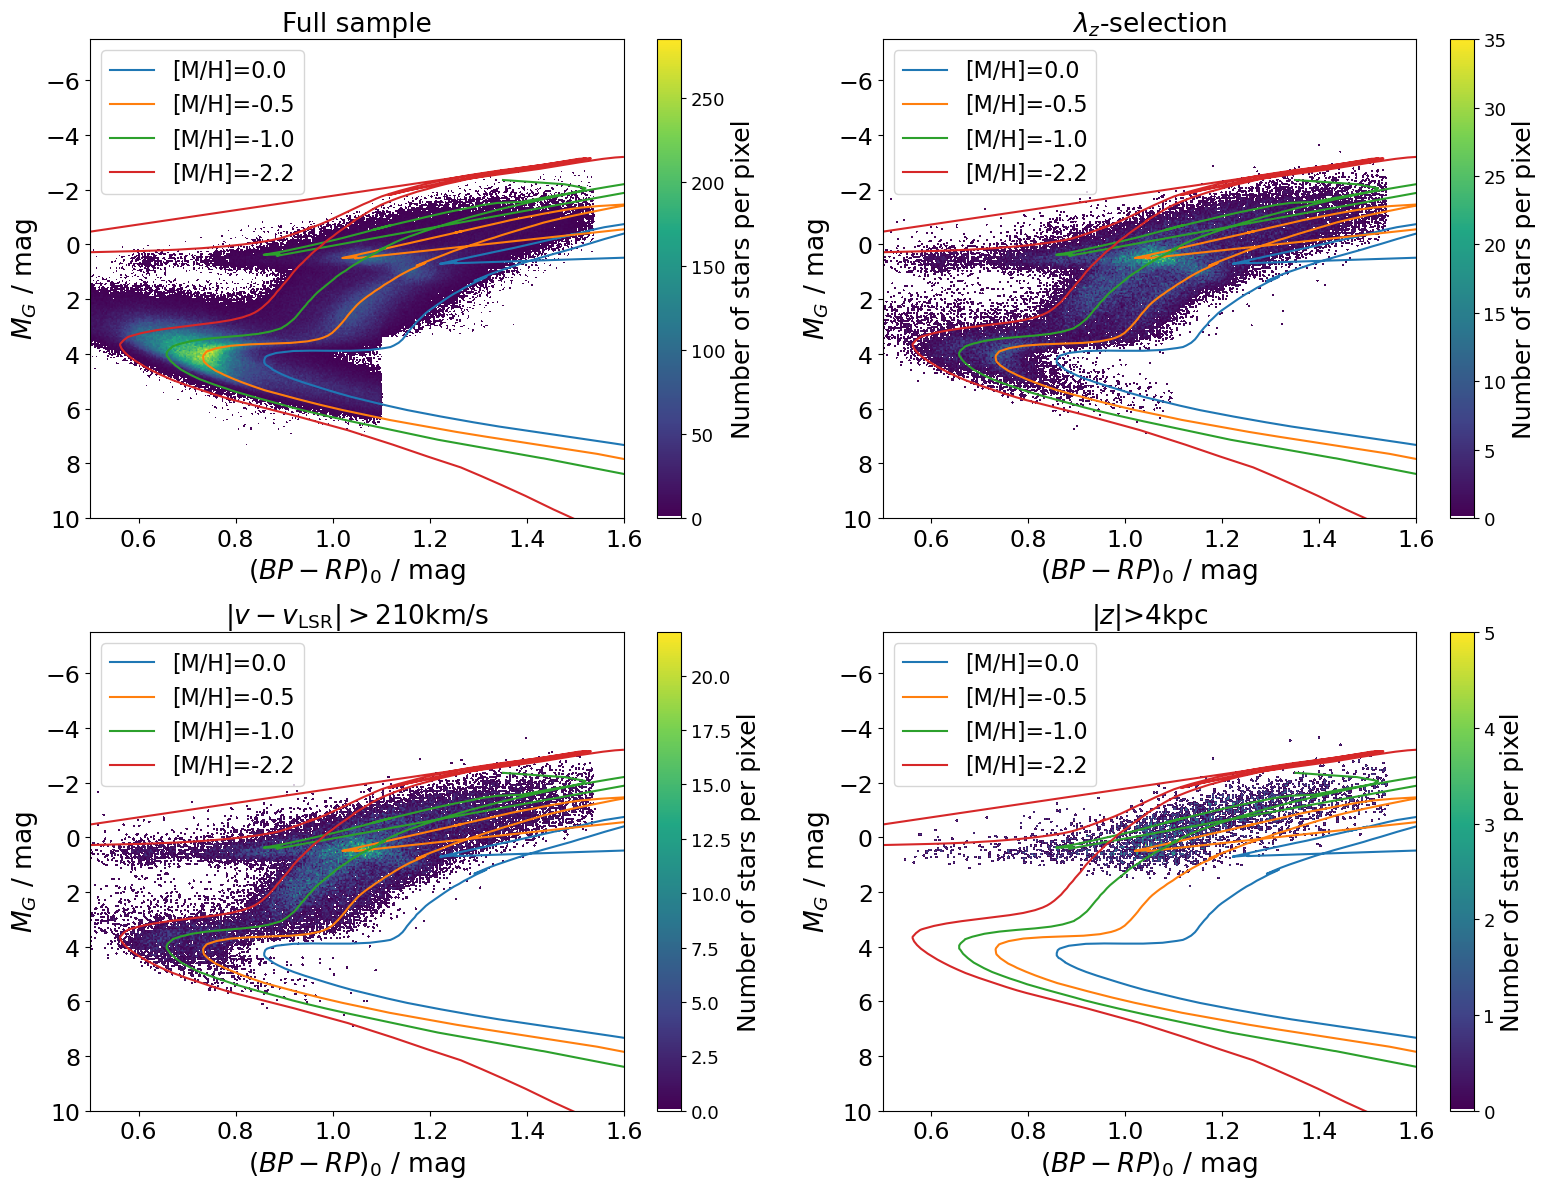

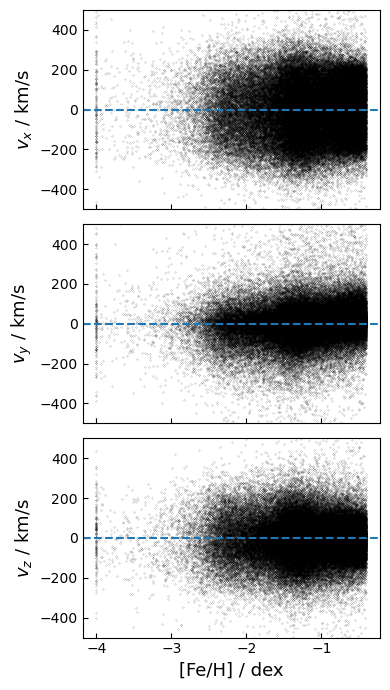

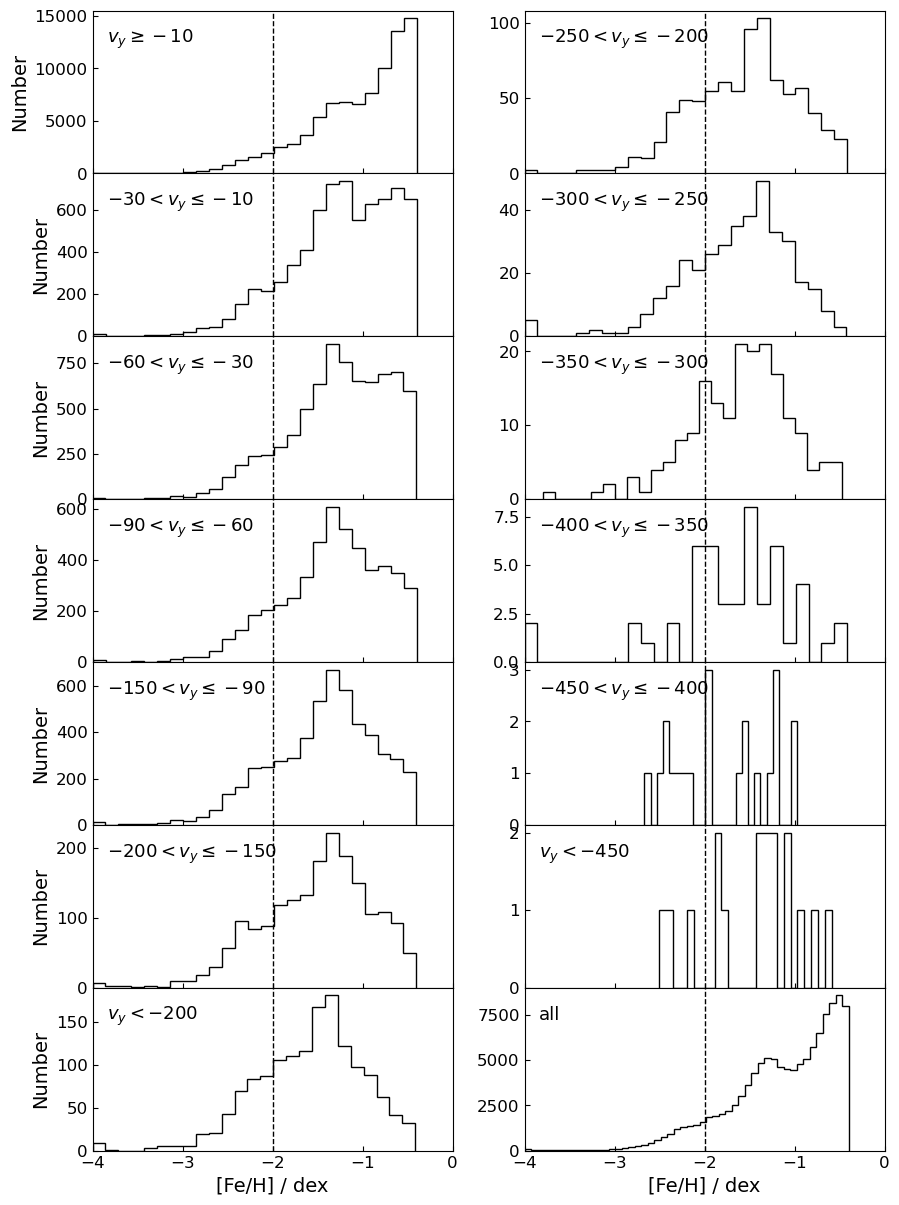

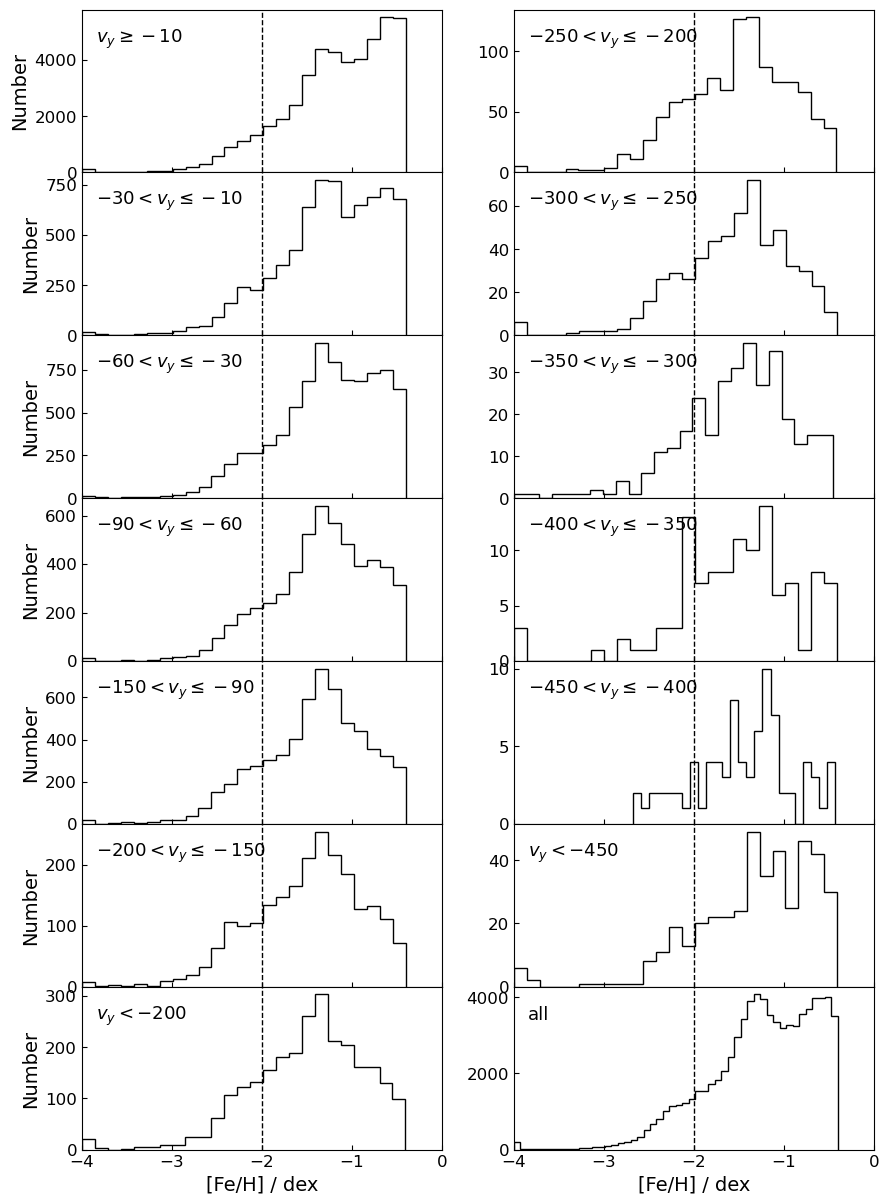

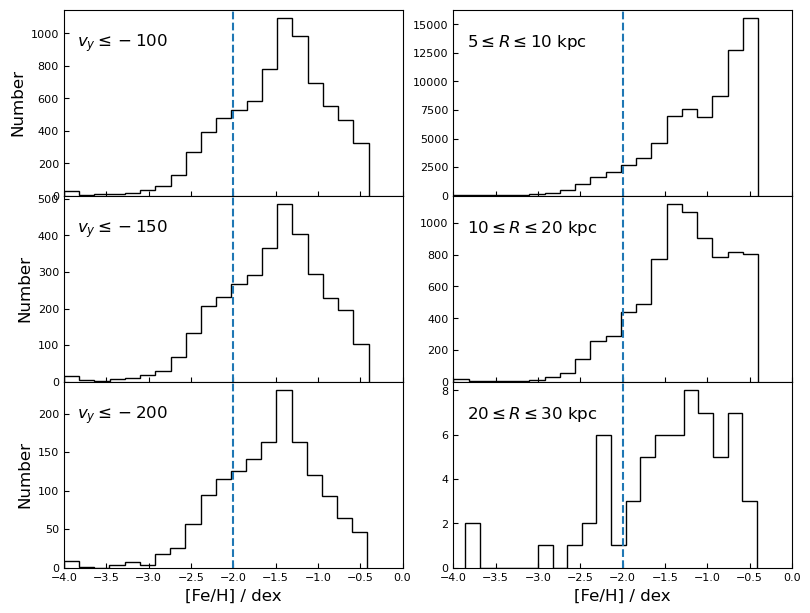

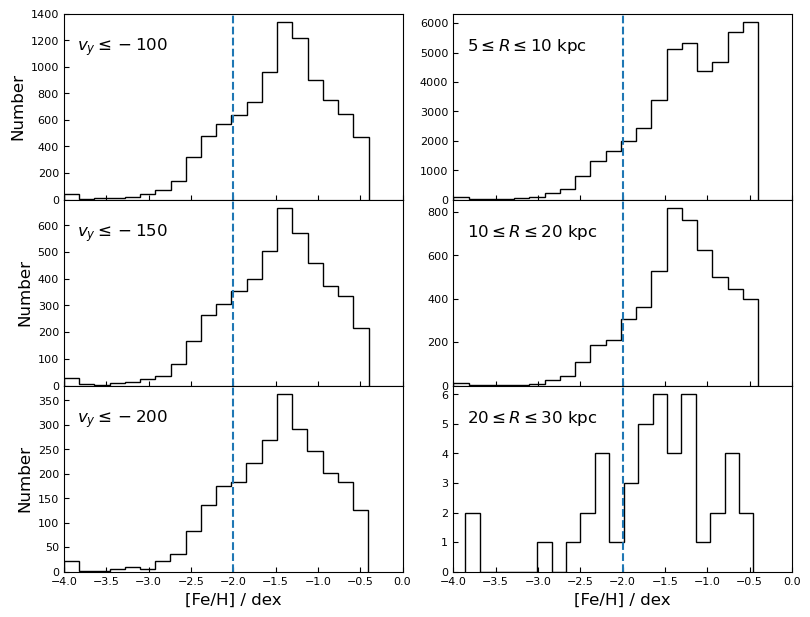

In [10]:
# compare distribution of distances from midplane around R=8kpc and compare with Juric et al. (2008), Figure 33
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(4,7),sharex=True,sharey=True)
axs[0].hist(np.array(z[(R>7500*u.pc) & (R<8500*u.pc)]),bins=150,histtype='step', stacked=True, fill=False,color='black')
axs[0].set_yscale('log')
axs[0].set_xlim(-10000,10000)
axs[0].text(2700,2000,'halo+disk stars',size=10)
axs[0].annotate('$7.5<R<8.5$kpc',size=10, xy=(0.05,0.9), xycoords='axes fraction')
axs[0].set_ylabel('Number of stars',size=13)
axs[0].tick_params(axis='both',direction='in',which='both')
axs[1].hist(np.array(z[cond_halo & (R>7500*u.pc) & (R<8500*u.pc)]),bins=150,histtype='step', stacked=True, fill=False,color='black')
axs[1].set_yscale('log')
axs[1].set_xlim(-10000,10000)
axs[1].text(3500,2000,'halo stars\n$\lambda_z$-selection',size=10)
axs[1].annotate('$7.5<R<8.5$kpc',size=10, xy=(0.05,0.9), xycoords='axes fraction')
axs[1].set_xlabel('$z$ / pc',size=13)
axs[1].set_ylabel('Number of stars',size=13)
axs[1].tick_params(axis='both',direction='in',which='both')
axs[2].hist(np.array(z[cond_v & (R>7500*u.pc) & (R<8500*u.pc)]),bins=150,histtype='step', stacked=True, fill=False,color='black')
axs[2].set_yscale('log')
axs[2].set_xlim(-10000,10000)
axs[2].text(500,2000,'halo stars\n$|v-v_{\mathrm{LSR}}|>210$km/s',size=10)
axs[2].annotate('$7.5<R<8.5$kpc',size=10, xy=(0.05,0.9), xycoords='axes fraction')
axs[2].set_xlabel('$z$ / pc',size=13)
axs[2].set_ylabel('Number of stars',size=13)
axs[2].tick_params(axis='both',direction='in',which='both')
plt.subplots_adjust(hspace=0,left=0.14,bottom=0.064,top=0.99,right=0.95)
plt.savefig('figures/5_13_dist_midplane.png',format='png')

# fit power-laws to GC distances
q=0.6 # flattening parameter chosen 0.6 based on typical values I saw in the literature
r_q=np.array(np.sqrt(R**2+(z/q)**2))/1000

def SPL(r,n0,alpha):
    return n0-np.log(r)*alpha

def BPL(r,n0,alpha,beta,R0):
    nu=np.empty([len(r)])
    nu[r<R0]=n0+(np.log(R0)-np.log(r[r<R0]))*alpha
    nu[r>R0]=n0+(np.log(R0)-np.log(r[r>R0]))*beta
    return nu

fig1=plt.figure(figsize=(8,10))
ax = fig1.add_subplot(2,1,1)
n,bins,patches=plt.hist(np.array(r_q[cond_halo]),log=True,bins=1000,histtype='step', stacked=True, fill=False,color='black')
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
fitrange = (binscenters>=7.5) & (binscenters<=20)
poptspl,pcovspl=curve_fit(SPL,binscenters[fitrange],np.log(n[fitrange]),p0=[10,3])
poptbpl,pcovbpl=curve_fit(BPL,binscenters[fitrange],np.log(n[fitrange]),p0=[10,2.5,5,15])
plt.plot(np.linspace(0,30,200),np.exp(SPL(np.linspace(0,30,200),poptspl[0],poptspl[1])),label='SPL:\nalpha='+str(round(poptspl[1],2))+'$\pm$'+str(round(np.sqrt(pcovspl[1][1]),2)))
plt.plot(np.linspace(0,30,200),np.exp(BPL(np.linspace(0,30,200),poptbpl[0],poptbpl[1],poptbpl[2],poptbpl[3])),label='BPL:\nalpha='+str(round(poptbpl[1],2))+'$\pm$'+str(round(np.sqrt(pcovbpl[1][1]),2))+'\nbeta='+str(round(poptbpl[2],2))+'$\pm$'+str(round(np.sqrt(pcovbpl[2][2]),2))+'\n$r_\mathrm{break}$=('+str(round(poptbpl[3],2))+'$\pm$'+str(round(np.sqrt(pcovbpl[3][3]),2))+')kpc')
plt.axvline(7.5,ls='dashed',color='grey')
plt.axvline(20,ls='dashed',color='grey')
plt.xlim(0,30)
plt.ylim(2,1500)
plt.yticks(size=13)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel('Number of stars',size=15)
plt.legend(fontsize=13,loc='upper right')

print('\nFor halo selection via circularity parameter:')
y_mean = np.mean(np.log(n[fitrange]))
ss_total = np.sum((np.log(n[fitrange]) - y_mean) ** 2)
ss_residual_spl = np.sum((np.log(n[fitrange]) - SPL(binscenters[fitrange], poptspl[0],poptspl[1])) ** 2)
r_squared_spl = 1 - (ss_residual_spl / ss_total)
ss_residual_bpl = np.sum((np.log(n[fitrange]) - BPL(binscenters[fitrange], poptbpl[0],poptbpl[1],poptbpl[2],poptbpl[3])) ** 2)
r_squared_bpl = 1 - (ss_residual_bpl / ss_total)
print('Residual sum of squares of SPL fit:',ss_residual_spl)
print('Residual sum of squares of BPL fit:',ss_residual_bpl)
print("R-squared of SPL fit:", r_squared_spl)
print("R-squared of BPL fit:", r_squared_bpl)

ax = fig1.add_subplot(2,1,2)
n,bins,patches=plt.hist(np.array(r_q[cond_v]),log=True,bins=1000,histtype='step', stacked=True, fill=False,color='black')
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
fitrange = (binscenters>=7.5) & (binscenters<=20)
poptspl,pcovspl=curve_fit(SPL,binscenters[fitrange],np.log(n[fitrange]),p0=[10,3])
poptbpl,pcovbpl=curve_fit(BPL,binscenters[fitrange],np.log(n[fitrange]),p0=[10,2.5,5,15])
plt.plot(np.linspace(0,30,200),np.exp(SPL(np.linspace(0,30,200),poptspl[0],poptspl[1])),label='SPL:\nalpha='+str(round(poptspl[1],2))+'$\pm$'+str(round(np.sqrt(pcovspl[1][1]),2)))
plt.plot(np.linspace(0,30,200),np.exp(BPL(np.linspace(0,30,200),poptbpl[0],poptbpl[1],poptbpl[2],poptbpl[3])),label='BPL:\nalpha='+str(round(poptbpl[1],2))+'$\pm$'+str(round(np.sqrt(pcovbpl[1][1]),2))+'\nbeta='+str(round(poptbpl[2],2))+'$\pm$'+str(round(np.sqrt(pcovbpl[2][2]),2))+'\n$r_\mathrm{break}$=('+str(round(poptbpl[3],2))+'$\pm$'+str(round(np.sqrt(pcovbpl[3][3]),2))+')kpc')
plt.axvline(7.5,ls='dashed',color='grey')
plt.axvline(20,ls='dashed',color='grey')
plt.xlim(0,30)
plt.ylim(2,1500)
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('$r_q$ / kpc',size=15)
plt.ylabel('Number of stars',size=15)
plt.legend(fontsize=13,loc='upper right')
plt.subplots_adjust(hspace=0.01,left=0.09,bottom=0.06,top=0.99,right=0.98)
plt.savefig('figures/5_14_powerlaw_fits.png',format='png')

print('For halo selection via |v-v_LSR|>210km/s:')
y_mean = np.mean(np.log(n[fitrange]))
ss_total = np.sum((np.log(n[fitrange]) - y_mean) ** 2)
ss_residual_spl = np.sum((np.log(n[fitrange]) - SPL(binscenters[fitrange], poptspl[0],poptspl[1])) ** 2)
r_squared_spl = 1 - (ss_residual_spl / ss_total)
ss_residual_bpl = np.sum((np.log(n[fitrange]) - BPL(binscenters[fitrange], poptbpl[0],poptbpl[1],poptbpl[2],poptbpl[3])) ** 2)
r_squared_bpl = 1 - (ss_residual_bpl / ss_total)
print('Residual sum of squares of SPL fit:',ss_residual_spl)
print('Residual sum of squares of BPL fit:',ss_residual_bpl)
print("R-squared of SPL fit:", r_squared_spl)
print("R-squared of BPL fit:", r_squared_bpl)

# look at CMD of disk and halo separately to check how we can maybe gain a higher ratio of halo stars
# also do the plots only for good parallaxes, i.e. parallax/parallax_error >=10
cond_paral = (paral0_rv >= 10*paral_e_rv)

iso0 = np.transpose(np.genfromtxt('data/isochrones/isochrone_age_12_mh_0.dat',skip_header=14,skip_footer=1))
iso1 = np.transpose(np.genfromtxt('data/isochrones/isochrone_age_12_mh_min0_5.dat',skip_header=14,skip_footer=1))
iso2 = np.transpose(np.genfromtxt('data/isochrones/isochrone_age_12_mh_min1.dat',skip_header=14,skip_footer=1))
iso4 = np.transpose(np.genfromtxt('data/isochrones/isochrone_age_12_mh_min2_2.dat',skip_header=14,skip_footer=1))

def plot_cmd_kin(cmd_rv,pos,colour,M_G_rv,cond,title,xlab):
    ax = cmd_rv.add_subplot(2, 2, pos, projection='scatter_density')
    density = ax.scatter_density(colour[cond & cond_ana & (np.isnan(M_G_rv)==False) & (np.isinf(M_G_rv)==False)], M_G_rv[cond & cond_ana & (np.isnan(M_G_rv)==False) & (np.isinf(M_G_rv)==False)], cmap=white_viridis)
    cb=cmd_rv.colorbar(density)
    cb.set_label(label='Number of stars per pixel',size=18)
    cb.ax.tick_params(labelsize=13)
    plt.plot(iso0[29]-iso0[30],iso0[28],label='[M/H]=0.0')
    plt.plot(iso1[29]-iso1[30],iso1[28],label='[M/H]=-0.5')
    plt.plot(iso2[29]-iso2[30],iso2[28],label='[M/H]=-1.0')
    plt.plot(iso4[29]-iso4[30],iso4[28],label='[M/H]=-2.2')
    plt.xlim(0.5,1.6)
    plt.ylim(10,-7.5)
    plt.xlabel(xlab+' / mag',size=19)
    plt.ylabel('$M_G$ / mag',size=19)
    plt.xticks(size=17)
    plt.yticks(size=17)
    plt.title(title,size=19)
    plt.legend(fontsize=16)
    plt.tight_layout()

# CMDs for different halo selection cuts
fig1=plt.figure(figsize=(16,12))
plot_cmd_kin(fig1,1,bprp0_rv,M_G0_rv,cond_e,'Full sample','$(BP-RP)_0$')
plot_cmd_kin(fig1,2,bprp0_rv,M_G0_rv,cond_halo,'$\lambda_z$-selection','$(BP-RP)_0$')
plot_cmd_kin(fig1,3,bprp0_rv,M_G0_rv,cond_v,'$|v-v_{\mathrm{LSR}}|>210$km/s','$(BP-RP)_0$')
plot_cmd_kin(fig1,4,bprp0_rv,M_G0_rv,cond_z,'$|z|$>4kpc','$(BP-RP)_0$')
plt.savefig('figures/5_18a_cmd_kinsample_halo.png',format='png')  

# CMDs for different halo selection cuts, good parallax
fig2=plt.figure(figsize=(16,12))
plot_cmd_kin(fig2,1,bprp0_rv,M_G0_rv,cond_e & cond_paral,'Full sample','$(BP-RP)_0$')
plot_cmd_kin(fig2,2,bprp0_rv,M_G0_rv,cond_halo & cond_paral,'$\lambda_z$-selection','$(BP-RP)_0$')
plot_cmd_kin(fig2,3,bprp0_rv,M_G0_rv,cond_v & cond_paral,'$|v-v_{\mathrm{LSR}}|>210$km/s','$(BP-RP)_0$')
plot_cmd_kin(fig2,4,bprp0_rv,M_G0_rv,cond_z & cond_paral,'$|z|$>4kpc','$(BP-RP)_0$')
plt.savefig('figures/5_18b_cmd_kinsample_halo_goodparal.png',format='png')  

# kinematic cuts similar to Carollo et al. (2007) paper
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(4,7),sharex=True,sharey=True)
axs[0].scatter(feh[cond_v],np.transpose(v_gc)[0][cond_v],color='black',s=0.01)
axs[1].scatter(feh[cond_v],np.transpose(v_gc)[1][cond_v],color='black',s=0.01)
axs[2].scatter(feh[cond_v],np.transpose(v_gc)[2][cond_v],color='black',s=0.01)
axs[0].tick_params(axis='both',direction='in',which='both')
axs[1].tick_params(axis='both',direction='in',which='both')
axs[2].tick_params(axis='both',direction='in',which='both')
axs[0].set_ylabel('$v_x$ / km/s',size=13)
axs[1].set_ylabel('$v_y$ / km/s',size=13)
axs[2].set_ylabel('$v_z$ / km/s',size=13)
axs[0].set_ylim(-500,500)
axs[1].set_ylim(-500,500)
axs[2].set_ylim(-500,500)
axs[0].axhline(0,ls='dashed')
axs[1].axhline(0,ls='dashed')
axs[2].axhline(0,ls='dashed')
axs[2].set_xlabel('[Fe/H] / dex',size=13)
plt.tight_layout()
plt.savefig('figures/5_15_v_comp_vs_feh.png',format='png')

def plot_kincuts(metal,halo_cond,vy_gc):
    vy_cuts = [[(vy_gc>=-10),(vy_gc<-10) & (vy_gc>=-30),(vy_gc<-30) & (vy_gc>=-60),(vy_gc<-60) & (vy_gc>=-90),(vy_gc<-90) & (vy_gc>=-150),(vy_gc<-150) & (vy_gc>=-200),(vy_gc<-200)],[(vy_gc<-200) & (vy_gc>=-250),(vy_gc<-250) & (vy_gc>=-300),(vy_gc<-300) & (vy_gc>=-350),(vy_gc<-350) & (vy_gc>=-400),(vy_gc<-400) & (vy_gc>=-450),(vy_gc<-450),True]]
    bins=[[25,25,25,25,25,25,25],[25,25,25,25,25,25,50]]
    cut_annot=[['$v_y\geq-10$','$-30< v_y\leq-10$','$-60< v_y\leq-30$','$-90< v_y\leq-60$','$-150< v_y\leq-90$','$-200< v_y\leq-150$','$v_y<-200$'],['$-250< v_y\leq-200$','$-300< v_y\leq-250$','$-350< v_y\leq-300$','$-400< v_y\leq-350$','$-450< v_y\leq-400$','$v_y<-450$','all']]
    for j in range(2):
        for i in range(7):
            axs[i,j].hist(metal[halo_cond & vy_cuts[j][i]],bins=bins[j][i],histtype='step', stacked=True, fill=False,color='black')
            axs[i,j].annotate(cut_annot[j][i],size=13, xy=(0.04, 0.8), xycoords='axes fraction')
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=12)
            axs[i,j].axvline(-2.0,ls='dashed',color='black',lw=1)
            axs[i,0].set_ylabel('Number',size=14)
            axs[0,j].set_xlim(-4.0,0.0)
            axs[6,j].set_xlabel('[Fe/H] / dex',size=14)
    plt.subplots_adjust(hspace=0,wspace=0.2,left=0.1,bottom=0.04,top=0.99,right=0.98)

fig,axs = plt.subplots(nrows=7,ncols=2,figsize=(9,12),sharex=True)
plot_kincuts(feh,cond_halo,np.array(np.transpose(v_gc)[1]))
plt.savefig('figures/5_16a_plots_kincuts_condhalo.png',format='png')

fig,axs = plt.subplots(nrows=7,ncols=2,figsize=(9,12),sharex=True)
plot_kincuts(feh,cond_v,np.array(np.transpose(v_gc)[1]))
plt.savefig('figures/5_16b_plots_kincuts_condv.png',format='png')

def more_kincuts(metal,halo_cond,vy_gc,R):
    cuts=[[(vy_gc<-100),(vy_gc<-150),(vy_gc<-200)],[(R>5000*u.pc) & (R<10000*u.pc),(R>10000*u.pc) & (R<20000*u.pc),(R>20000*u.pc) & (R<30000*u.pc)]]
    cuts_annot=[['$v_y\leq-100$','$v_y\leq-150$','$v_y\leq-200$'],['$5\leq R\leq10$ kpc','$10\leq R\leq20$ kpc','$20\leq R\leq30$ kpc']]
    for j in range(2):
        for i in range(3):
            axs[i,j].hist(metal[halo_cond & cuts[j][i]],bins=20,histtype='step', stacked=True, fill=False,color='black')
            axs[i,j].annotate(cuts_annot[j][i],size=12, xy=(0.04, 0.8), xycoords='axes fraction')
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=8)
            axs[i,j].axvline(-2.0,ls='dashed')
            axs[i,0].set_ylabel('Number',size=12)
            axs[0,j].set_xlim(-4.0,0.0)
            axs[2,j].set_xlabel('[Fe/H] / dex',size=12)
    plt.subplots_adjust(hspace=0,wspace=0.15,left=0.07,bottom=0.06,top=0.99,right=0.98)

fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(8,6),sharex=True)
more_kincuts(feh,cond_halo,np.array(np.transpose(v_gc)[1]),R)
plt.savefig('figures/5_17a_more_kincuts_condhalo.png',format='png')

fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(8,6),sharex=True)
more_kincuts(feh,cond_v,np.array(np.transpose(v_gc)[1]),R)
plt.savefig('figures/5_17b_more_kincuts_condv.png',format='png')

# 5.4. Search for clusters in kinematic space

### 5.4.1. Background subtraction, HDBSCAN

/home/jens/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/jens/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



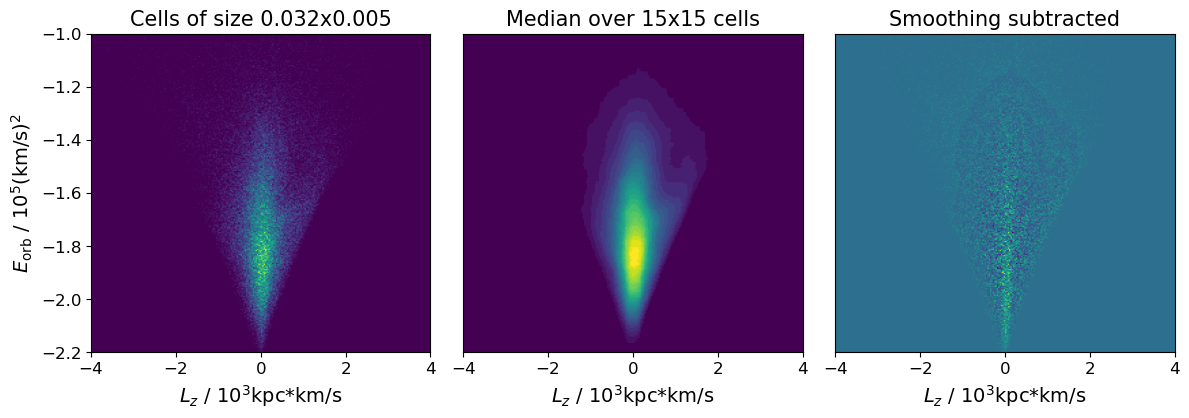

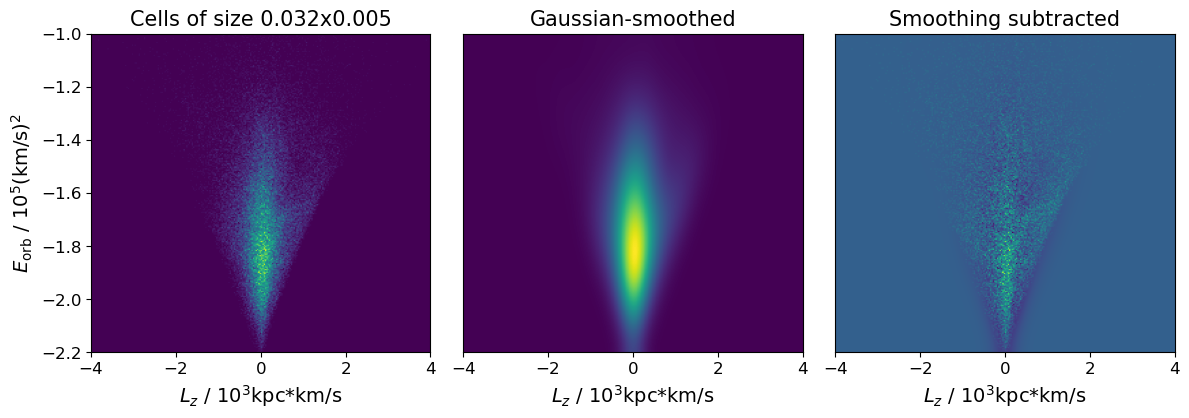

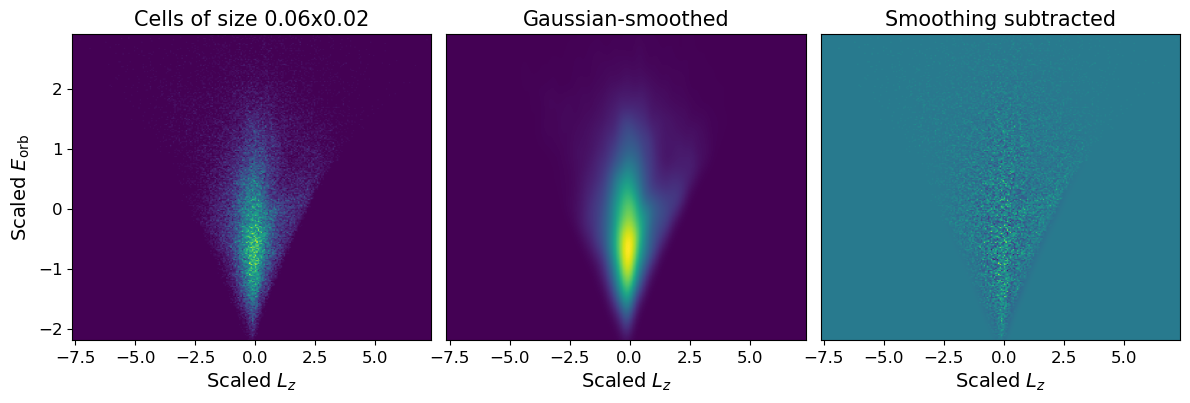

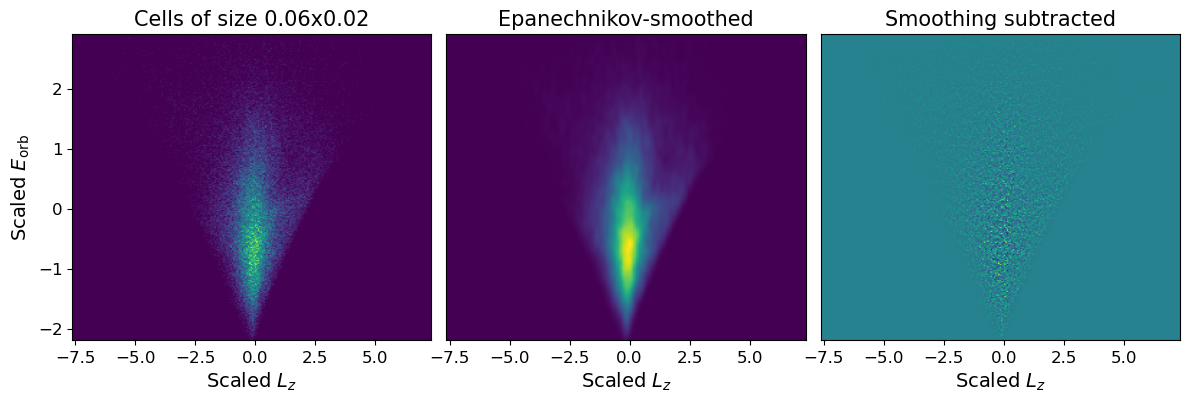

In [11]:
halo_selec=cond_v
cell_num=250
xstart=-4
xstop=4
ystart=-2.2
ystop=-1

def subtract_background(x,y,cell_num,array_size):
    xstart=-4
    xstop=4
    ystart=-2.2
    ystop=-1
    xstep=np.linspace(xstart,xstop,cell_num+1)
    ystep=np.linspace(ystart,ystop,cell_num+1)

    # count number of objects per cell for data and model
    counts=np.empty(shape=(len(ystep)-1,len(xstep)-1))
    for j in range(len(ystep)-1):
        for i in range(len(xstep)-1):
            counts[j][i]=len(x[(np.array(x)>xstep[int(i)]) & (np.array(x)<xstep[int(i+1)]) & (np.array(y)>ystep[int(j)]) & (np.array(y)<ystep[int(j+1)])])
    
    smoothed=np.empty(shape=(len(ystep)-1,len(xstep)-1))
    for j in range(0,250):
        for i in range(0,250):
            smoothed[j][i]=np.median(np.transpose(np.transpose(counts[j-int(array_size/2):j+int(array_size/2+1)])[i-int(array_size/2):i+int(array_size/2+1)]))
    smoothed[np.isnan(smoothed)==True]=0
    
    fig1,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
    axs[0].imshow(counts,aspect=6.25,extent=(xstart,xstop,ystop,ystart))
    axs[0].set_title('Cells of size '+str(round((xstop-xstart)/cell_num,3))+'x'+str(round((ystop-ystart)/cell_num,3)),size=15)
    axs[0].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
    axs[0].set_ylabel('$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',size=14)
    axs[0].set_ylim(ystart,ystop)    
    axs[0].tick_params(axis='both',labelsize=12)
    axs[1].imshow(smoothed,aspect=6.25,extent=(xstart,xstop,ystop,ystart))
    axs[1].set_title('Median over '+str(array_size)+'x'+str(array_size)+' cells',size=15)
    axs[1].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
    axs[1].set_ylim(ystart,ystop)   
    axs[1].tick_params(axis='y',which='both',left=False,labelleft=False)
    axs[1].tick_params(axis='x',labelsize=12)
    axs[2].imshow(counts-smoothed,aspect=6.25,extent=(xstart,xstop,ystop,ystart))
    axs[2].set_title('Smoothing subtracted',size=15)
    axs[2].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
    axs[2].set_ylim(ystart,ystop)
    axs[2].tick_params(axis='x',labelsize=12)
    axs[2].tick_params(axis='y',which='both',left=False,labelleft=False)
    plt.tight_layout()
    plt.savefig('figures/5_19a_smoothed_background_median.png',format='png')
    
    # smoothing with Gaussian using scipy
    fig2,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
    axs[0].imshow(counts,aspect=6.25,extent=(xstart,xstop,ystop,ystart))
    axs[0].set_title('Cells of size '+str(round((xstop-xstart)/cell_num,3))+'x'+str(round((ystop-ystart)/cell_num,3)),size=15)
    axs[0].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
    axs[0].set_ylabel('$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',size=14)
    axs[0].set_ylim(ystart,ystop)
    axs[0].tick_params(axis='both',labelsize=12)
    axs[1].imshow(gaussian_filter(counts,sigma=(20,5)),aspect=6.25,extent=(xstart,xstop,ystop,ystart))
    axs[1].set_title('Gaussian-smoothed',size=15)
    axs[1].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
    axs[1].set_ylim(ystart,ystop)
    axs[1].tick_params(axis='y',which='both',left=False,labelleft=False)
    axs[1].tick_params(axis='x',labelsize=12)
    axs[2].imshow(counts-gaussian_filter(counts,sigma=(20,5)),aspect=6.25,extent=(xstart,xstop,ystop,ystart))
    axs[2].set_title('Smoothing subtracted',size=15)
    axs[2].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
    axs[2].set_ylim(ystart,ystop)
    axs[2].tick_params(axis='x',labelsize=12)
    axs[2].tick_params(axis='y',which='both',left=False,labelleft=False)
    plt.tight_layout()
    plt.savefig('figures/5_19b_smoothed_background_gauss1.png',format='png')
    
    return counts,smoothed

counts,smoothed=subtract_background(L_z[halo_selec]/1000000,orb_E[halo_selec]/100000,cell_num,15)

# using SKLearn
nonan = (np.isnan(L_z)==False) & (np.isnan(orb_E)==False)
dat=np.transpose(np.array([L_z[nonan & halo_selec]/1000000,orb_E[nonan & halo_selec]/100000]))

# scale to standard: x_sc=(x-mu)/sigma
scaler = StandardScaler()
scaler.fit(dat)
dat_sc=scaler.transform(dat)
ranges=scaler.transform(np.array([[xstart,ystart],[xstop,ystop]]))

# kernel density estimate Gaussian and Epanechnikov
kde_g=KernelDensity(kernel='gaussian',bandwidth='scott').fit(dat_sc)
kde_e=KernelDensity(kernel='epanechnikov',bandwidth='scott').fit(dat_sc)

xgrid = np.linspace(ranges[0][0],ranges[1][0],cell_num)
ygrid = np.linspace(ranges[0][1],ranges[1][1],cell_num)
X,Y = np.meshgrid(xgrid,ygrid)
xy = np.vstack([X.ravel(), Y.ravel()]).T
Z = np.full(X.shape,True)
Z_g = np.exp(kde_g.score_samples(xy))
Z_g = Z_g.reshape(X.shape)
Z_e = np.exp(kde_e.score_samples(xy))
Z_e = Z_e.reshape(X.shape)

# to be able to subtract from counts version
norm_g=np.sum(counts)/np.sum(Z_g)
norm_e=np.sum(counts)/np.sum(Z_e)

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
axs[0].imshow(counts,aspect=2.5,extent=(ranges[0][0],ranges[1][0],ranges[1][1],ranges[0][1]))
axs[0].set_title('Cells of size '+str(round((ranges[1][0]-ranges[0][0])/cell_num,3))+'x'+str(round((ranges[1][1]-ranges[0][1])/cell_num,3)),size=15)
axs[0].set_xlabel('Scaled $L_z$',size=14)
axs[0].set_ylabel('Scaled $E_\mathrm{orb}$',size=14)
axs[0].set_ylim(ranges[0][1],ranges[1][1])
axs[0].tick_params(axis='both',labelsize=12)
axs[1].imshow(Z_g,aspect=2.5,extent=(ranges[0][0],ranges[1][0],ranges[1][1],ranges[0][1]))
axs[1].set_title('Gaussian-smoothed',size=15)
axs[1].set_xlabel('Scaled $L_z$',size=14)
axs[1].set_ylim(ranges[0][1],ranges[1][1])
axs[1].tick_params(axis='x',labelsize=12)
axs[1].tick_params(axis='y',which='both',left=False,labelleft=False)
axs[2].imshow(counts-Z_g*norm_g,aspect=2.5,extent=(ranges[0][0],ranges[1][0],ranges[1][1],ranges[0][1]))
axs[2].set_title('Smoothing subtracted',size=15)
axs[2].set_xlabel('Scaled $L_z$',size=14)
axs[2].set_ylim(ranges[0][1],ranges[1][1])
axs[2].tick_params(axis='x',labelsize=12)
axs[2].tick_params(axis='y',which='both',left=False,labelleft=False)
plt.tight_layout()
plt.savefig('figures/5_19c_smoothed_background_gauss2.png',format='png')

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
axs[0].imshow(counts,aspect=2.5,extent=(ranges[0][0],ranges[1][0],ranges[1][1],ranges[0][1]))
axs[0].set_title('Cells of size '+str(round((ranges[1][0]-ranges[0][0])/cell_num,3))+'x'+str(round((ranges[1][1]-ranges[0][1])/cell_num,3)),size=15)
axs[0].set_xlabel('Scaled $L_z$',size=14)
axs[0].set_ylabel('Scaled $E_\mathrm{orb}$',size=14)
axs[0].set_ylim(ranges[0][1],ranges[1][1])
axs[0].tick_params(axis='both',labelsize=12)
axs[1].imshow(Z_e,aspect=2.5,extent=(ranges[0][0],ranges[1][0],ranges[1][1],ranges[0][1]))
axs[1].set_title('Epanechnikov-smoothed',size=15)
axs[1].set_xlabel('Scaled $L_z$',size=14)
axs[1].set_ylim(ranges[0][1],ranges[1][1])
axs[1].tick_params(axis='x',labelsize=12)
axs[1].tick_params(axis='y',which='both',left=False,labelleft=False)
axs[2].imshow(counts-Z_e*norm_e,aspect=2.5,extent=(ranges[0][0],ranges[1][0],ranges[1][1],ranges[0][1]))
axs[2].set_title('Smoothing subtracted',size=15)
axs[2].set_xlabel('Scaled $L_z$',size=14)
axs[2].set_ylim(ranges[0][1],ranges[1][1])
axs[2].tick_params(axis='x',labelsize=12)
axs[2].tick_params(axis='y',which='both',left=False,labelleft=False)
plt.tight_layout()
plt.savefig('figures/5_19d_smoothed_background_epanechnikov.png',format='png')

Number of clusters found by HDBSCAN: 14

Cluster: 0
Substructure: sequoia
Number: 20
Median E: -126691.74192113799 km2 / s2
Median L_z: -1738780.187853207 km pc / s
Median L_perp: 1257470.5974534554 km pc / s
Median [Fe/H]: -1.2762380905213555
Median [Fe/H]: 0.5272491492553688

Cluster: 1
Substructure: helmistr1
Number: 52
Median E: -141126.82537313842 km2 / s2
Median L_z: 1210517.202610657 km pc / s
Median L_perp: 1650274.3765824595 km pc / s
Median [Fe/H]: -1.4221703353207125
Median [Fe/H]: 0.5994980758621333

Cluster: 2
Substructure: helmistr2
Number: 41
Median E: -133433.90581480882 km2 / s2
Median L_z: 1035934.2251637836 km pc / s
Median L_perp: 2086122.3569446327 km pc / s
Median [Fe/H]: -1.5647835099612442
Median [Fe/H]: 0.435234712420738

Cluster: 3
Substructure: thamnos1
Number: 23
Median E: -177513.78754510818 km2 / s2
Median L_z: -869492.2461744582 km pc / s
Median L_perp: 274639.14378172153 km pc / s
Median [Fe/H]: -1.6314341377673427
Median [Fe/H]: 0.42861440807870016

Clu

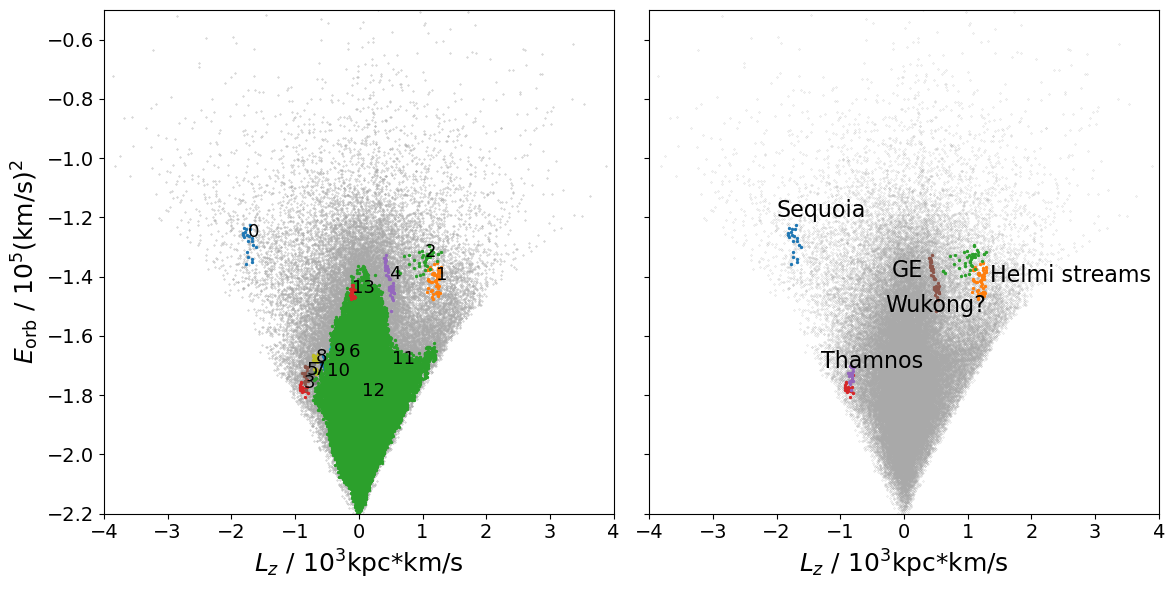

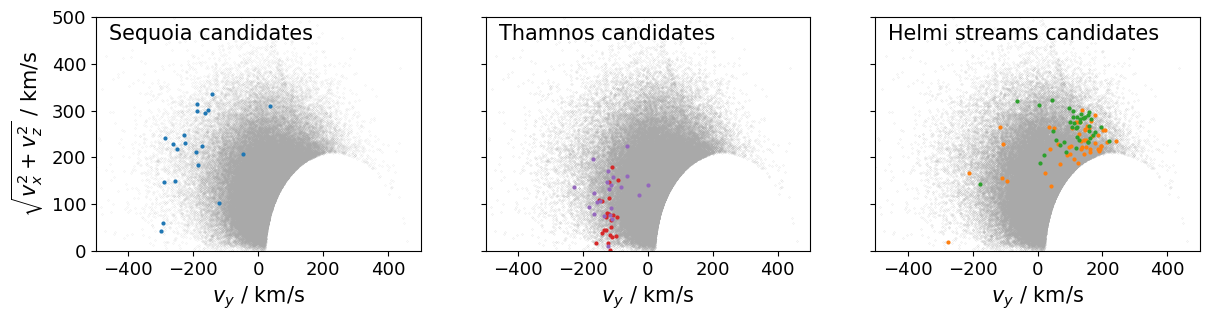

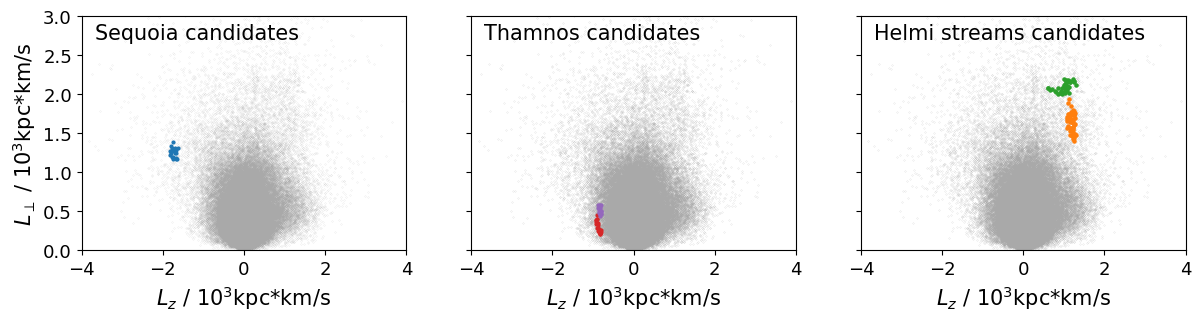

In [12]:
# using SKLearn
nonan = (np.isnan(L_z)==False) & (np.isnan(orb_E)==False)
dat=np.transpose(np.array([L_z[nonan & halo_selec]/1000000,orb_E[nonan & halo_selec]/100000,L_perp[nonan & halo_selec]/1000000]))

hdb = HDBSCAN(min_cluster_size=20,max_cluster_size=50000)
hdb.fit(dat)
print('Number of clusters found by HDBSCAN:',len(set(hdb.labels_[hdb.labels_!=-1])))

fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,2,1)
plt.scatter(np.array(L_z[nonan & halo_selec]/1000000),np.array(orb_E[nonan & halo_selec]/100000),s=0.1,color='darkgray')
for num in range(len(set(hdb.labels_[hdb.labels_!=-1]))):
    if len(L_z[nonan & halo_selec][(hdb.labels_==num)]) > 100000:
        pass
    else:
        plt.scatter(np.array(L_z[nonan & halo_selec]/1000000)[(hdb.labels_==num)],np.array(orb_E[nonan & halo_selec]/100000)[(hdb.labels_==num)],s=2)
        plt.text(np.nanmedian(np.array(L_z[nonan & halo_selec]/1000000)[(hdb.labels_==num)]),np.nanmedian(np.array(orb_E[nonan & halo_selec]/100000)[(hdb.labels_==num)]),str(num),size=13)
        plt.xlabel('$L_z$ / $10^3$kpc*km/s',size=18)
        plt.ylabel('$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',size=18)
        plt.xlim(-4,4)
        plt.ylim(-2.2,-0.5)
plt.tick_params(axis='both',labelsize=14)
ax=fig.add_subplot(1,2,2)
clusters=[0,1,2,3,5,4]
plt.scatter(np.array(L_z[nonan & halo_selec]/1000000),np.array(orb_E[nonan & halo_selec]/100000),s=0.03,color='darkgray')
for num in clusters:
    plt.scatter(np.array(L_z[nonan & halo_selec]/1000000)[(hdb.labels_==num)],np.array(orb_E[nonan & halo_selec]/100000)[(hdb.labels_==num)],s=2)
    plt.xlabel('$L_z$ / $10^3$kpc*km/s',size=18)
    plt.xlim(-4,4)
    plt.ylim(-2.2,-0.5)
plt.text(-2,-1.2,'Sequoia',size=16)
plt.text(-1.3,-1.71,'Thamnos',size=16)
plt.text(1.35,-1.42,'Helmi streams',size=16)
plt.text(-0.2,-1.4,'GE',size=16)
plt.text(-0.3,-1.52,'Wukong?',size=16)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',which='both',bottom=False,top=False,labelleft=False)
plt.tight_layout()
plt.savefig('figures/5_20a_hdbscan_clusters.png',format='png')

fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(12,3),sharey=True)
axs[0].scatter(np.transpose(v_gc)[1][nonan & halo_selec],v_zx[nonan & halo_selec],color='darkgray',s=0.005)
axs[0].set_xlim(-500,500)
axs[0].set_ylim(0,500)
axs[0].set_xlabel('$v_y$ / km/s',size=15)
axs[0].set_ylabel('$\sqrt{v_x^2+v_z^2}$ / km/s',size=15)
axs[0].scatter(np.transpose(v_gc)[1][nonan & halo_selec][hdb.labels_==0],v_zx[nonan & halo_selec][hdb.labels_==0],s=4,color='tab:blue')
axs[0].tick_params(axis='both',labelsize=13)
axs[1].scatter(np.transpose(v_gc)[1][nonan & halo_selec],v_zx[nonan & halo_selec],color='darkgray',s=0.01)
axs[1].set_xlabel('$v_y$ / km/s',size=15)
axs[1].scatter(np.transpose(v_gc)[1][nonan & halo_selec][hdb.labels_==3],v_zx[nonan & halo_selec][hdb.labels_==3],s=4,color='tab:red')
axs[1].scatter(np.transpose(v_gc)[1][nonan & halo_selec][hdb.labels_==5],v_zx[nonan & halo_selec][hdb.labels_==5],s=4,color='tab:purple')
axs[1].set_xlim(-500,500)
axs[1].set_ylim(0,500)
axs[1].tick_params(axis='x',labelsize=13)
axs[2].scatter(np.transpose(v_gc)[1][nonan & halo_selec],v_zx[nonan & halo_selec],color='darkgray',s=0.01)
axs[2].set_xlim(-500,500)
axs[2].set_ylim(0,500)
axs[2].set_xlabel('$v_y$ / km/s',size=15)
axs[2].scatter(np.transpose(v_gc)[1][nonan & halo_selec][hdb.labels_==1],v_zx[nonan & halo_selec][hdb.labels_==1],s=4,color='tab:orange')
axs[2].scatter(np.transpose(v_gc)[1][nonan & halo_selec][hdb.labels_==2],v_zx[nonan & halo_selec][hdb.labels_==2],s=4,color='tab:green')
axs[2].tick_params(axis='x',labelsize=13)
axs[0].annotate('Sequoia candidates',size=15, xy=(0.04, 0.9), xycoords='axes fraction')
axs[1].annotate('Thamnos candidates',size=15, xy=(0.04, 0.9), xycoords='axes fraction')
axs[2].annotate('Helmi streams candidates',size=15, xy=(0.04, 0.9), xycoords='axes fraction')
plt.subplots_adjust(left=0.075,top=0.98,bottom=0.2,right=0.995)
plt.savefig('figures/5_20c_substructures_vperp_vy.png',format='png')

fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(12,3),sharey=True)
axs[0].scatter(L_z[nonan & halo_selec]/1000000,L_perp[nonan & halo_selec]/1000000,color='darkgray',s=0.005)
axs[0].set_xlim(-4,4)
axs[0].set_ylim(0,3)
axs[0].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=15)
axs[0].set_ylabel('$L_\perp$ / $10^3$kpc*km/s',size=15)
axs[0].scatter(L_z[nonan & halo_selec][hdb.labels_==0]/1000000,L_perp[nonan & halo_selec][hdb.labels_==0]/1000000,s=4,color='tab:blue')
axs[0].tick_params(axis='both',labelsize=13)
axs[1].scatter(L_z[nonan & halo_selec]/1000000,L_perp[nonan & halo_selec]/1000000,color='darkgray',s=0.01)
axs[1].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=15)
axs[1].scatter(L_z[nonan & halo_selec][hdb.labels_==3]/1000000,L_perp[nonan & halo_selec][hdb.labels_==3]/1000000,s=4,color='tab:red')
axs[1].scatter(L_z[nonan & halo_selec][hdb.labels_==5]/1000000,L_perp[nonan & halo_selec][hdb.labels_==5]/1000000,s=4,color='tab:purple')
axs[1].set_xlim(-4,4)
axs[1].set_ylim(0,3)
axs[1].tick_params(axis='x',labelsize=13)
axs[2].scatter(L_z[nonan & halo_selec]/1000000,L_perp[nonan & halo_selec]/1000000,color='darkgray',s=0.01)
axs[2].set_xlim(-4,4)
axs[2].set_ylim(0,3)
axs[2].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=15)
axs[2].scatter(L_z[nonan & halo_selec][hdb.labels_==1]/1000000,L_perp[nonan & halo_selec][hdb.labels_==1]/1000000,s=5,color='tab:orange')
axs[2].scatter(L_z[nonan & halo_selec][hdb.labels_==2]/1000000,L_perp[nonan & halo_selec][hdb.labels_==2]/1000000,s=5,color='tab:green')
axs[2].tick_params(axis='x',labelsize=13)
axs[0].annotate('Sequoia candidates',size=15, xy=(0.04, 0.9), xycoords='axes fraction')
axs[1].annotate('Thamnos candidates',size=15, xy=(0.04, 0.9), xycoords='axes fraction')
axs[2].annotate('Helmi streams candidates',size=15, xy=(0.04, 0.9), xycoords='axes fraction')
plt.subplots_adjust(left=0.075,top=0.98,bottom=0.2,right=0.995)
plt.savefig('figures/5_20b_substructures_Lperp_Lz.png',format='png')

substr_dict = {0: 'sequoia', 1:'helmistr1', 2:'helmistr2', 3:'thamnos1', 4:'wukong', 5:'thamnos2'}
for num in range(6):
    print('\nCluster:',num)
    print('Substructure:',substr_dict[num])
    i=(hdb.labels_==num)
    print('Number:',len(feh[nonan & halo_selec][i]))
    print('Median E:',np.median(orb_E[nonan & halo_selec][i]))
    print('Median L_z:',np.median(L_z[nonan & halo_selec][i]))
    print('Median L_perp:',np.median(L_perp[nonan & halo_selec][i]))
    print('Median [Fe/H]:',np.median(feh[nonan & halo_selec][i]))
    print('Median [Fe/H]:',np.std(feh[nonan & halo_selec][i]))

### 5.4.2. Kinematic plots from 5.2. in strict cuts

With this strict selection, the number of objects is 12052
/home/jens/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)

/home/jens/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)



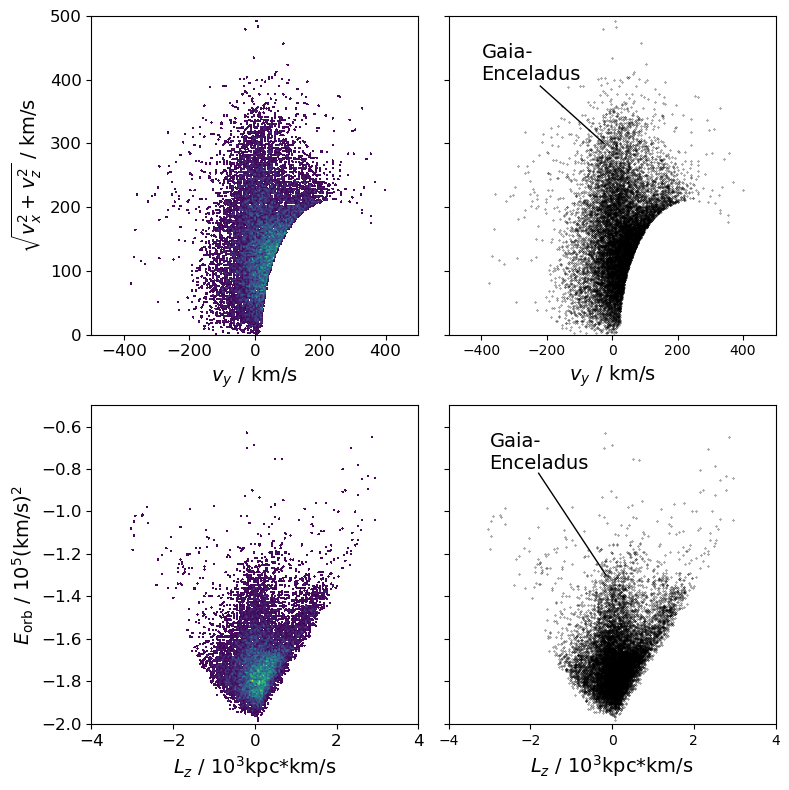

In [13]:
# repeat kinematic plots with very strict quality cuts
#cond_v_ext = (np.sqrt(np.transpose(v_gc)[0]**2+(np.transpose(v_gc)[1]-232*u.km/u.s)**2+np.transpose(v_gc)[2]**2) > 232*u.km/u.s)
ruwe_cond = (ruwe < 1.4)
bprp_excess_cond = (bprp_excess < 1.27)
paral_e_cond = (paral_rv/paral_e_rv > 5)
proximity = (paral0_rv > 0.4)
rad_vel_cond = (rad_vel_e<4)
cond_strict = cond_v & proximity #& rad_vel_cond & paral_e_cond & bprp_excess_cond & ruwe_cond

print('With this strict selection, the number of objects is',len(v_gc[cond_strict]))

fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(2, 2, 1, projection='scatter_density')
density = ax.scatter_density(np.array(np.transpose(v_gc)[1][cond_strict & cond_ana & (np.isnan(orb_E)==False)]),np.array(v_zx[cond_strict & cond_ana & (np.isnan(orb_E)==False)]), cmap=white_viridis)
plt.xlim(-500,500)
plt.ylim(0,500)
plt.xlabel('$v_y$ / km/s',size=14)
plt.ylabel('$\sqrt{v_x^2+v_z^2}$ / km/s',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
ax = fig.add_subplot(2, 2, 3, projection='scatter_density')
density = ax.scatter_density(np.array(L_z[cond_strict & cond_ana & (np.isnan(orb_E)==False)]/1000000),np.array(orb_E[cond_strict & cond_ana & (np.isnan(orb_E)==False)]/100000), cmap=white_viridis)
plt.xlim(-4,4)
plt.ylim(-2,-0.5)
plt.xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
plt.ylabel('$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
ax = fig.add_subplot(2, 2, 2, projection='scatter_density')
plt.scatter(np.transpose(v_gc)[1][cond_strict & cond_ana & (np.isnan(orb_E)==False)],v_zx[cond_strict & cond_ana & (np.isnan(orb_E)==False)],s=0.07,color='black')
plt.xlabel('$v_y$ / km/s',size=14)
plt.xlim(-500,500)
plt.ylim(0,500)
plt.text(-400,400,'Gaia-\nEnceladus',size=14)
plt.plot(np.linspace(-220,-25),np.linspace(390,300),color='black',lw=1)
plt.tick_params(axis='y',which='both',bottom=False,top=False,labelleft=False)
ax = fig.add_subplot(2, 2, 4, projection='scatter_density')
plt.scatter(L_z[cond_strict & cond_ana & (np.isnan(orb_E)==False)]/1000000,orb_E_MM17[cond_strict & cond_ana & (np.isnan(orb_E)==False)]/100000,s=0.07,color='black')
plt.xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
plt.xlim(-4,4)
plt.ylim(-2,-0.5)
plt.text(-3,-0.8,'Gaia-\nEnceladus',size=14)
plt.plot(np.linspace(-1.8,-0.15),np.linspace(-0.82,-1.3),color='black',lw=1)
plt.tick_params(axis='y',which='both',bottom=False,top=False,labelleft=False)
plt.tight_layout()
plt.savefig('figures/5_21_strictsel.png',format='png') 

#fig2=plt.figure(figsize=(15,5))
#fig2.suptitle('$\sqrt{v_x^2+v_z^2}$ vs. $v_y$ in GC coordinates',size=20,y=1.03)
#scatter_plots(fig2,np.transpose(v_gc)[1],v_zx,1,cond_strict & cond_e & (np.isnan(v_zx)==False),'Full sample',-400,500,0,500,None,'$\sqrt{v_x^2+v_z^2}$ / km/s',None)
#scatter_plots(fig2,np.transpose(v_gc)[1],v_zx,2,cond_strict & cond_halo & (np.isnan(v_zx)==False),'$\lambda_z$-selection',-750,750,0,750,None,None,None)
#scatter_plots(fig2,np.transpose(v_gc)[1],v_zx,3,cond_strict & cond_v & (np.isnan(v_zx)==False),'$|v-v_{\mathrm{LSR}}|>210$km/s',-750,750,0,750,'$v_y$ / km/s','$\sqrt{v_x^2+v_z^2}$ / km/s',None)
#scatter_plots(fig2,np.transpose(v_gc)[1],v_zx,4,cond_strict & cond_z & (np.isnan(v_zx)==False),'$|z|$>4000pc',-750,750,0,750,'$v_y$ / km/s',None,None)
#plt.savefig('/home/jens/Dokumente/Unikram/Master/5WS2022_6SS2023/Masterarbeit/figures/5_21a_strictsel_vperp_vy.png',format='png')  

#fig3=plt.figure(figsize=(12,9))
#fig3.suptitle('Specific $L_{\perp}$ vs $L_z$',size=20,y=1.03)
#scatter_plots(fig3,L_z/1000000,L_perp/1000000,1,cond_strict & cond_e & (np.isnan(v_zx)==False),'Full sample',-4.5,4.5,0,2,None,'$L_{\perp}$ / $10^3$kpc*km/s',None)
#scatter_plots(fig3,L_z/1000000,L_perp/1000000,2,cond_strict & cond_halo & (np.isnan(v_zx)==False),'$\lambda_z$-selection',-4.5,4.5,0,4.5,None,None,None)
#scatter_plots(fig3,L_z/1000000,L_perp/1000000,3,cond_strict & cond_v & (np.isnan(v_zx)==False),'$|v-v_{\mathrm{LSR}}|>210$km/s',-4.5,4.5,0,4.5,'$L_z$ / $10^3$kpc*km/s','$L_{\perp}$ / $10^3$kpc*km/s',None)
#scatter_plots(fig3,L_z/1000000,L_perp/1000000,4,cond_strict & cond_z & (np.isnan(v_zx)==False),'$|z|$>4000pc',-4.5,4.5,0,4.5,'$L_z$ / $10^3$kpc*km/s',None,None)
#plt.savefig('/home/jens/Dokumente/Unikram/Master/5WS2022_6SS2023/Masterarbeit/figures/5_21b_strictsel_Lperp_Lz.png',format='png')  

#fig4=plt.figure(figsize=(12,9))
#fig4.suptitle('Orbital energy vs. angular momentum $z$-component',size=20,y=1.03)
#scatter_plots(fig4,L_z/1000000,orb_E/100000,1,cond_strict & cond_e & (np.isnan(v_zx)==False),'Full sample',-6,6,np.array(np.nanmin(orb_E))/100000,0.5,None,'$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',500)
#scatter_plots(fig4,L_z/1000000,orb_E/100000,2,cond_strict & cond_halo & (np.isnan(v_zx)==False),'$\lambda_z$-selection',-6,6,np.array(np.nanmin(orb_E))/100000,0.5,None,None,None)
#scatter_plots(fig4,L_z/1000000,orb_E/100000,3,cond_strict & cond_v & (np.isnan(v_zx)==False),'$|v-v_{\mathrm{LSR}}|>210$km/s',-6,6,np.array(np.nanmin(orb_E))/100000,0.5,'$L_z$ / $10^3$kpc*km/s','$E_\mathrm{orb}$ / $10^5$(km/s)$^2$',None)
#scatter_plots(fig4,L_z/1000000,orb_E/100000,4,cond_strict & cond_z & (np.isnan(v_zx)==False),'$|z|$>4000pc',-6,6,np.array(np.nanmin(orb_E))/100000,0.5,'$L_z$ / $10^3$kpc*km/s',None,None)
#plt.savefig('/home/jens/Dokumente/Unikram/Master/5WS2022_6SS2023/Masterarbeit/figures/5_21c_strictsel_orbE_Lz.png',format='png') 

### 5.4.3. Different [Fe/H] distributions using Pristine and GALAH

With this strict selection, the number of objects is 33508


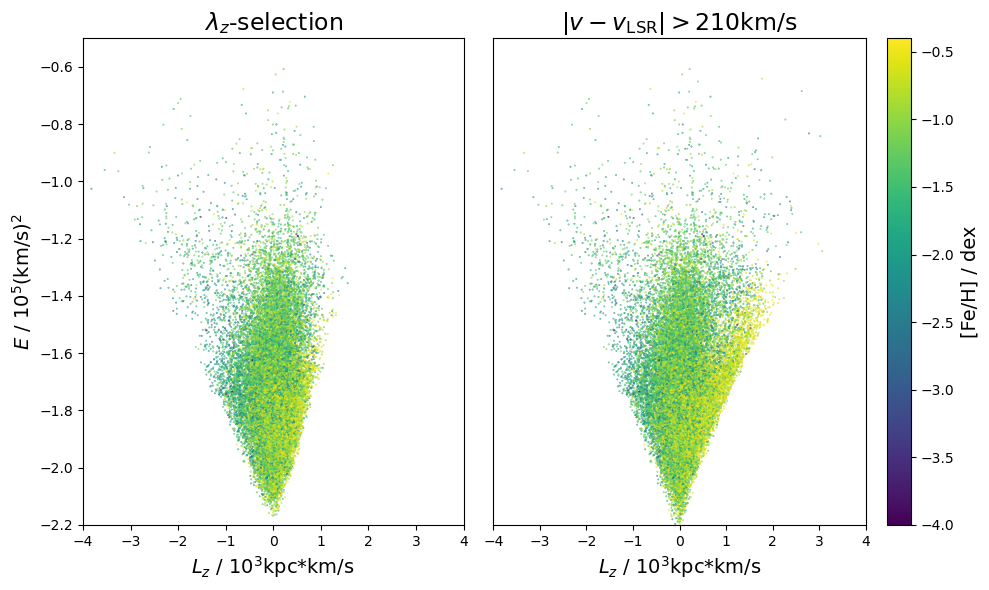

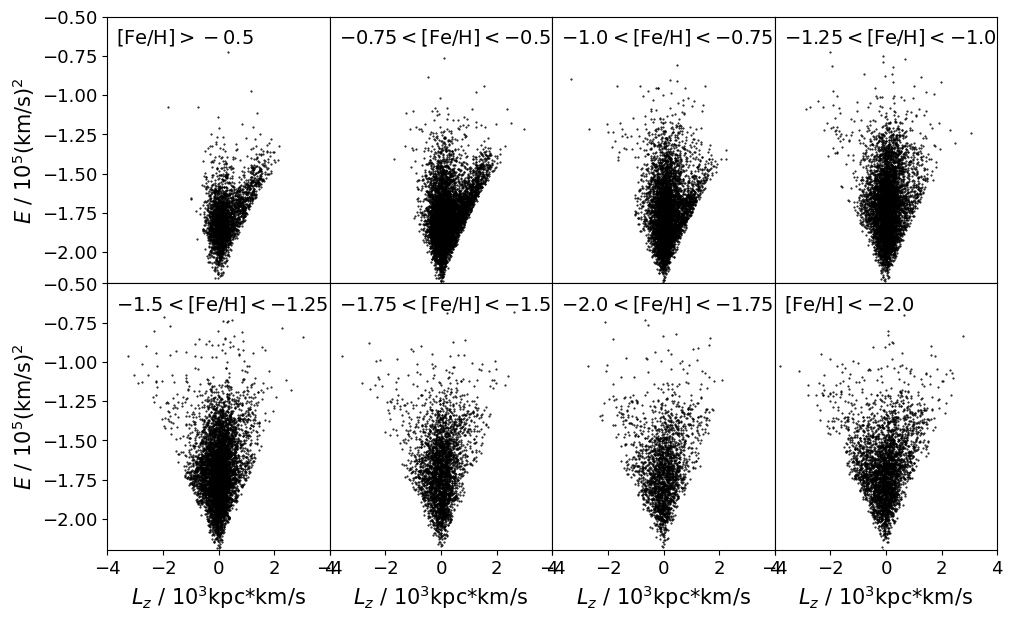

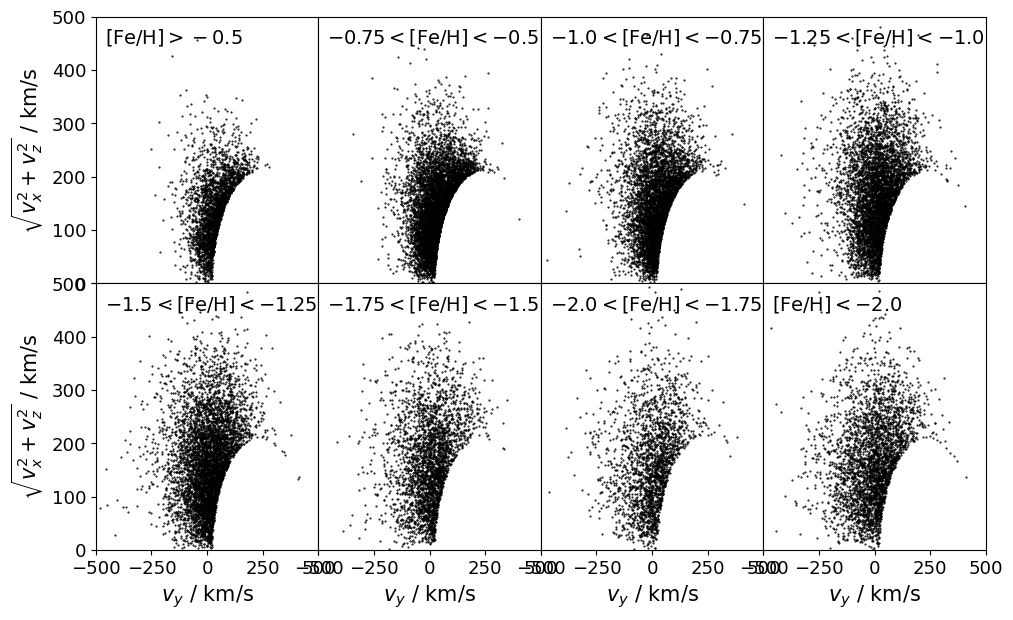

In [14]:
#cond_v_ext = (np.sqrt(np.transpose(v_gc)[0]**2+(np.transpose(v_gc)[1]-232*u.km/u.s)**2+np.transpose(v_gc)[2]**2) > 232*u.km/u.s)
ruwe_cond = (ruwe < 1.4)
bprp_excess_cond = (bprp_excess < 1.27)
paral_e_cond = (paral_rv/paral_e_rv > 5)
proximity = (paral0_rv > 0.4)
rad_vel_cond = (rad_vel_e<4)
cond_strict = cond_v & rad_vel_cond & paral_e_cond #& proximity #& bprp_excess_cond & ruwe_cond

print('With this strict selection, the number of objects is',len(v_gc[cond_strict]))

# incorporating the Pristine metallicities by doing metallicity cuts and colour coding
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,6),sharex=True,sharey=True,gridspec_kw={'width_ratios': [1, 1.1]})
axs[0].scatter(L_z[cond_halo & cond_strict]/1000000,orb_E_MM17[cond_halo & cond_strict]/100000,s=0.11,c=feh[cond_halo & cond_strict])
axs[0].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
axs[0].set_ylabel('$E$ / $10^5$(km/s)$^2$',size=14)
axs[0].set_title('$\lambda_z$-selection',size=17)
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-2.2,-0.5)
cbar=axs[1].scatter(L_z[cond_v & cond_strict]/1000000,orb_E_MM17[cond_v & cond_strict]/100000,s=0.11,c=feh[cond_v & cond_strict])
axs[1].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
axs[1].set_title('$|v-v_{\mathrm{LSR}}|>210$km/s',size=17)
axs[1].tick_params(axis='y',which='both',left=False,labelleft=False)
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-2.2,-0.5)
plt.colorbar(cbar,fraction=0.06,pad=0.05).set_label(label='[Fe/H] / dex',size=14)
plt.tight_layout()
plt.savefig('figures/5_22a_colourcode_metal_E_Lz.png',format='png') 

# small metallicity increments
cond_feh1=(feh>-0.5)
cond_feh2=(feh<-0.5) & (feh>-0.75)
cond_feh3=(feh<-0.75) & (feh>-1.0)
cond_feh4=(feh<-1.0) & (feh>-1.25)
cond_feh5=(feh<-1.25) & (feh>-1.5)
cond_feh6=(feh<-1.5) & (feh>-1.75)
cond_feh7=(feh<-1.75) & (feh>-2.0)
cond_feh8=(feh<-2.0)

def kinplot_metalcut(cond,xquan,yquan,xlab,ylab,xlim,ylim):
    cond_feh=[cond_feh1,cond_feh2,cond_feh3,cond_feh4,cond_feh5,cond_feh6,cond_feh7,cond_feh8]
    feh_annot=['$\mathrm{[Fe/H]}>-0.5$','$-0.75<\mathrm{[Fe/H]}<-0.5$','$-1.0<\mathrm{[Fe/H]}<-0.75$','$-1.25<\mathrm{[Fe/H]}<-1.0$','$-1.5<\mathrm{[Fe/H]}<-1.25$','$-1.75<\mathrm{[Fe/H]}<-1.5$','$-2.0<\mathrm{[Fe/H]}<-1.75$','$\mathrm{[Fe/H]}<-2.0$']
    for i in range(8):
        ax=fig.add_subplot(2,4,i+1)
        plt.scatter(xquan[cond & cond_feh[i]],yquan[cond & cond_feh[i]],s=0.25,color='black')
        plt.annotate(feh_annot[i],size=14, xy=(0.04, 0.9), xycoords='axes fraction')
        plt.xlim(xlim)
        plt.ylim(ylim)
        if (i==1) or (i==2) or (i==3):
            plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
        elif (i==5) or (i==6) or (i==7):
            plt.xlabel(xlab,size=15)
            plt.tick_params(axis='x',labelsize=13)
            plt.tick_params(axis='y',which='both',left=False,labelleft=False)
        elif (i==0):
            plt.ylabel(ylab,size=15)
            plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
            plt.tick_params(axis='y',labelsize=13)
        elif (i==4):
            plt.xlabel(xlab,size=15)
            plt.ylabel(ylab,size=15)
            plt.tick_params(axis='both',labelsize=13)
    plt.subplots_adjust(wspace=0,hspace=0,left=0.1,bottom=0.1,top=0.989,right=0.99)
    
#fig=plt.figure(figsize=(10,6))
#kinplot_metalcut(cond_halo & cond_strict,L_z/1000000,orb_E_MM17/100000,'$L_z$ / $10^3$kpc*km/s','$E$ / $10^5$(km/s)$^2$',[-4,4],[-2.2,-0.5])
#plt.savefig('figures/5_22c_orbE_Lz_metalcuts_condhalo.png',format='png') 

fig=plt.figure(figsize=(10,6))
kinplot_metalcut(cond_v & cond_strict,L_z/1000000,orb_E_MM17/100000,'$L_z$ / $10^3$kpc*km/s','$E$ / $10^5$(km/s)$^2$',[-4,4],[-2.2,-0.5])
plt.savefig('figures/5_22d_orbE_Lz_metalcuts_condv.png',format='png')

#fig=plt.figure(figsize=(10,6))
#kinplot_metalcut(cond_halo & cond_strict,np.transpose(v_gc)[1],v_zx,'$v_y$ / km/s','$\sqrt{v_x^2+v_z^2}$ / km/s',[-500,500],[0,500])
#plt.savefig('figures/5_22d_vperp_vy_metalcuts_condhalo.png',format='png') 

fig=plt.figure(figsize=(10,6))
kinplot_metalcut(cond_v & cond_strict,np.transpose(v_gc)[1],v_zx,'$v_y$ / km/s','$\sqrt{v_x^2+v_z^2}$ / km/s',[-500,500],[0,500])
plt.savefig('figures/5_22f_vperp_vy_metalcuts_condv.png',format='png') 

In [15]:
# use GALAH as well (initially also GSP-Spec but has been removed, see Appendix)
# enter path of table to be used:
# for now enter the table I downloaded from Gaia, as 4MOST input catalogue does not contain all parameters yet
path='data/kinematic_analysis_plus_galah_gspspec.fits'

hdu_list = fits.open(path, memmap=True)
evt_data = Table(hdu_list[1].data)
evt_data

<Table length=909496>
    sourceid     ...               flags_gspspec              
     int64       ...                   str41                  
---------------- ... -----------------------------------------
1004202009188352 ...                                          
1005885636393984 ...                                          
1011177036100992 ...                                          
1009871366012800 ...                                          
1009149811510784 ... 00000020000009999999999999999999999999999
1031724159655296 ...                                          
             ... ...                                       ...
 971251020192640 ...                                          
 978191687136896 ...                                          
 981245408325504 ...                                          
 990629912562048 ... 00000020000009999999999999999999999999999
 990011437273472 ...                                          
 995332901059840 ...                                          
 999700883485568 ...

In [16]:
print('Gaia DR3 GSP-Spec:')
print('Number of objects with [M/H] in GSP-Spec:',len(evt_data[np.isnan(evt_data['mh_gspspec'])==False]))
print('Number of objects with [alpha/Fe] in GSP-Spec:',len(evt_data[np.isnan(evt_data['alphafe_gspspec'])==False]))

print('\nGALAH:')
print('Number of objects in crossmatch with GALAH:',len(evt_data[evt_data['flag_sp']!=-2**63]))
print('Number of objects with [Fe/H]:',len(evt_data[np.isnan(evt_data['fe_h'])==False]))
print('Number of objects with [alpha/Fe]:',len(evt_data[np.isnan(evt_data['alpha_fe'])==False]))
print('Number of objects with [Li/Fe]:',len(evt_data[np.isnan(evt_data['Li_fe'])==False]))
print('Number of objects with [C/Fe]:',len(evt_data[np.isnan(evt_data['C_fe'])==False]))
print('Number of objects with [O/Fe]:',len(evt_data[np.isnan(evt_data['O_fe'])==False]))
print('Number of objects with [Na/Fe]:',len(evt_data[np.isnan(evt_data['Na_fe'])==False]))
print('Number of objects with [Mg/Fe]:',len(evt_data[np.isnan(evt_data['Mg_fe'])==False]))
print('Number of objects with [Ca/Fe]:',len(evt_data[np.isnan(evt_data['Ca_fe'])==False]))
print('Number of objects with [Sr/Fe]:',len(evt_data[np.isnan(evt_data['Sr_fe'])==False]))
print('Number of objects with [Y/Fe]:',len(evt_data[np.isnan(evt_data['Y_fe'])==False]))
print('Number of objects with [Zr/Fe]:',len(evt_data[np.isnan(evt_data['Zr_fe'])==False]))
print('Number of objects with [Ba/Fe]:',len(evt_data[np.isnan(evt_data['Ba_fe'])==False]))
print('Number of objects with [La/Fe]:',len(evt_data[np.isnan(evt_data['La_fe'])==False]))
print('Number of objects with [Ce/Fe]:',len(evt_data[np.isnan(evt_data['Ce_fe'])==False]))
print('Number of objects with [Nd/Fe]:',len(evt_data[np.isnan(evt_data['Nd_fe'])==False]))
print('Number of objects with [Sm/Fe]:',len(evt_data[np.isnan(evt_data['Sm_fe'])==False]))
print('Number of objects with [Eu/Fe]:',len(evt_data[np.isnan(evt_data['Eu_fe'])==False]))

# loading of parameters and alpha abundances in GSP-Spec
x = evt_data['x_gc']
y = evt_data['y_gc']
z = evt_data['z_gc']
v_x = evt_data['vx_gc']
v_y = evt_data['vy_gc']
v_z = evt_data['vz_gc']
v_tot = np.sqrt(v_x**2+v_y**2+v_z**2)
v_zx = evt_data['vzx_gc']
L_z = evt_data['L_z']
L_perp = evt_data['L_perp']
orb_E = evt_data['orb_E_MM17']
pot_E = evt_data['Phi_MM17']
cond_v=evt_data['cond_v']
cond_halo=evt_data['cond_halo']
rad_gc=evt_data['rad_gc']
R_gc=evt_data['R_gc']
feh=evt_data['FeHphot_gen']
ruwe=evt_data['ruwe']
phi_gala=evt_data['phi_gala']
orb_E_gala=evt_data['orb_E_gala']
distance=evt_data['distance']

feh_galah = evt_data['fe_h']
alphafe_galah = evt_data['alpha_fe']
cfe_galah = evt_data['C_fe']
ofe_galah = evt_data['O_fe']
mgfe_galah = evt_data['Mg_fe']
cafe_galah = evt_data['Ca_fe']
feh_galah = evt_data['fe_h']
srfe_galah = evt_data['Sr_fe']
yfe_galah = evt_data['Y_fe']
zrfe_galah = evt_data['Zr_fe']
bafe_galah = evt_data['Ba_fe']
lafe_galah = evt_data['La_fe']
cefe_galah = evt_data['Ce_fe']
ndfe_galah = evt_data['Nd_fe']
smfe_galah = evt_data['Sm_fe']
eufe_galah = evt_data['Eu_fe']
e_srfe_galah = evt_data['e_Sr_fe']
e_yfe_galah = evt_data['e_Y_fe']
e_zrfe_galah = evt_data['e_Zr_fe']
e_bafe_galah = evt_data['e_Ba_fe']
e_lafe_galah = evt_data['e_La_fe']
e_cefe_galah = evt_data['e_Ce_fe']
e_ndfe_galah = evt_data['e_Nd_fe']
e_smfe_galah = evt_data['e_Sm_fe']
e_eufe_galah = evt_data['e_Eu_fe']
e_feh_galah = evt_data['e_fe_h']

# include flags
flag_sp=evt_data['flag_sp']
clean_flag_galah = (flag_sp==0)
flag_fe_h = (evt_data['flag_fe_h']==0)
flag_alpha_fe = (evt_data['flag_alpha_fe']==0)
flag_cfe = (evt_data['flag_C_fe']==0)
flag_ofe = (evt_data['flag_O_fe']==0)
flag_mgfe = (evt_data['flag_Mg_fe']==0)
flag_cafe = (evt_data['flag_Ca_fe']==0)
flag_sr_fe = (evt_data['flag_Sr_fe']==0)
flag_y_fe = (evt_data['flag_Y_fe']==0)
flag_zr_fe = (evt_data['flag_Zr_fe']==0)
flag_ba_fe = (evt_data['flag_Ba_fe']==0)
flag_la_fe = (evt_data['flag_La_fe']==0)
flag_ce_fe = (evt_data['flag_Ce_fe']==0)
flag_nd_fe = (evt_data['flag_Nd_fe']==0)
flag_sm_fe = (evt_data['flag_Sm_fe']==0)
flag_eu_fe = (evt_data['flag_Eu_fe']==0)

Gaia DR3 GSP-Spec:
Number of objects with [M/H] in GSP-Spec: 88669
Number of objects with [alpha/Fe] in GSP-Spec: 87106

GALAH:
Number of objects in crossmatch with GALAH: 55965
Number of objects with [Fe/H]: 54601
Number of objects with [alpha/Fe]: 52264
Number of objects with [Li/Fe]: 43338
Number of objects with [C/Fe]: 26669
Number of objects with [O/Fe]: 52073
Number of objects with [Na/Fe]: 53448
Number of objects with [Mg/Fe]: 51903
Number of objects with [Ca/Fe]: 52345
Number of objects with [Sr/Fe]: 8984
Number of objects with [Y/Fe]: 48771
Number of objects with [Zr/Fe]: 11205
Number of objects with [Ba/Fe]: 53277
Number of objects with [La/Fe]: 25840
Number of objects with [Ce/Fe]: 26479
Number of objects with [Nd/Fe]: 19541
Number of objects with [Sm/Fe]: 24952
Number of objects with [Eu/Fe]: 20730


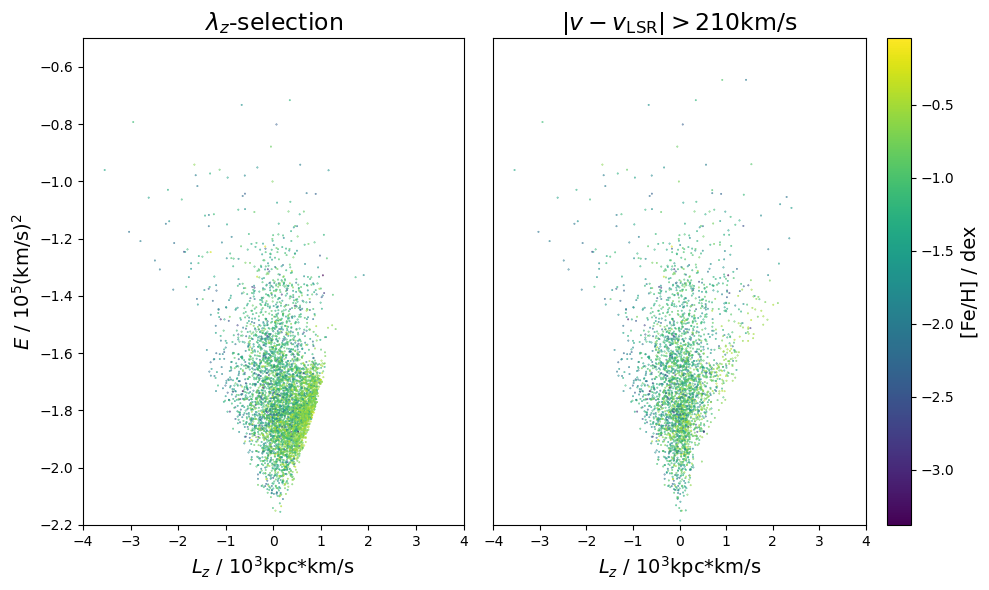

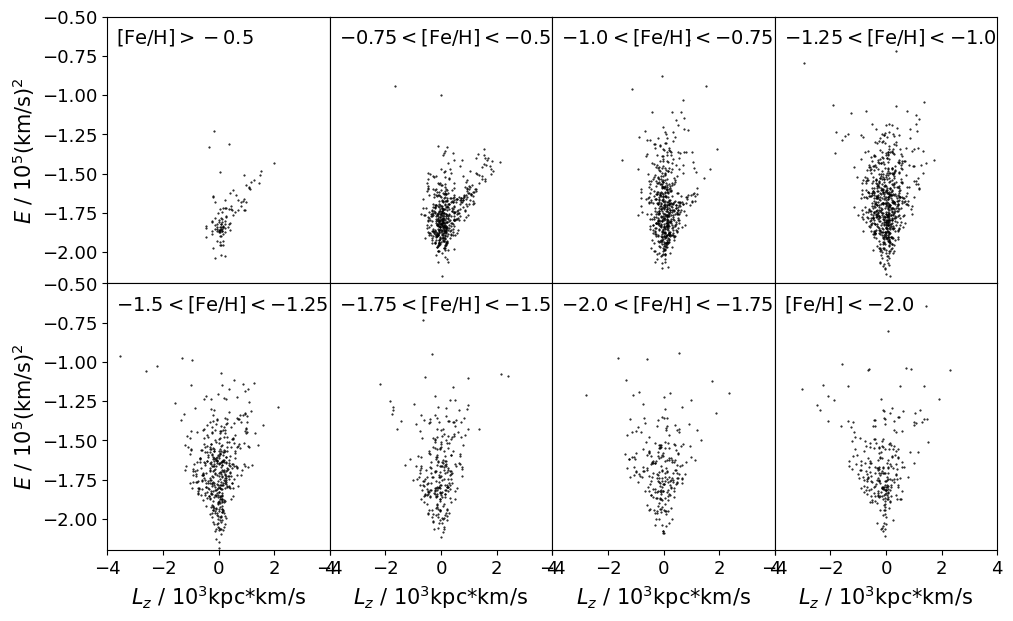

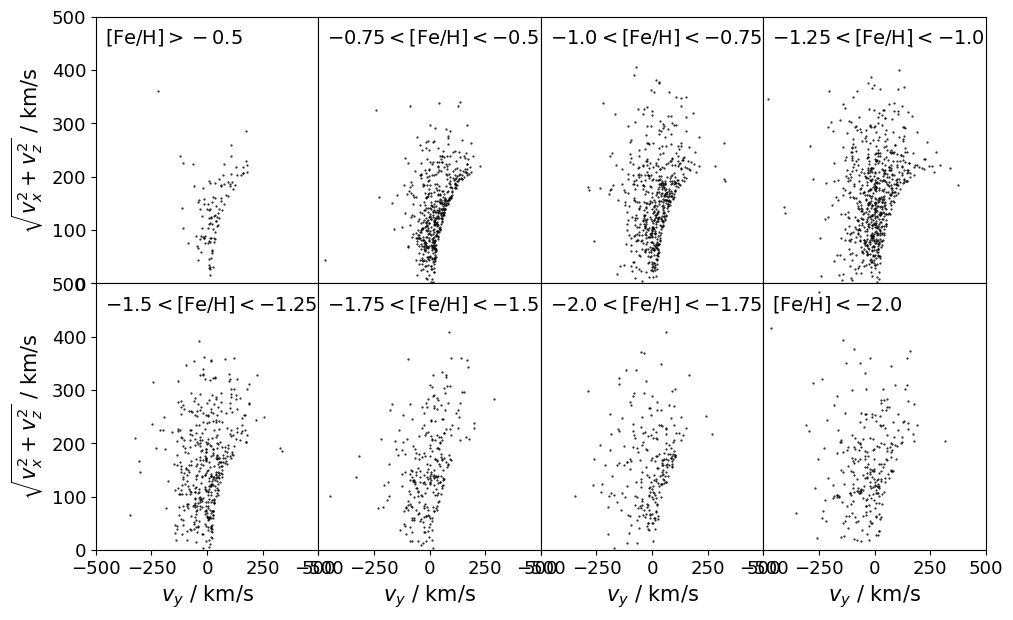

In [17]:
# incorporating the GALAH metallicities by doing metallicity cuts and colour coding
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,6),sharex=True,sharey=True,gridspec_kw={'width_ratios': [1, 1.1]})
axs[0].scatter(L_z[cond_halo & clean_flag_galah & flag_fe_h]/1000000,orb_E[cond_halo & clean_flag_galah & flag_fe_h]/100000,s=0.11,c=feh_galah[cond_halo & clean_flag_galah & flag_fe_h])
axs[0].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
axs[0].set_ylabel('$E$ / $10^5$(km/s)$^2$',size=14)
axs[0].set_title('$\lambda_z$-selection',size=17)
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-2.2,-0.5)
cbar=axs[1].scatter(L_z[cond_v & clean_flag_galah & flag_fe_h]/1000000,orb_E[cond_v & clean_flag_galah & flag_fe_h]/100000,s=0.11,c=feh_galah[cond_v & clean_flag_galah & flag_fe_h])
axs[1].set_xlabel('$L_z$ / $10^3$kpc*km/s',size=14)
axs[1].set_title('$|v-v_{\mathrm{LSR}}|>210$km/s',size=17)
axs[1].tick_params(axis='y',which='both',left=False,labelleft=False)
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-2.2,-0.5)
plt.colorbar(cbar,fraction=0.06,pad=0.05).set_label(label='[Fe/H] / dex',size=14)
plt.tight_layout()
plt.savefig('figures/5_23a_colourcode_metal_E_Lz_GALAH.png',format='png') 

## incorporating the GALAH metallicities by doing metallicity cuts and colour coding
#fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,6),sharex=True,sharey=True,gridspec_kw={'width_ratios': [1, 1.1]})
#axs[0].scatter(v_y[cond_halo & clean_flag_galah & flag_fe_h],v_zx[cond_halo & clean_flag_galah & flag_fe_h],s=0.11,c=feh_galah[cond_halo & clean_flag_galah & flag_fe_h])
#axs[0].set_xlabel('$v_y$ / km/s',size=14)
#axs[0].set_ylabel('$\sqrt{v_x^2+v_z^2}$ / km/s',size=14)
#axs[0].set_title('$\lambda_z$-selection',size=17)
#axs[0].set_xlim(-750,750)
#axs[0].set_ylim(0,750)
#cbar=axs[1].scatter(v_y[cond_v & clean_flag_galah & flag_fe_h],v_zx[cond_v & clean_flag_galah & flag_fe_h],s=0.11,c=feh_galah[cond_v & clean_flag_galah & flag_fe_h])
#axs[1].set_xlabel('$v_y$ / km/s',size=14)
#axs[1].set_title('$|v-v_{\mathrm{LSR}}|>210$km/s',size=17)
#axs[1].tick_params(axis='y',which='both',left=False,labelleft=False)
#axs[1].set_xlim(-750,750)
#axs[1].set_ylim(0,750)
#plt.colorbar(cbar,fraction=0.06,pad=0.05).set_label(label='[Fe/H] / dex',size=14)
#plt.tight_layout()
#plt.savefig('figures/5_23b_colourcode_metal_vperp_vy_GALAH.png',format='png') 

# small metallicity increments
cond_feh1=(feh_galah>-0.5)
cond_feh2=(feh_galah<-0.5) & (feh_galah>-0.75)
cond_feh3=(feh_galah<-0.75) & (feh_galah>-1.0)
cond_feh4=(feh_galah<-1.0) & (feh_galah>-1.25)
cond_feh5=(feh_galah<-1.25) & (feh_galah>-1.5)
cond_feh6=(feh_galah<-1.5) & (feh_galah>-1.75)
cond_feh7=(feh_galah<-1.75) & (feh_galah>-2.0)
cond_feh8=(feh_galah<-2.0)

def kinplot_metalcut(cond,xquan,yquan,xlab,ylab,xlim,ylim):
    cond_feh=[cond_feh1,cond_feh2,cond_feh3,cond_feh4,cond_feh5,cond_feh6,cond_feh7,cond_feh8]
    feh_annot=['$\mathrm{[Fe/H]}>-0.5$','$-0.75<\mathrm{[Fe/H]}<-0.5$','$-1.0<\mathrm{[Fe/H]}<-0.75$','$-1.25<\mathrm{[Fe/H]}<-1.0$','$-1.5<\mathrm{[Fe/H]}<-1.25$','$-1.75<\mathrm{[Fe/H]}<-1.5$','$-2.0<\mathrm{[Fe/H]}<-1.75$','$\mathrm{[Fe/H]}<-2.0$']
    for i in range(8):
        ax=fig.add_subplot(2,4,i+1)
        plt.scatter(xquan[cond & cond_feh[i]],yquan[cond & cond_feh[i]],s=0.25,color='black')
        plt.annotate(feh_annot[i],size=14, xy=(0.04, 0.9), xycoords='axes fraction')
        plt.xlim(xlim)
        plt.ylim(ylim)
        if (i==1) or (i==2) or (i==3):
            plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
        elif (i==5) or (i==6) or (i==7):
            plt.xlabel(xlab,size=15)
            plt.tick_params(axis='x',labelsize=13)
            plt.tick_params(axis='y',which='both',left=False,labelleft=False)
        elif (i==0):
            plt.ylabel(ylab,size=15)
            plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
            plt.tick_params(axis='y',labelsize=13)
        elif (i==4):
            plt.xlabel(xlab,size=15)
            plt.ylabel(ylab,size=15)
            plt.tick_params(axis='both',labelsize=13)
    plt.subplots_adjust(wspace=0,hspace=0,left=0.1,bottom=0.1,top=0.989,right=0.99)
    
#fig=plt.figure(figsize=(10,6))
#kinplot_metalcut(cond_halo & clean_flag_galah & flag_fe_h,L_z/1000000,orb_E/100000,'$L_z$ / $10^3$kpc*km/s','$E$ / $10^5$(km/s)$^2$',[-4,4],[-2.2,-0.5])
#plt.savefig('figures/5_23c_orbE_Lz_metalcuts_condhalo_GALAH.png',format='png') 

fig=plt.figure(figsize=(10,6))
kinplot_metalcut(cond_v & clean_flag_galah & flag_fe_h,L_z/1000000,orb_E/100000,'$L_z$ / $10^3$kpc*km/s','$E$ / $10^5$(km/s)$^2$',[-4,4],[-2.2,-0.5])
plt.savefig('figures/5_23d_orbE_Lz_metalcuts_condv_GALAH.png',format='png')

#fig=plt.figure(figsize=(10,6))
#kinplot_metalcut(cond_halo & clean_flag_galah & flag_fe_h,v_y,v_zx,'$v_y$ / km/s','$\sqrt{v_x^2+v_z^2}$ / km/s',[-500,500],[0,500])
#plt.savefig('figures/5_23d_vperp_vy_metalcuts_condhalo_GALAH.png',format='png') 

fig=plt.figure(figsize=(10,6))
kinplot_metalcut(cond_v & clean_flag_galah & flag_fe_h,v_y,v_zx,'$v_y$ / km/s','$\sqrt{v_x^2+v_z^2}$ / km/s',[-500,500],[0,500])
plt.savefig('figures/5_23f_vperp_vy_metalcuts_condv_GALAH.png',format='png') 

### 5.4.4. [alpha/Fe] properties of the selected halo


GALAH DR3:
With the condition |v-v_LSR|>210 km/s, only 78319 objects remain.
With the $\lambda_z$-selection, only 115568 objects remain.
Selecting via |v-v_LSR|>210 km/s:
Among these, 41288 are prograde.
Among these, 31761 are retrograde.
However, these plots contain only 1524 prograde and 1323 retrograde stars due to availability of data and cleaning of flags.
Number of kinematic halo stars with [Fe/H]: 3064
Number of kinematic halo stars with [alpha/Fe]: 2861
Number of kinematic halo stars with both: 2860


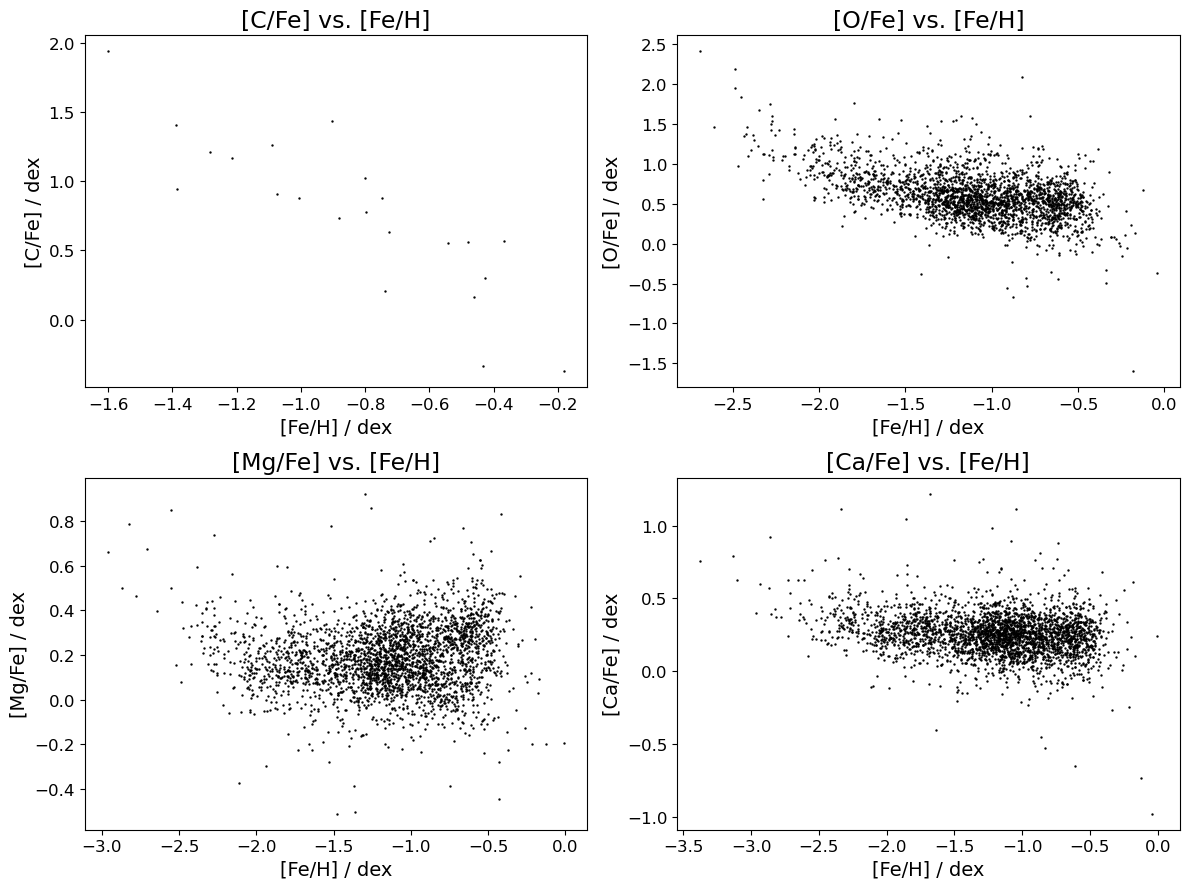

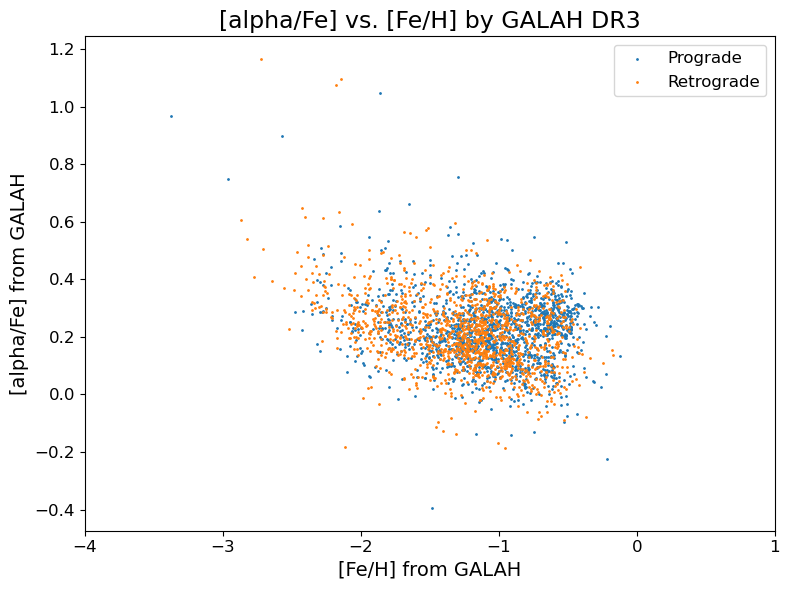

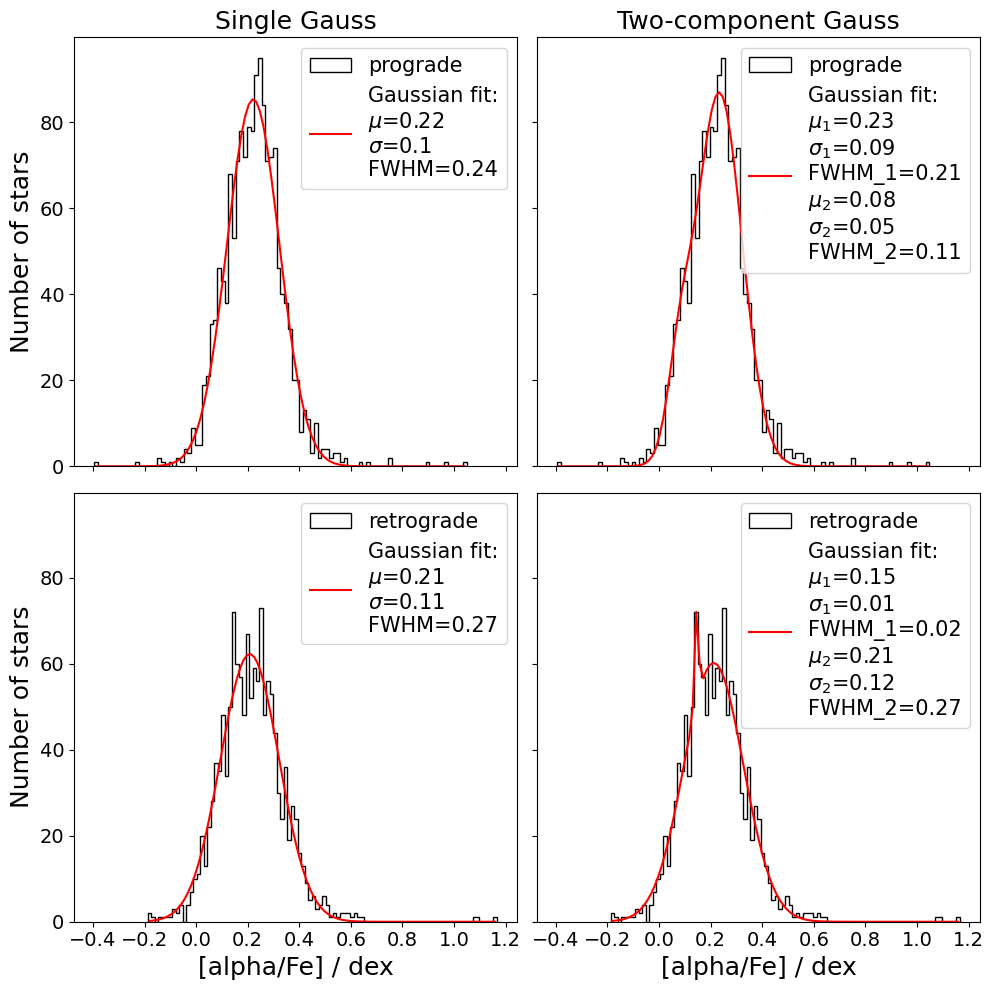

In [18]:
# beyond [Fe/H] abundance
# individual alpha elements GALAH
# C, O, Mg, Ca
fig2=plt.figure(figsize=(12,9))
ax = fig2.add_subplot(2,2,1,projection='scatter_density')
plt.scatter(feh_galah[cond_v & clean_flag_galah & flag_cfe],cfe_galah[cond_v & clean_flag_galah & flag_cfe],marker='.',s=2,color='black')
plt.xlabel('[Fe/H] / dex',size=14)
plt.ylabel('[C/Fe] / dex',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('[C/Fe] vs. [Fe/H]',size=17)
ax = fig2.add_subplot(2,2,2,projection='scatter_density')
plt.scatter(feh_galah[cond_v & clean_flag_galah & flag_ofe],ofe_galah[cond_v & clean_flag_galah & flag_ofe],marker='.',s=2,color='black')
plt.xlabel('[Fe/H] / dex',size=14)
plt.ylabel('[O/Fe] / dex',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('[O/Fe] vs. [Fe/H]',size=17)
ax = fig2.add_subplot(2,2,3,projection='scatter_density')
plt.scatter(feh_galah[cond_v & clean_flag_galah & flag_mgfe],mgfe_galah[cond_v & clean_flag_galah & flag_mgfe],marker='.',s=2,color='black')
plt.xlabel('[Fe/H] / dex',size=14)
plt.ylabel('[Mg/Fe] / dex',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('[Mg/Fe] vs. [Fe/H]',size=17)
ax = fig2.add_subplot(2,2,4,projection='scatter_density')
plt.scatter(feh_galah[cond_v & clean_flag_galah & flag_cafe],cafe_galah[cond_v & clean_flag_galah & flag_cafe],marker='.',s=2,color='black')
plt.xlabel('[Fe/H] / dex',size=14)
plt.ylabel('[Ca/Fe] / dex',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('[Ca/Fe] vs. [Fe/H]',size=17)
plt.tight_layout()
plt.savefig('figures/5_24b_alpha_elements_vs_feh_condv.png',format='png') 

# alpha abundances prograde vs. retrograde
print('\nGALAH DR3:')
print('With the condition |v-v_LSR|>210 km/s, only '+str(len(evt_data[cond_v]))+' objects remain.')
print('With the $\lambda_z$-selection, only '+str(len(evt_data[cond_halo]))+' objects remain.')

cond_pro = L_z > 0
cond_retro = L_z < 0

fig4=plt.figure(figsize=(8,6))
plt.scatter(feh_galah[cond_v & cond_pro & clean_flag_galah & flag_alpha_fe & flag_fe_h],alphafe_galah[cond_v & cond_pro & clean_flag_galah & flag_alpha_fe & flag_fe_h],marker='.',s=4,label='Prograde')
plt.scatter(feh_galah[cond_v & cond_retro & clean_flag_galah & flag_alpha_fe & flag_fe_h],alphafe_galah[cond_v & cond_retro & clean_flag_galah & flag_alpha_fe & flag_fe_h],marker='.',s=4,label='Retrograde')
plt.xlabel('[Fe/H] from GALAH',size=14)
plt.ylabel('[alpha/Fe] from GALAH',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim(-4,1)
plt.title('[alpha/Fe] vs. [Fe/H] by GALAH DR3',size=17)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('figures/5_24d_alpha_elements_gen_vs_feh_condv.png',format='png') 

# how many?
print('Selecting via |v-v_LSR|>210 km/s:')
print('Among these, '+str(len(evt_data[cond_v & cond_pro]))+' are prograde.')
print('Among these, '+str(len(evt_data[cond_v & cond_retro]))+' are retrograde.')
print('However, these plots contain only '+str(len(evt_data[cond_v & cond_pro & clean_flag_galah & flag_fe_h & flag_alpha_fe]))+' prograde and '+str(len(evt_data[cond_v & cond_retro & clean_flag_galah & flag_fe_h & flag_alpha_fe]))+' retrograde stars due to availability of data and cleaning of flags.')
print('Number of kinematic halo stars with [Fe/H]:',len(evt_data[cond_v & clean_flag_galah & flag_fe_h]))
print('Number of kinematic halo stars with [alpha/Fe]:',len(evt_data[cond_v & clean_flag_galah & flag_alpha_fe]))
print('Number of kinematic halo stars with both:',len(evt_data[cond_v & clean_flag_galah & flag_fe_h & flag_alpha_fe]))

# distribution of [alpha/Fe] for prograde and retrograde stars including Gaussian fits
def gaussian(x,A,mu,sig):
    return A/(np.sqrt(2*np.pi)*sig)*np.exp(-(x-mu)**2/(2*sig**2))

def multi_gaussian(x,A1,mu1,sig1,A2,mu2,sig2):
    g1=gaussian(x,A1,mu1,sig1)
    g2=gaussian(x,A2,mu2,sig2)
    return g1+g2

# [alpha/Fe] distribution (GALAH)
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(10,10),sharex=True,sharey=True)
n,bins,patches=axs[0,0].hist(alphafe_galah[cond_v & cond_pro & clean_flag_galah & flag_alpha_fe],bins=100,label='prograde',histtype='step', stacked=True, fill=False,color='black')
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
poptg,pcovg=curve_fit(gaussian,binscenters,n)
axs[0,0].plot(binscenters,gaussian(binscenters,poptg[0],poptg[1],poptg[2]),label='Gaussian fit:\n$\mu$='+str(round(poptg[1],2))+'\n$\sigma$='+str(round(poptg[2],2))+'\nFWHM='+str(round(2*np.sqrt(2*np.log(2))*poptg[2],2)),color='red')
axs[0,0].set_title('Single Gauss',size=18)
axs[0,0].legend(fontsize=15)
axs[0,0].set_ylabel('Number of stars',size=18)
axs[0,0].tick_params(axis='y',labelsize=14)
n,bins,patches=axs[1,0].hist(alphafe_galah[cond_v & cond_retro & clean_flag_galah & flag_alpha_fe],bins=100,label='retrograde',histtype='step', stacked=True, fill=False,color='black')
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
poptg,pcovg=curve_fit(gaussian,binscenters,n)
axs[1,0].plot(binscenters,gaussian(binscenters,poptg[0],poptg[1],poptg[2]),label='Gaussian fit:\n$\mu$='+str(round(poptg[1],2))+'\n$\sigma$='+str(round(poptg[2],2))+'\nFWHM='+str(round(2*np.sqrt(2*np.log(2))*poptg[2],2)),color='red')
axs[1,0].legend(fontsize=15)
axs[1,0].set_xlabel('[alpha/Fe] / dex',size=18)
axs[1,0].set_ylabel('Number of stars',size=18)
axs[1,0].tick_params(axis='both',labelsize=14)
n,bins,patches=axs[0,1].hist(alphafe_galah[cond_v & cond_pro & clean_flag_galah & flag_alpha_fe],bins=100,label='prograde',histtype='step', stacked=True, fill=False,color='black')
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
poptg,pcovg=curve_fit(multi_gaussian,binscenters,n)
axs[0,1].plot(binscenters,multi_gaussian(binscenters,poptg[0],poptg[1],poptg[2],poptg[3],poptg[4],poptg[5]),label='Gaussian fit:\n$\mu_1$='+str(round(poptg[1],2))+'\n$\sigma_1$='+str(round(poptg[2],2))+'\nFWHM_1='+str(round(2*np.sqrt(2*np.log(2))*poptg[2],2))+'\n$\mu_2$='+str(round(poptg[4],2))+'\n$\sigma_2$='+str(round(poptg[5],2))+'\nFWHM_2='+str(round(2*np.sqrt(2*np.log(2))*poptg[5],2)),color='red')
axs[0,1].set_title('Two-component Gauss',size=18)
axs[0,1].legend(fontsize=15)
n,bins,patches=axs[1,1].hist(alphafe_galah[cond_v & cond_retro & clean_flag_galah & flag_alpha_fe],bins=100,label='retrograde',histtype='step', stacked=True, fill=False,color='black')
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
poptg,pcovg=curve_fit(multi_gaussian,binscenters,n)
axs[1,1].plot(binscenters,multi_gaussian(binscenters,poptg[0],poptg[1],poptg[2],poptg[3],poptg[4],poptg[5]),label='Gaussian fit:\n$\mu_1$='+str(round(poptg[1],2))+'\n$\sigma_1$='+str(round(poptg[2],2))+'\nFWHM_1='+str(round(2*np.sqrt(2*np.log(2))*poptg[2],2))+'\n$\mu_2$='+str(round(poptg[4],2))+'\n$\sigma_2$='+str(round(poptg[5],2))+'\nFWHM_2='+str(round(2*np.sqrt(2*np.log(2))*poptg[5],2)),color='red')
axs[1,1].legend(fontsize=15)
axs[1,1].set_xlabel('[alpha/Fe] / dex',size=18)
axs[1,1].tick_params(axis='x',labelsize=14)
plt.tight_layout()
plt.savefig('figures/5_24f_alpha_elements_pro_retro_gauss_condv.png',format='png') 

# 5.5. Candidate r-/s-/weak r- process-enriched stars in the target catalogue

In [19]:
table=evt_data
table = table[(table['flag_sp']!=-2**63)]
print('Number of objects crossmatch GALAH DR3 with kinematic subsample of target catalogue:',len(table))

ra = table['ra']
dec = table['dec']
bprp = table['gaiabp']-table['gaiarp']
bprp0 = table['bp_rp0']
gmag = table['gaiag']
M_G = table['M_G']
A_G = table['A_G']
bprp0_full=evt_data['bp_rp0']
M_G_full=evt_data['M_G']

# load abundances
teff = table['teff']
e_teff = table['e_teff']
logg = table['logg']
e_logg = table['e_logg']
feh_galah = table['fe_h']
e_feh_galah = table['e_fe_h']
alpha_fe = table['alpha_fe']
e_alpha_fe = table['e_alpha_fe']
srfe_galah = table['Sr_fe']
e_srfe_galah = table['e_Sr_fe']
yfe_galah = table['Y_fe']
e_yfe_galah = table['e_Y_fe']
zrfe_galah = table['Zr_fe']
e_zrfe_galah = table['e_Zr_fe']
bafe_galah = table['Ba_fe']
e_bafe_galah = table['e_Ba_fe']
lafe_galah = table['La_fe']
e_lafe_galah = table['e_La_fe']
cefe_galah = table['Ce_fe']
e_cefe_galah = table['e_Ce_fe']
ndfe_galah = table['Nd_fe']
e_ndfe_galah = table['e_Nd_fe']
smfe_galah = table['Sm_fe']
e_smfe_galah = table['e_Sm_fe']
eufe_galah = table['Eu_fe']
e_eufe_galah = table['e_Eu_fe']
flag_sp = table['flag_sp']
flag_fe_h = table['flag_fe_h']
flag_alpha_fe = table['flag_alpha_fe']
flag_sr_fe = table['flag_Sr_fe']
flag_y_fe = table['flag_Y_fe']
flag_zr_fe = table['flag_Zr_fe']
flag_ba_fe = table['flag_Ba_fe']
flag_la_fe = table['flag_La_fe']
flag_ce_fe = table['flag_Ce_fe']
flag_nd_fe = table['flag_Nd_fe']
flag_sm_fe = table['flag_Sm_fe']
flag_eu_fe = table['flag_Eu_fe']

#flag cleaning
feh_galah[flag_fe_h!=0] = np.nan
alpha_fe[flag_alpha_fe!=0] = np.nan
srfe_galah[flag_sr_fe!=0] = np.nan
yfe_galah[flag_y_fe!=0] = np.nan
zrfe_galah[flag_zr_fe!=0] = np.nan
bafe_galah[flag_ba_fe!=0] = np.nan
lafe_galah[flag_la_fe!=0] = np.nan
cefe_galah[flag_ce_fe!=0] = np.nan
ndfe_galah[flag_nd_fe!=0] = np.nan
smfe_galah[flag_sm_fe!=0] = np.nan
eufe_galah[flag_eu_fe!=0] = np.nan
e_feh_galah[flag_fe_h!=0] = np.nan
e_alpha_fe[flag_alpha_fe!=0] = np.nan
e_srfe_galah[flag_sr_fe!=0] = np.nan
e_yfe_galah[flag_y_fe!=0] = np.nan
e_zrfe_galah[flag_zr_fe!=0] = np.nan
e_bafe_galah[flag_ba_fe!=0] = np.nan
e_lafe_galah[flag_la_fe!=0] = np.nan
e_cefe_galah[flag_ce_fe!=0] = np.nan
e_ndfe_galah[flag_nd_fe!=0] = np.nan
e_smfe_galah[flag_sm_fe!=0] = np.nan
e_eufe_galah[flag_eu_fe!=0] = np.nan

Number of objects crossmatch GALAH DR3 with kinematic subsample of target catalogue: 55965


In [20]:
# Sun as reference
# Lodders et al (2009) / Prantzos et al (2020) abundance values for sun
atomic_Z_sun = np.array([38,39,40,41,42,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,62,63])
dict_sun = {'Sr':0, 'Y':1, 'Zr':2, 'Nb':3, 'Mo':4, 'Ru':5, 'Rh':6, 'Pd':7, 'Ag':8, 'Cd':9, 'In':10, 'Sn':11, 'Sb':12, 'Te':13, 'I':14, 'Xe':15, 'Cs':16, 'Ba':17, 'La':18, 'Ce':19, 'Pr':20, 'Nd':21, 'Sm':22, 'Eu':23}
logeps_sun = np.array([2.953,2.252,2.619,1.479,1.993,1.837,1.155,1.719,1.277,1.784,0.837,2.144,1.082,2.258,1.628,2.324,1.156,2.237,1.247,1.658,0.822,1.519,1.013,0.580]) # logeps(X) = log(X/H)+12
r_frac_sun = np.array([0.083,0.222,0.183,0.349,0.275,0.591,0.878,0.542,0.791,0.432,0.582,0.301,0.753,0.807,0.968,0.816,0.843,0.109,0.200,0.148,0.465,0.385,0.647,0.951]) # fraction of element produced through r-process
s_frac_sun = np.array([0.912,0.778,0.817,0.651,0.497,0.338,0.122,0.448,0.209,0.548,0.374,0.680,0.247,0.192,0.032,0.182,0.157,0.888,0.799,0.848,0.535,0.615,0.325,0.049]) # fraction of element produced through s-process
logeps_sun_r = np.log10(r_frac_sun) + logeps_sun # solar system r-process component
logeps_sun_s = np.log10(s_frac_sun) + logeps_sun # solar system s-process component

# HD 122563 (Honda et al. 2006) as reference
# abundances of HD 122563 according to Honda et al. (2006)
atomic_Z_hd = np.array([38,39,40,41,42,44,46,47,56,57,58,59,60,62,63])
dict_hd = {'Sr':0, 'Y':1, 'Zr':2, 'Nb':3, 'Mo':4, 'Ru':5, 'Pd':6, 'Ag':7, 'Ba':8, 'La':9, 'Ce':10, 'Pr':11, 'Nd':12, 'Sm':13, 'Eu':14}
logeps_hd = np.array([-0.11,-0.93,-0.28,-1.48,-0.87,-0.86,-1.36,-1.88,-1.62,-2.66,-1.83,-2.15,-2.01,-2.16,-2.77])
e_logeps_hd = np.array([0.08,0.09,0.16,0.17,0.17,0.17,0.17,0.17,0.12,0.10,0.18,0.17,0.10,0.17,0.17])

# GALAH DR3 abundances
atomic_Z_galah = np.array([38,39,40,56,57,58,60,62,63])
dict_galah = {'Sr':0, 'Y':1, 'Zr':2, 'Ba':3, 'La':4, 'Ce':5, 'Nd':6, 'Sm':7, 'Eu':8}
xfe_galah = np.array([srfe_galah,yfe_galah,zrfe_galah,bafe_galah,lafe_galah,cefe_galah,ndfe_galah,smfe_galah,eufe_galah])
logeps_sun_galah = np.array([[logeps_sun[dict_sun['Sr']]],[logeps_sun[dict_sun['Y']]],[logeps_sun[dict_sun['Zr']]],[logeps_sun[dict_sun['Ba']]],[logeps_sun[dict_sun['La']]],[logeps_sun[dict_sun['Ce']]],[logeps_sun[dict_sun['Nd']]],[logeps_sun[dict_sun['Sm']]],[logeps_sun[dict_sun['Eu']]]])
logeps_galah = xfe_galah + feh_galah + logeps_sun_galah # logeps of stars according to GALAH DR3: log eps(X) = [X/H] + log eps(X)_sun = [X/Fe] + [Fe/H] + log eps(X)_sun
e_logeps_galah = np.sqrt(np.array([e_srfe_galah,e_yfe_galah,e_zrfe_galah,e_bafe_galah,e_lafe_galah,e_cefe_galah,e_ndfe_galah,e_smfe_galah,e_eufe_galah])**2+e_feh_galah**2) # error thereof, atm only two error sources taken into consideration

# GALAH only has some elements that the references have
galah_sun_elem=np.array([],dtype='bool')
for i in range(len(atomic_Z_sun)):
    if atomic_Z_sun[i] in atomic_Z_galah:
        galah_sun_elem=np.append(galah_sun_elem,True)
    else:
        galah_sun_elem=np.append(galah_sun_elem,False)

galah_hd_elem=np.array([],dtype='bool')
for i in range(len(atomic_Z_hd)):
    if atomic_Z_hd[i] in atomic_Z_galah:
        galah_hd_elem=np.append(galah_hd_elem,True)
    else:
        galah_hd_elem=np.append(galah_hd_elem,False)

# scaled abundances Sun (for r process, normalise at Eu; for s process, normalise at Ba) and HD122563 weak r-process (normalise at Zr)
eu_norm = logeps_sun_r[dict_sun['Eu']] - logeps_galah[dict_galah['Eu']] # value to normalise for each individual star
ba_norm = logeps_sun_s[dict_sun['Ba']] - logeps_galah[dict_galah['Ba']] # value to normalise for each individual star
#sr_norm = logeps_hd[dict_hd['Sr']] - logeps_galah[dict_galah['Sr']] # value to normalise for each individual star
zr_norm = logeps_hd[dict_hd['Zr']] - logeps_galah[dict_galah['Zr']] # value to normalise for each individual star

logeps_sun_r_sc = logeps_sun_r.reshape((len(logeps_sun_r),1)) - eu_norm # normalise by Eu
logeps_sun_s_sc = logeps_sun_s.reshape((len(logeps_sun_s),1)) - ba_norm # normalise by Ba
logeps_hd_sc = logeps_hd.reshape((len(logeps_hd),1)) - zr_norm #- sr_norm # normalise by Sr

# calculate residuals for each element between scaled reference pattern and GALAH pattern
delta_logeps_sunrsc_galah = logeps_galah - logeps_sun_r_sc[galah_sun_elem]
delta_logeps_sunssc_galah = logeps_galah - logeps_sun_s_sc[galah_sun_elem]
delta_logeps_hdsc_galah = logeps_galah - logeps_hd_sc[galah_hd_elem]

# mean deviation of abundance from Sun r-process, Sun s-process, Honda's star
res_sun_r=np.nanmean(np.transpose(np.abs(delta_logeps_sunrsc_galah/e_logeps_galah)),axis=1)
res_sun_s=np.nanmean(np.transpose(np.abs(delta_logeps_sunssc_galah/e_logeps_galah)),axis=1)
res_hd=np.nanmean(np.transpose(np.abs(delta_logeps_hdsc_galah/np.transpose(np.sqrt(np.transpose(e_logeps_galah)**2+e_logeps_hd[galah_hd_elem]**2)))),axis=1)

# deviation of reference stars from solar-system r-process pattern and s-process pattern
# HD 122563
atomic_Z_hd = np.array([38,39,40,56,57,58,60,62,63])
dict_hd = {'Sr':0, 'Y':1, 'Zr':2, 'Ba':3, 'La':4, 'Ce':5, 'Nd':6, 'Sm':7, 'Eu':8}
logeps_hd = np.array([-0.11,-0.93,-0.28,-1.62,-2.66,-1.83,-2.01,-2.16,-2.77])
e_logeps_hd = np.array([0.08,0.09,0.16,0.12,0.10,0.18,0.10,0.17,0.17])

sun_hd_elem=np.array([],dtype='bool')
for i in range(len(atomic_Z_sun)):
    if atomic_Z_sun[i] in atomic_Z_hd:
        sun_hd_elem=np.append(sun_hd_elem,True)
    else:
        sun_hd_elem=np.append(sun_hd_elem,False)
        
eu_norm_hd = logeps_sun_r[dict_sun['Eu']] - logeps_hd[dict_hd['Eu']]
ba_norm_hd = logeps_sun_s[dict_sun['Ba']] - logeps_hd[dict_hd['Ba']]
logeps_sun_r_schd = logeps_sun_r - eu_norm_hd
logeps_sun_s_schd = logeps_sun_s - ba_norm_hd
delta_logeps_r_hd = logeps_hd - logeps_sun_r_schd[sun_hd_elem]
delta_logeps_s_hd = logeps_hd - logeps_sun_s_schd[sun_hd_elem]
sigdev_sunr_hd = np.mean(np.abs(delta_logeps_r_hd)/e_logeps_hd)
sigdev_suns_hd = np.mean(np.abs(delta_logeps_s_hd)/e_logeps_hd)

# CS 22892-052
atomic_Z_cs = np.array([38,39,40,56,57,58,60,62,63])
dict_cs = {'Sr':0, 'Y':1, 'Zr':2, 'Ba':3, 'La':4, 'Ce':5, 'Nd':6, 'Sm':7, 'Eu':8}
logeps_cs = np.array([0.45,-0.42,0.23,0.02,-0.84,-0.5,-0.27,-0.54,-0.95])
e_logeps_cs = np.array([0.13,0.1,0.12,0.05,0.05,0.07,0.3,0.13,0.05])

sun_cs_elem=np.array([],dtype='bool')
for i in range(len(atomic_Z_sun)):
    if atomic_Z_sun[i] in atomic_Z_cs:
        sun_cs_elem=np.append(sun_cs_elem,True)
    else:
        sun_cs_elem=np.append(sun_cs_elem,False)

hd_cs_elem=np.array([],dtype='bool')
for i in range(len(atomic_Z_cs)):
    if atomic_Z_cs[i] in atomic_Z_hd:
        hd_cs_elem=np.append(hd_cs_elem,True)
    else:
        hd_cs_elem=np.append(hd_cs_elem,False)

eu_norm_cs = logeps_sun_r[dict_sun['Eu']] - logeps_cs[dict_cs['Eu']]
ba_norm_cs = logeps_sun_s[dict_sun['Ba']] - logeps_cs[dict_cs['Ba']]
#sr_norm_cs = logeps_hd[dict_hd['Sr']] - logeps_cs[dict_cs['Sr']]
zr_norm_cs = logeps_hd[dict_hd['Zr']] - logeps_cs[dict_cs['Zr']]
logeps_sun_r_sccs = logeps_sun_r - eu_norm_cs
logeps_sun_s_sccs = logeps_sun_s - ba_norm_cs
logeps_hd_sccs = logeps_hd - zr_norm_cs#- sr_norm_cs
delta_logeps_r_cs = logeps_cs - logeps_sun_r_sccs[sun_cs_elem]
delta_logeps_s_cs = logeps_cs - logeps_sun_s_sccs[sun_cs_elem]
delta_logeps_hd_cs = logeps_cs - logeps_hd_sccs
sigdev_sunr_cs = np.mean(np.abs(delta_logeps_r_cs)/e_logeps_cs)
sigdev_suns_cs = np.mean(np.abs(delta_logeps_s_cs)/e_logeps_cs)
sigdev_hd_cs = np.mean(np.abs(delta_logeps_hd_cs)/np.sqrt(e_logeps_cs**2+e_logeps_hd**2))

# condition for only those objects that are enriched by r-process
baeu_galah = (bafe_galah - eufe_galah)
cond_rproc = (baeu_galah < 0.0) & (eufe_galah >= 0.3)
cond_sproc = (baeu_galah > 0.5) & (bafe_galah > 1.0)
cond_rsproc = (baeu_galah > 0) & (baeu_galah < 0.5)

/tmp/ipykernel_8260/4122183523.py:57: RuntimeWarning: Mean of empty slice
  res_sun_r=np.nanmean(np.transpose(np.abs(delta_logeps_sunrsc_galah/e_logeps_galah)),axis=1)

/tmp/ipykernel_8260/4122183523.py:58: RuntimeWarning: Mean of empty slice
  res_sun_s=np.nanmean(np.transpose(np.abs(delta_logeps_sunssc_galah/e_logeps_galah)),axis=1)

/tmp/ipykernel_8260/4122183523.py:59: RuntimeWarning: Mean of empty slice
  res_hd=np.nanmean(np.transpose(np.abs(delta_logeps_hdsc_galah/np.transpose(np.sqrt(np.transpose(e_logeps_galah)**2+e_logeps_hd[galah_hd_elem]**2)))),axis=1)



In [21]:
# define function to only use those objects later on that have enough elements available for meaningful analysis, create condition for this to apply to data
def count_elem(obj):
    n=0
    for i in range(len(logeps_galah)):
        if np.isnan(np.transpose(logeps_galah)[obj][i])==False:
            n=n+1
        else:
            pass
    return n

few_elem=np.array([],dtype='bool')
for i in range(len(feh_galah)):
    if count_elem(i)>=6:
        few_elem=np.append(few_elem,True)
    else:
        few_elem=np.append(few_elem,False)
        
print('There are '+str(len(res_sun_r[few_elem]))+' stars with at least 6 abundances available.')
print('Mean residuals to Solar r-process component determined for '+str(len(res_sun_r[few_elem & (np.isnan(eufe_galah)==False)]))+' stars.')
print('Mean residuals to Solar s-process component determined for '+str(len(res_sun_s[few_elem & (np.isnan(bafe_galah)==False)]))+' stars.')
print('Mean residuals to HD122563 determined for '+str(len(res_hd[few_elem & (np.isnan(zrfe_galah)==False)]))+' stars.')

There are 10173 stars with at least 6 abundances available.
Mean residuals to Solar r-process component determined for 8213 stars.
Mean residuals to Solar s-process component determined for 10143 stars.
Mean residuals to HD122563 determined for 7966 stars.


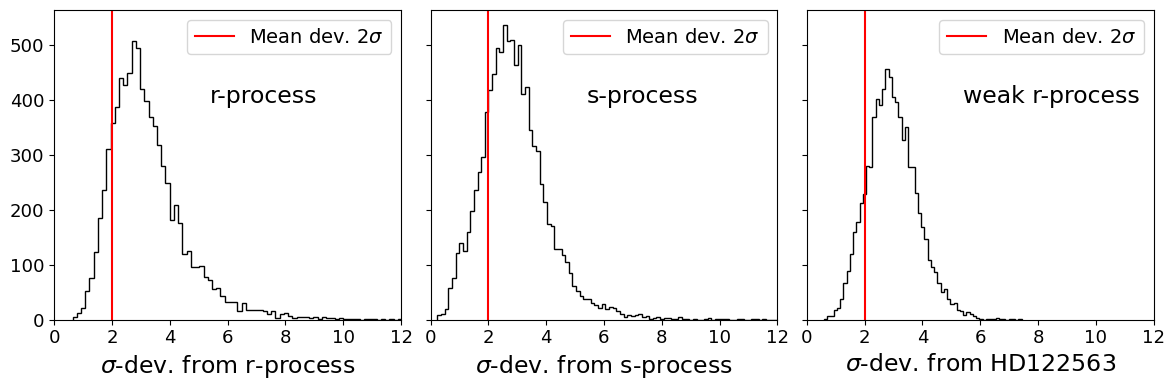

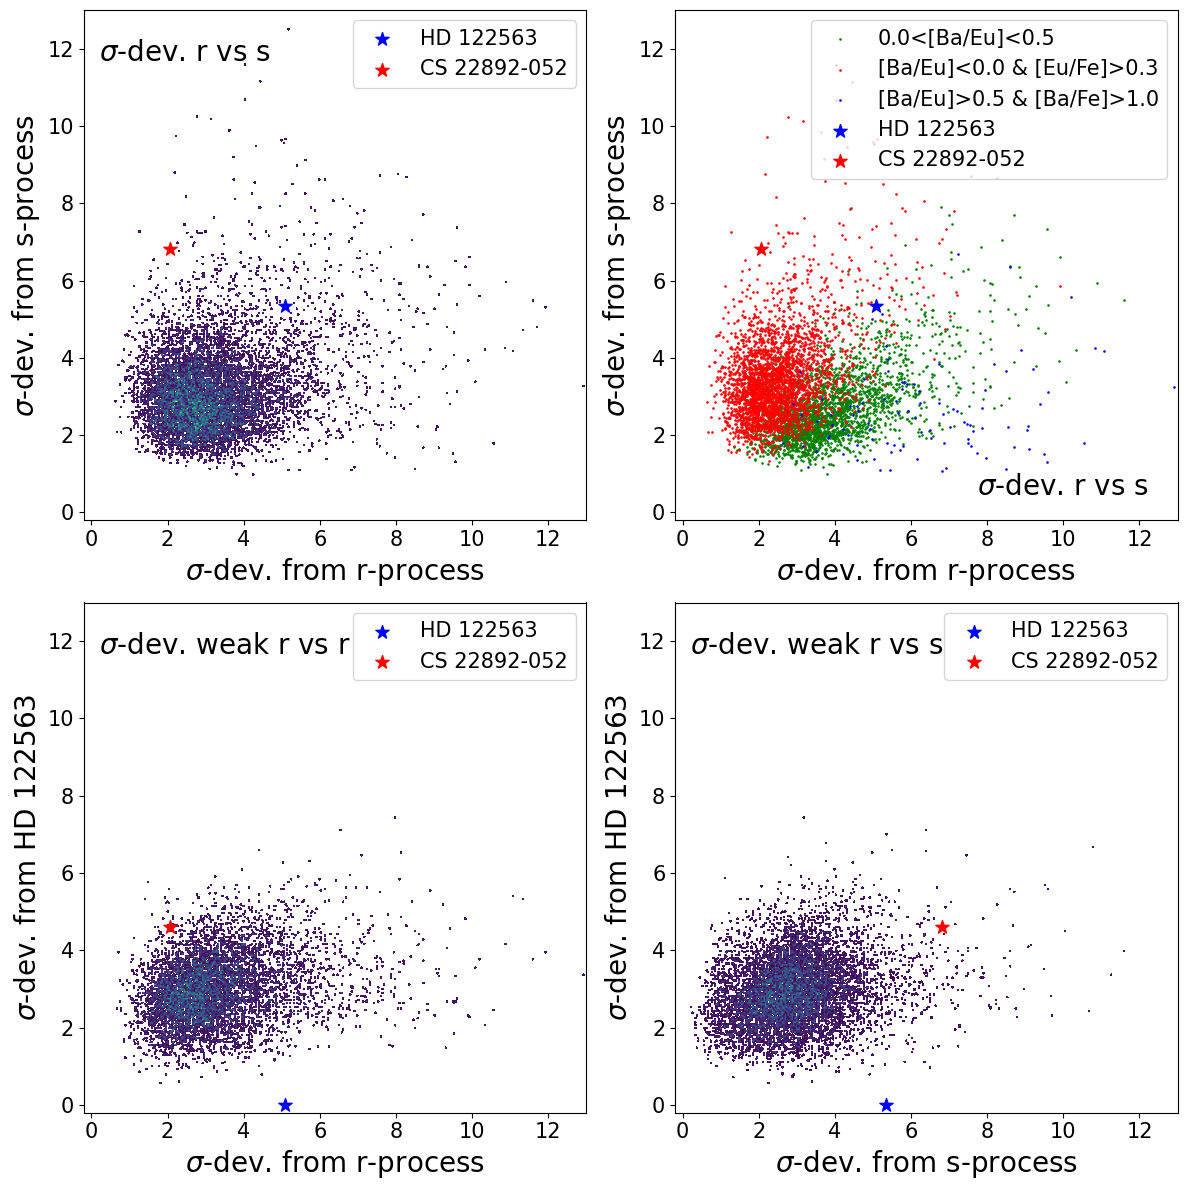

In [22]:
# histogram displaying the sigma deviations from respective patterns
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4),sharey=True)
axs[0].hist(res_sun_r[few_elem & (np.isnan(eufe_galah)==False)],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[0].set_xlabel('$\sigma$-dev. from r-process',size=17)
axs[0].axvline(2,label='Mean dev. $2\sigma$',color='red')
axs[0].annotate(r'r-process',size=17, xy=(0.45, 0.7), xycoords='axes fraction')
axs[0].set_xlim(0,12)
axs[0].legend(fontsize=14)
axs[0].tick_params(axis='both',which='major',labelsize=13)
axs[1].hist(res_sun_s[few_elem & (np.isnan(bafe_galah)==False)],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[1].set_xlabel('$\sigma$-dev. from s-process',size=17)
axs[1].axvline(2,label='Mean dev. $2\sigma$',color='red')
axs[1].annotate(r's-process',size=17, xy=(0.45, 0.7), xycoords='axes fraction')
axs[1].set_xlim(0,12)
axs[1].legend(fontsize=14)
axs[1].tick_params(axis='both',which='major',labelsize=13)
axs[2].hist(res_hd[few_elem & (np.isnan(zrfe_galah)==False)],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[2].set_xlabel('$\sigma$-dev. from HD122563',size=17)
axs[2].axvline(2,label='Mean dev. $2\sigma$',color='red')
axs[2].annotate(r'weak r-process',size=17, xy=(0.45, 0.7), xycoords='axes fraction')
axs[2].set_xlim(0,12)
axs[2].legend(fontsize=14)
axs[2].tick_params(axis='both',which='major',labelsize=13)
plt.tight_layout()
plt.savefig('figures/5_25a_sigdev_hist_patterns.png',format='png') 

# 2D plots where I plot the deviation from solar-system s-process component vs. deviation from solar-system r-process component, deviation from HD122563 vs. deviation from solar-system r-process component, and deviation from HD 122563 vs. deviation from solar-system s-process component
fig1=plt.figure(figsize=(12,12))
ax = fig1.add_subplot(2,2,1,projection='scatter_density')
density = ax.scatter_density(res_sun_r[few_elem & (np.isnan(res_sun_r)==False) & (np.isnan(res_sun_s)==False)],res_sun_s[few_elem & (np.isnan(res_sun_r)==False) & (np.isnan(res_sun_s)==False)],cmap=white_viridis)
plt.scatter(sigdev_sunr_hd,sigdev_suns_hd,label='HD 122563',marker='*',color='blue',s=100)
plt.scatter(sigdev_sunr_cs,sigdev_suns_cs,label='CS 22892-052',marker='*',color='red',s=100)
plt.xlabel('$\sigma$-dev. from r-process',size=20)
plt.ylabel('$\sigma$-dev. from s-process',size=20)
plt.annotate(r'$\sigma$-dev. r vs s',size=20, xy=(0.03, 0.9), xycoords='axes fraction')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-0.2,13)
plt.ylim(-0.2,13)
plt.legend(fontsize=15)
fig1.add_subplot(2,2,2,projection='scatter_density')
plt.scatter(res_sun_r[few_elem & cond_rsproc],res_sun_s[few_elem & cond_rsproc],marker='.',color='green',s=3,label='0.0<[Ba/Eu]<0.5')
plt.scatter(res_sun_r[few_elem & cond_rproc],res_sun_s[few_elem & cond_rproc],marker='.',color='red',s=3,label='[Ba/Eu]<0.0 & [Eu/Fe]>0.3')
plt.scatter(res_sun_r[few_elem & cond_sproc],res_sun_s[few_elem & cond_sproc],marker='.',color='blue',s=3,label='[Ba/Eu]>0.5 & [Ba/Fe]>1.0')
plt.scatter(sigdev_sunr_hd,sigdev_suns_hd,label='HD 122563',marker='*',color='blue',s=100)
plt.scatter(sigdev_sunr_cs,sigdev_suns_cs,label='CS 22892-052',marker='*',color='red',s=100)
plt.xlabel('$\sigma$-dev. from r-process',size=20)
plt.ylabel('$\sigma$-dev. from s-process',size=20)
plt.annotate(r'$\sigma$-dev. r vs s',size=20, xy=(0.6, 0.05), xycoords='axes fraction')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-0.2,13)
plt.ylim(-0.2,13)
plt.legend(fontsize=15)
ax = fig1.add_subplot(2,2,3,projection='scatter_density')
density = ax.scatter_density(res_sun_r[few_elem & (np.isnan(res_sun_r)==False) & (np.isnan(res_hd)==False)],res_hd[few_elem & (np.isnan(res_sun_r)==False) & (np.isnan(res_hd)==False)],cmap=white_viridis)
plt.scatter(sigdev_sunr_hd,0,label='HD 122563',marker='*',color='blue',s=100)
plt.scatter(sigdev_sunr_cs,sigdev_hd_cs,label='CS 22892-052',marker='*',color='red',s=100)
plt.xlabel('$\sigma$-dev. from r-process',size=20)
plt.ylabel('$\sigma$-dev. from HD 122563',size=20)
plt.annotate(r'$\sigma$-dev. weak r vs r',size=20, xy=(0.03, 0.9), xycoords='axes fraction')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-0.2,13)
plt.ylim(-0.2,13)
plt.legend(fontsize=15)
ax = fig1.add_subplot(2,2,4,projection='scatter_density')
density = ax.scatter_density(res_sun_s[few_elem & (np.isnan(res_sun_s)==False) & (np.isnan(res_hd)==False)],res_hd[few_elem & (np.isnan(res_sun_s)==False) & (np.isnan(res_hd)==False)],cmap=white_viridis)
plt.scatter(sigdev_suns_hd,0,label='HD 122563',marker='*',color='blue',s=100)
plt.scatter(sigdev_suns_cs,sigdev_hd_cs,label='CS 22892-052',marker='*',color='red',s=100)
plt.xlabel('$\sigma$-dev. from s-process',size=20)
plt.ylabel('$\sigma$-dev. from HD 122563',size=20)
plt.annotate(r'$\sigma$-dev. weak r vs s',size=20, xy=(0.03, 0.9), xycoords='axes fraction')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-0.2,13)
plt.ylim(-0.2,13)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('figures/5_25b_2d_plots_sigdev_patterns.png',format='png') 

The number of r-process candidates using this selection: 319
The number of s-process candidates using this selection: 253
The number of weak-r-process candidates using this selection: 283


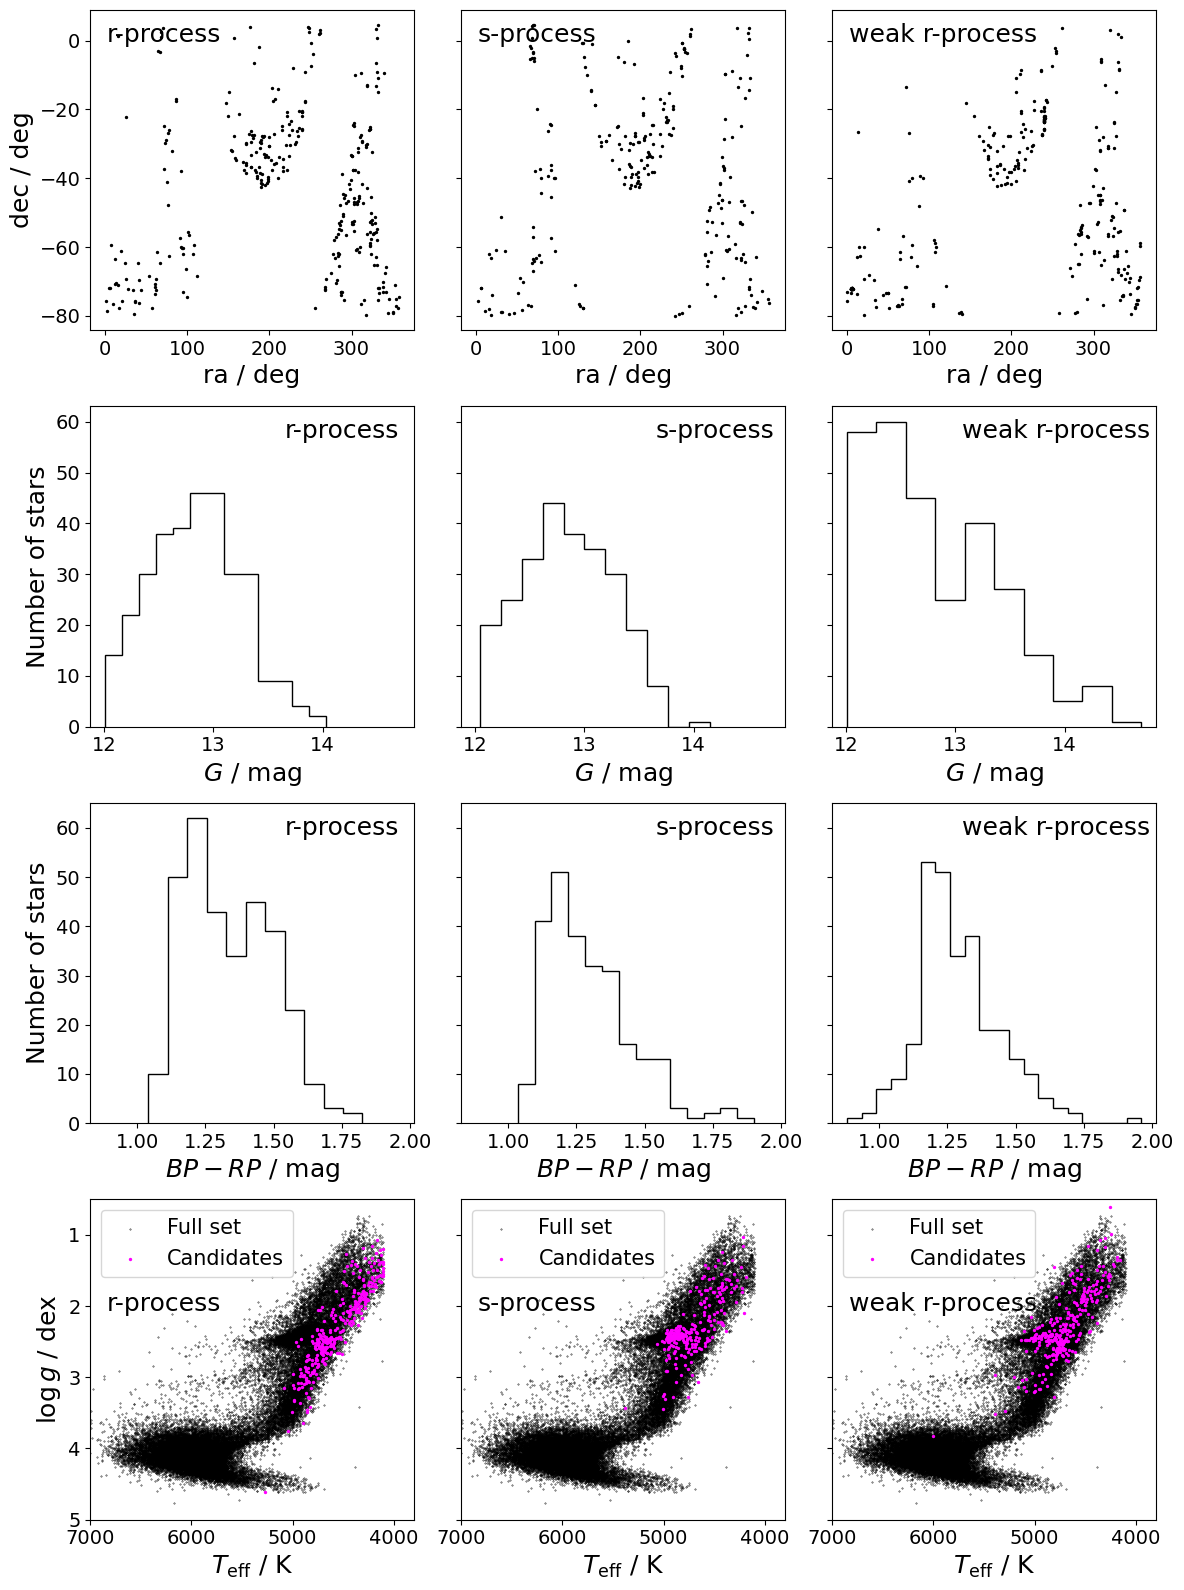

In [23]:
r_cand = few_elem & (res_sun_r<2.5) & (res_sun_s>3) & (res_hd>3)
s_cand = few_elem & (res_sun_r>3) & (res_sun_s<2.5) & (res_hd>3)
wr_cand = few_elem & (res_sun_r>3) & (res_sun_s>3) & (res_hd<2.5)

print('The number of r-process candidates using this selection:',len(table[r_cand]))
print('The number of s-process candidates using this selection:',len(table[s_cand]))
print('The number of weak-r-process candidates using this selection:',len(table[wr_cand]))

# plots on the distribution of the candidates samples
fig,axs = plt.subplots(nrows=4,ncols=3,figsize=(12,16),sharey='row',sharex='row')
axs[0,0].scatter(ra[r_cand],dec[r_cand],s=2,color='black')
axs[0,0].set_xlabel('ra / deg',size=18)
axs[0,0].set_ylabel('dec / deg',size=18)
axs[0,0].annotate(r'r-process',size=18, xy=(0.05, 0.9), xycoords='axes fraction')
axs[0,0].tick_params(axis='both',which='major',labelsize=14)
axs[0,1].scatter(ra[s_cand],dec[s_cand],s=2,color='black')
axs[0,1].set_xlabel('ra / deg',size=18)
axs[0,1].annotate(r's-process',size=18, xy=(0.05, 0.9), xycoords='axes fraction')
axs[0,1].tick_params(axis='both',which='major',labelsize=14)
axs[0,2].scatter(ra[wr_cand],dec[wr_cand],s=2,color='black')
axs[0,2].set_xlabel('ra / deg',size=18)
axs[0,2].annotate(r'weak r-process',size=18, xy=(0.05, 0.9), xycoords='axes fraction')
axs[0,2].tick_params(axis='both',which='major',labelsize=14)
axs[1,0].hist(gmag[r_cand],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[1,0].set_xlabel('$G$ / mag',size=18)
axs[1,0].set_ylabel('Number of stars',size=18)
axs[1,0].annotate(r'r-process',size=18, xy=(0.6, 0.9), xycoords='axes fraction')
axs[1,0].tick_params(axis='both',which='major',labelsize=14)
axs[1,1].hist(gmag[s_cand],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[1,1].set_xlabel('$G$ / mag',size=18)
axs[1,1].annotate(r's-process',size=18, xy=(0.6, 0.9), xycoords='axes fraction')
axs[1,1].tick_params(axis='both',which='major',labelsize=14)
axs[1,2].hist(gmag[wr_cand],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[1,2].set_xlabel('$G$ / mag',size=18)
axs[1,2].annotate(r'weak r-process',size=18, xy=(0.4, 0.9), xycoords='axes fraction')
axs[1,2].tick_params(axis='both',which='major',labelsize=14)
axs[2,0].hist(bprp[r_cand],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[2,0].set_xlabel('$BP-RP$ / mag',size=18)
axs[2,0].set_ylabel('Number of stars',size=18)
axs[2,0].annotate(r'r-process',size=18, xy=(0.6, 0.9), xycoords='axes fraction')
axs[2,0].tick_params(axis='both',which='major',labelsize=14)
axs[2,1].hist(bprp[s_cand],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[2,1].set_xlabel('$BP-RP$ / mag',size=18)
axs[2,1].annotate(r's-process',size=18, xy=(0.6, 0.9), xycoords='axes fraction')
axs[2,1].tick_params(axis='both',which='major',labelsize=14)
axs[2,2].hist(bprp[wr_cand],bins='auto',histtype='step', stacked=True, fill=False,color='black')
axs[2,2].set_xlabel('$BP-RP$ / mag',size=18)
axs[2,2].annotate(r'weak r-process',size=18, xy=(0.4, 0.9), xycoords='axes fraction')
axs[2,2].tick_params(axis='both',which='major',labelsize=14)
axs[3,0].scatter(teff[flag_sp==0],logg[flag_sp==0],s=0.1,color='black',label='Full set')
axs[3,0].scatter(teff[r_cand],logg[r_cand],s=2,color='magenta',label='Candidates')
axs[3,0].set_xlabel('$T_\mathrm{eff}$ / K',size=18)
axs[3,0].set_ylabel('$\log{g}$ / dex',size=18)
axs[3,0].set_ylim(5,0.5)
axs[3,0].set_xlim(7000,3800)
axs[3,0].annotate(r'r-process',size=18, xy=(0.05, 0.65), xycoords='axes fraction')
axs[3,0].tick_params(axis='both',which='major',labelsize=14)
axs[3,0].legend(fontsize=15,loc=2)
axs[3,1].scatter(teff[flag_sp==0],logg[flag_sp==0],s=0.1,color='black',label='Full set')
axs[3,1].scatter(teff[s_cand],logg[s_cand],s=2,color='magenta',label='Candidates')
axs[3,1].set_xlabel('$T_\mathrm{eff}$ / K',size=18)
axs[3,1].set_ylim(5,0.5)
axs[3,1].set_xlim(7000,3800)
axs[3,1].annotate(r's-process',size=18, xy=(0.05, 0.65), xycoords='axes fraction')
axs[3,1].legend(fontsize=15,loc=2)
axs[3,1].tick_params(axis='both',which='major',labelsize=14)
axs[3,2].scatter(teff[flag_sp==0],logg[flag_sp==0],s=0.1,color='black',label='Full set')
axs[3,2].scatter(teff[wr_cand],logg[wr_cand],s=2,color='magenta',label='Candidates')
axs[3,2].set_xlabel('$T_\mathrm{eff}$ / K',size=18)
axs[3,2].set_ylim(5,0.5)
axs[3,2].set_xlim(7000,3800)
axs[3,2].annotate(r'weak r-process',size=18, xy=(0.05, 0.65), xycoords='axes fraction')
axs[3,2].tick_params(axis='both',which='major',labelsize=14)
axs[3,2].legend(fontsize=15,loc=2)
plt.tight_layout()
plt.savefig('figures/5_26_stat_prop_cand_samples.png',format='png') 

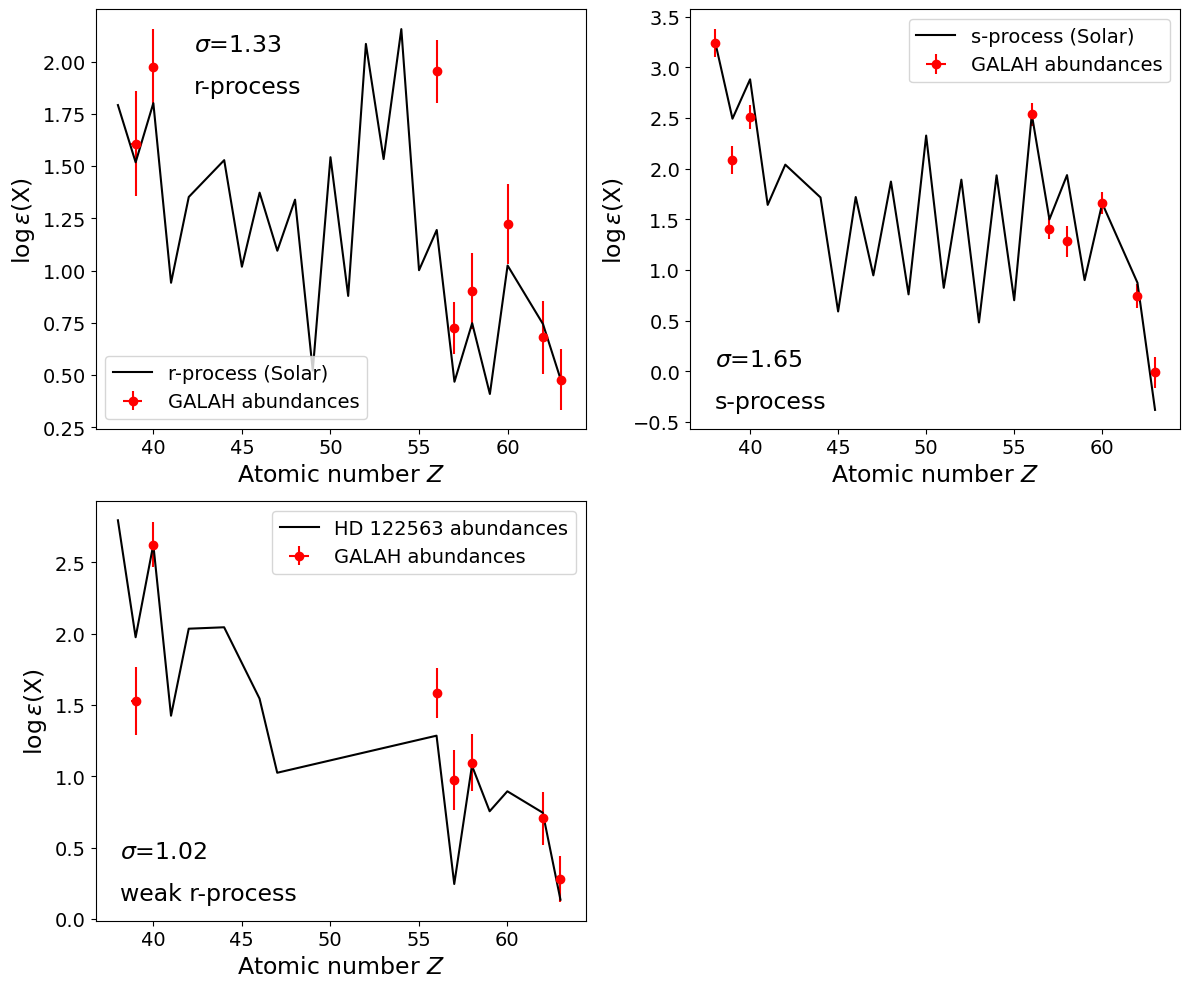

In [24]:
# examples of comparison logeps for a stars selected from each candidate sample
atomic_Z_hd = np.array([38,39,40,41,42,44,46,47,56,57,58,59,60,62,63])

r=10591
s=7069
wr=6748

fig2=plt.figure(figsize=(12,10))
fig2.add_subplot(2,2,1)
plt.errorbar(atomic_Z_galah,np.transpose(logeps_galah)[r],np.transpose(e_logeps_galah)[r],np.transpose(e_logeps_galah)[r],marker='o',linestyle='None',color='red',label='GALAH abundances')
plt.plot(atomic_Z_sun,np.transpose(logeps_sun_r_sc)[r],label='r-process (Solar)',color='black')
plt.xlabel('Atomic number $Z$',size=17)
plt.ylabel('$\log\epsilon$(X)',size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14,loc=3)
plt.annotate(r'r-process',size=17, xy=(0.2, 0.8), xycoords='axes fraction')
plt.annotate(r'$\sigma$='+str(round(res_sun_r[r],2)),size=17, xy=(0.2, 0.9), xycoords='axes fraction')
fig2.add_subplot(2,2,2)
plt.errorbar(atomic_Z_galah,np.transpose(logeps_galah)[s],np.transpose(e_logeps_galah)[s],np.transpose(e_logeps_galah)[s],marker='o',linestyle='None',color='red',label='GALAH abundances')
plt.plot(atomic_Z_sun,np.transpose(logeps_sun_s_sc)[s],label='s-process (Solar)',color='black')
plt.xlabel('Atomic number $Z$',size=17)
plt.ylabel('$\log\epsilon$(X)',size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14,loc=1)
plt.annotate(r's-process',size=17, xy=(0.05, 0.05), xycoords='axes fraction')
plt.annotate(r'$\sigma$='+str(round(res_sun_s[s],2)),size=17, xy=(0.05, 0.15), xycoords='axes fraction')
fig2.add_subplot(2,2,3)
plt.errorbar(atomic_Z_galah,np.transpose(logeps_galah)[wr],np.transpose(e_logeps_galah)[wr],np.transpose(e_logeps_galah)[wr],marker='o',linestyle='None',color='red',label='GALAH abundances')
plt.plot(atomic_Z_hd,np.transpose(logeps_hd_sc)[wr],label='HD 122563 abundances',color='black')
plt.xlabel('Atomic number $Z$',size=17)
plt.ylabel('$\log\epsilon$(X)',size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14,loc=1)
plt.annotate(r'weak r-process',size=17, xy=(0.05, 0.05), xycoords='axes fraction')
plt.annotate(r'$\sigma$='+str(round(res_hd[wr],2)),size=17, xy=(0.05, 0.15), xycoords='axes fraction')
plt.tight_layout()
plt.savefig('figures/5_27_example_pattern_comp.png',format='png')